from https://www.kaggle.com/code/ahsuna123/hull-tactical-complete-eda-deep-dive#Advanced-EDA-Extensions-for-Financial-Time-Series-Analysis

# Hull Tactical · Market Prediction

This competition, hosted by Hull Tactical, challenges participants to **predict the daily forward returns of the S&P 500 index**.  
The dataset provides decades of market information across multiple factor families:

- **M\*** — Market dynamics and technical features  
- **E\*** — Macro-economic indicators  
- **I\*** — Interest rate features  
- **P\*** — Price and valuation metrics  
- **V\*** — Volatility measures  
- **S\*** — Sentiment variables  
- **MOM\*** — Momentum-based indicators  
- **D\*** — Dummy/binary features  

The target variable is `forward_returns`, representing the next-day return from buying the S&P 500 and selling one day later.  
Additional columns like `risk_free_rate` and `market_forward_excess_returns` are included to capture relative performance against expectations.

The competition proceeds in **two phases**:
1. **Training phase** — model development using historical data. Public leaderboard here is **not meaningful**, since it’s based on a mock test slice.  
2. **Forecasting phase** — evaluation on truly unseen, future data via the Kaggle evaluation API. Final leaderboard scores will be based on this phase.

The goal is to build robust, generalizable models that can extract signal from noisy financial data while avoiding overfitting to the training set.


### Importing libraries and setting configurations
We begin by loading the essential Python libraries for data handling, visualization, and feature analysis.  
- **pandas / numpy** for data wrangling and numerical operations  
- **matplotlib / seaborn / plotly** for static and interactive visualizations  
- **scipy.stats** for statistical tests (e.g., normality checks)  
- **scikit-learn tools** like `StandardScaler`, `PCA`, and `mutual_info_regression` for preprocessing and feature analysis  

We also configure warnings and set default plotting styles to keep our notebook outputs clean and consistent.


In [1]:
# import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from datetime import datetime, timedelta
from scipy import stats
from scipy.stats import jarque_bera, shapiro
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

# Configuration
warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# 1. DATA LOADING AND INITIAL INSPECTION

We start by reading the training and test datasets provided by the competition.  
Key steps in this section include:
- Checking the **shape** of both datasets and the **date range** covered in the training data.  
- Summarizing **memory usage** and **data types** to understand dataset size and composition.  
- Displaying the **first few rows** to get a quick sense of the feature structure (M*, E*, I*, P*, V*, S*, MOM*, D*).  
- Verifying if there are any **duplicate rows** in the training set.  

This initial inspection helps us confirm the integrity of the data and sets the stage for deeper exploratory analysis.


In [2]:
def load_and_inspect_data():
    """Load and perform initial inspection of the dataset"""
    
    print("🔍 LOADING AND INSPECTING DATA")
    print("="*50)
    
    # Load datasets
    train_df = pd.read_csv('/kaggle/input/hull-tactical-market-prediction/train.csv')
    test_df = pd.read_csv('/kaggle/input/hull-tactical-market-prediction/test.csv')
    
    print(f"📊 Training set shape: {train_df.shape}")
    print(f"📊 Test set shape: {test_df.shape}")
    print(f"📅 Date range: {train_df['date_id'].min()} to {train_df['date_id'].max()}")
    
    # Basic info about the datasets
    print("\n📋 TRAINING SET INFO:")
    print(f"Memory usage: {train_df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    print(f"Data types distribution:")
    print(train_df.dtypes.value_counts())
    
    # Display first few rows
    print("\n🔍 First 5 rows of training data:")
    display(train_df.head())
    
    # Check for duplicates
    duplicates = train_df.duplicated().sum()
    print(f"\n🔍 Duplicate rows in training set: {duplicates}")
    
    return train_df, test_df

train_df, test_df = load_and_inspect_data()

🔍 LOADING AND INSPECTING DATA
📊 Training set shape: (8990, 98)
📊 Test set shape: (10, 99)
📅 Date range: 0 to 8989

📋 TRAINING SET INFO:
Memory usage: 6.72 MB
Data types distribution:
float64    88
int64      10
Name: count, dtype: int64

🔍 First 5 rows of training data:


date_id  D1  D2  D3  D4  D5  D6  D7  D8  D9  ...  V3  V4  V5  V6  V7  V8  \
0        0   0   0   0   1   1   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
1        1   0   0   0   1   1   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
2        2   0   0   0   1   0   0   0   0   1  ... NaN NaN NaN NaN NaN NaN   
3        3   0   0   0   1   0   0   0   0   0  ... NaN NaN NaN NaN NaN NaN   
4        4   0   0   0   1   0   0   0   0   0  ... NaN NaN NaN NaN NaN NaN   

   V9  forward_returns  risk_free_rate  market_forward_excess_returns  
0 NaN        -0.002421        0.000301                      -0.003038  
1 NaN        -0.008495        0.000303                      -0.009114  
2 NaN        -0.009624        0.000301                      -0.010243  
3 NaN         0.004662        0.000299                       0.004046  
4 NaN        -0.011686        0.000299                      -0.012301  

[5 rows x 98 columns]


🔍 Duplicate rows in training set: 0


# 2. MISSING VALUES ANALYSIS

Understanding the structure of missing data is crucial in financial time-series modeling. This function provides a **comprehensive overview of missing values** in the dataset:  

1. **Overall Statistics**  
   - Total missing values across the dataset.  
   - Percentage of missing entries relative to the entire data matrix.  

2. **Column-Level Missingness**  
   - Displays the top 20 columns with the most missing values.  
   - Helps identify whether certain features are systematically sparse.  

3. **Visual Diagnostics**  
   - **Heatmap (first 50 columns):** Provides a bird’s-eye view of missing patterns across features. Vertical bands may indicate entire columns with missing values, while horizontal bands may point to specific dates or securities affected.  
   - **Bar Chart of Top 20 Missing Columns:** Highlights which features are the most incomplete, helping decide whether to drop or impute them.  
   - **Missing Values Over Time (Line Plot):** Shows how missingness evolves across `date_id`. Spikes may correspond to market holidays, data outages, or structural changes in the dataset.  
   - **Missing Percentage Over Time:** Complements the count view, showing the proportion of missing values per date, which helps normalize by dataset size. 



🕳️ MISSING VALUES ANALYSIS
Total missing values: 137,675 (15.63% of all cells)

📊 Top 20 columns with missing values:


Missing_Count  Missing_Percentage
E7            6969           77.519466
V10           6049           67.285873
S3            5733           63.770857
M1            5547           61.701891
M13           5540           61.624027
M14           5540           61.624027
M6            5043           56.095662
V9            4539           50.489433
S12           3537           39.343715
M5            3283           36.518354
M2            3217           35.784205
S8            3009           33.470523
M3            2018           22.447164
E1            1784           19.844271
P6            1638           18.220245
E20           1616           17.975528
P7            1616           17.975528
P5            1574           17.508343
V5            1512           16.818687
S5            1511           16.807564

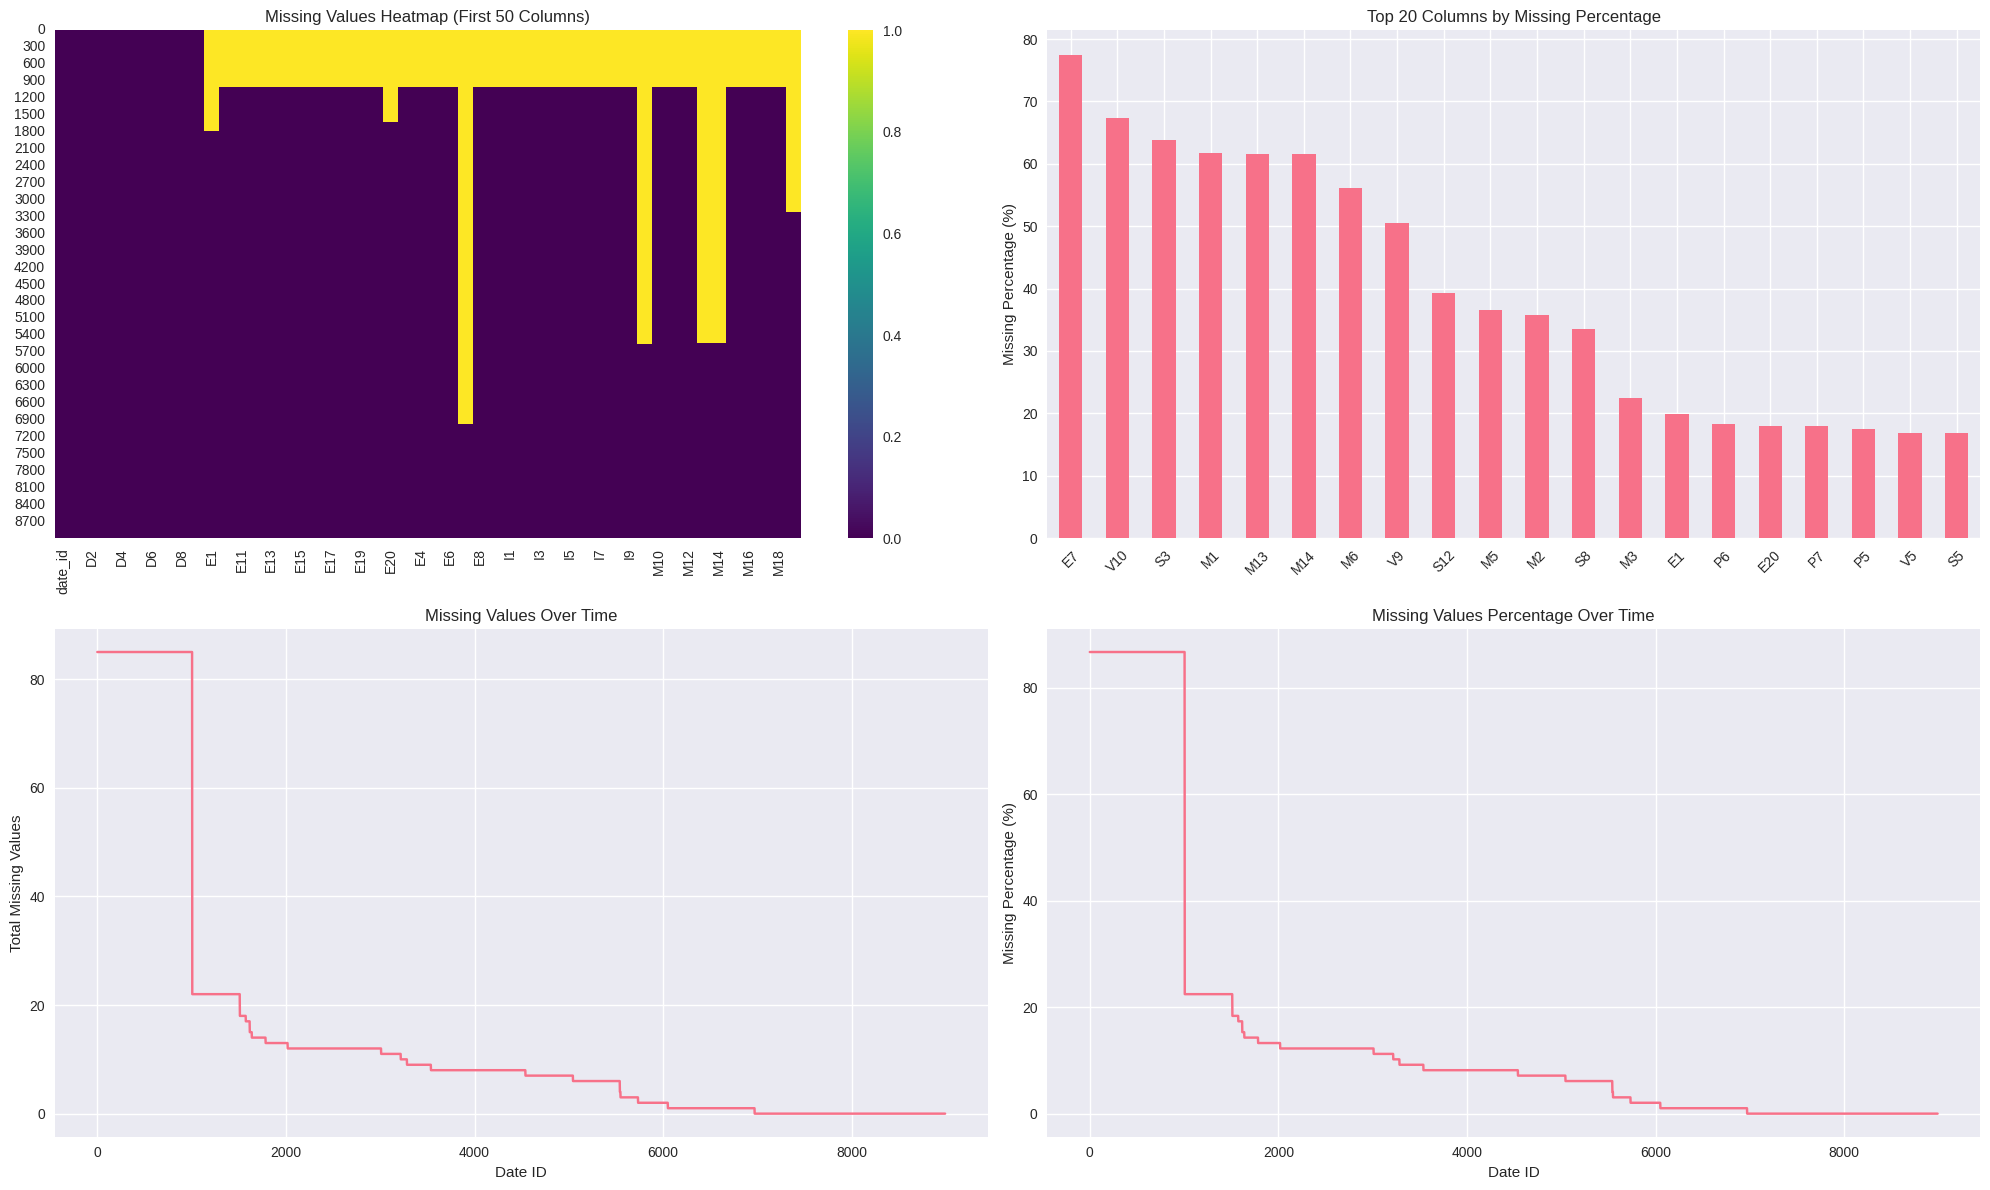

In [3]:
def analyze_missing_values(df):
    """Comprehensive missing values analysis"""
    
    print("\n🕳️ MISSING VALUES ANALYSIS")
    print("="*50)
    
    # Overall missing statistics
    total_cells = df.shape[0] * df.shape[1]
    total_missing = df.isnull().sum().sum()
    missing_percentage = (total_missing / total_cells) * 100
    
    print(f"Total missing values: {total_missing:,} ({missing_percentage:.2f}% of all cells)")
    
    # Missing values per column
    missing_data = df.isnull().sum().sort_values(ascending=False)
    missing_data = missing_data[missing_data > 0]
    
    if len(missing_data) > 0:
        missing_percent = (missing_data / len(df)) * 100
        missing_df = pd.DataFrame({
            'Missing_Count': missing_data,
            'Missing_Percentage': missing_percent
        })
        
        print(f"\n📊 Top 20 columns with missing values:")
        display(missing_df.head(20))
        
        # Visualize missing values pattern
        if len(missing_data) > 0:
            fig, axes = plt.subplots(2, 2, figsize=(20, 12))
            
            # Missing values heatmap
            missing_matrix = df.isnull()
            sns.heatmap(missing_matrix.iloc[:, :50], cbar=True, ax=axes[0,0], cmap='viridis')
            axes[0,0].set_title('Missing Values Heatmap (First 50 Columns)')
            
            # Missing values bar chart
            top_missing = missing_df.head(20)
            top_missing['Missing_Percentage'].plot(kind='bar', ax=axes[0,1])
            axes[0,1].set_title('Top 20 Columns by Missing Percentage')
            axes[0,1].set_ylabel('Missing Percentage (%)')
            plt.setp(axes[0,1].xaxis.get_majorticklabels(), rotation=45)
            
            # Missing values over time
            if 'date_id' in df.columns:
                missing_by_date = df.groupby('date_id').apply(lambda x: x.isnull().sum().sum())
                axes[1,0].plot(missing_by_date.index, missing_by_date.values)
                axes[1,0].set_title('Missing Values Over Time')
                axes[1,0].set_xlabel('Date ID')
                axes[1,0].set_ylabel('Total Missing Values')
                
                # Missing percentage by date
                missing_pct_by_date = (missing_by_date / df.shape[1]) * 100
                axes[1,1].plot(missing_pct_by_date.index, missing_pct_by_date.values)
                axes[1,1].set_title('Missing Values Percentage Over Time')
                axes[1,1].set_xlabel('Date ID')
                axes[1,1].set_ylabel('Missing Percentage (%)')
            
            plt.tight_layout()
            plt.show()
    
    return missing_data

missing_analysis = analyze_missing_values(train_df)

### 🔎 Missing Values Findings  

- **Overall Missingness:**  
  The dataset has **137,675 missing values**, which accounts for **15.63% of all cells**. This is significant enough to influence model performance and requires a careful handling strategy.  

- **Top Features with Missing Data:**  
  The following columns show the highest degree of missingness:  
  - `E7` → 77.5% missing  
  - `V10` → 67.3% missing  
  - `S3` → 63.8% missing  
  - `M1`, `M13`, `M14` → ~61.6% missing each  

  These features are candidates for **feature removal** (if deemed redundant) or **special imputation** (if domain knowledge suggests they hold critical information).  

- **Moderately Affected Features (30–50% missing):**  
  Columns like `M6`, `V9`, and `S12` fall into this range. They might still provide signal after thoughtful imputation, but could also add noise if handled poorly.  

- **Lightly Affected Features (<25% missing):**  
  Columns like `E1`, `P6`, `E20`, `P7`, `P5`, `V5`, and `S5` have missing rates between 16–22%. These are typically worth keeping, provided we apply a robust imputation strategy (median, forward-fill, or predictive imputation).  

# 3. FEATURE CATEGORIZATION AND ANALYSIS

In [4]:
def categorize_features(df):
    """Categorize features based on their prefixes"""
    
    print("\n🏷️ FEATURE CATEGORIZATION")
    print("="*50)
    
    feature_categories = {}
    
    # Define feature categories based on prefixes
    categories = {
        'Market_Dynamics': 'M',
        'Macro_Economic': 'E',
        'Interest_Rate': 'I',
        'Price_Valuation': 'P',
        'Volatility': 'V',
        'Sentiment': 'S',
        'Momentum': 'MOM',
        'Dummy_Binary': 'D'
    }
    
    # Categorize features
    for category, prefix in categories.items():
        if prefix == 'MOM':
            feature_categories[category] = [col for col in df.columns if col.startswith(prefix)]
        else:
            feature_categories[category] = [col for col in df.columns if col.startswith(prefix) and not col.startswith('MOM')]
    
    # Special columns
    special_cols = ['date_id', 'forward_returns', 'risk_free_rate', 'market_forward_excess_returns']
    feature_categories['Special'] = [col for col in special_cols if col in df.columns]
    
    # Display categorization
    total_features = 0
    for category, features in feature_categories.items():
        print(f"📊 {category}: {len(features)} features")
        total_features += len(features)
    
    print(f"\n📈 Total categorized features: {total_features}")
    print(f"📈 Total columns in dataset: {df.shape[1]}")
    
    return feature_categories

feature_categories = categorize_features(train_df)


🏷️ FEATURE CATEGORIZATION
📊 Market_Dynamics: 18 features
📊 Macro_Economic: 20 features
📊 Interest_Rate: 9 features
📊 Price_Valuation: 13 features
📊 Volatility: 13 features
📊 Sentiment: 12 features
📊 Momentum: 0 features
📊 Dummy_Binary: 9 features
📊 Special: 4 features

📈 Total categorized features: 98
📈 Total columns in dataset: 98


### 📊 Categorization Results  

All **98 dataset features** were successfully mapped into domain-specific categories:  

- **Market Dynamics (18 features):** Direct market indicators (spreads, liquidity, market internals).  
- **Macro-Economic (20 features):** Broad economic signals — employment, inflation, growth proxies.  
- **Interest Rate (9 features):** Yield curve and rate-sensitive variables.  
- **Price Valuation (13 features):** Relative asset pricing & valuation ratios.  
- **Volatility (13 features):** Realized/implied volatility measures, uncertainty indicators.  
- **Sentiment (12 features):** Investor surveys, behavioral/psychological sentiment indicators.  
- **Momentum (0 features):** None explicitly provided — could suggest Hull Tactical encodes these trends elsewhere.  
- **Dummy/Binary (9 features):** Structural flags and categorical encodings.  
- **Special (4 features):** Competition-specific columns: `date_id`, `forward_returns`, `risk_free_rate`, `market_forward_excess_returns`.  

📌 **Key Insights:**  
1. The dataset is **well-balanced across multiple financial dimensions**, with a healthy representation of macro, sentiment, and volatility.  
2. **No momentum features** → This is unusual in financial modeling, where momentum is a strong predictive factor. It will be interesting to see whether other feature groups indirectly capture momentum.  
3. **Special columns** clearly define the prediction target (`forward_returns`) and evaluation framework (market excess returns, risk-free rate).   


# 4. TARGET VARIABLE ANALYSIS


🎯 TARGET VARIABLE ANALYSIS

📊 FORWARD_RETURNS Statistics:
Count: 8,990
Mean: 0.000469
Std: 0.010551
Min: -0.039754
25%: -0.004324
50%: 0.000659
75%: 0.005900
Max: 0.040661
Skewness: -0.176202
Kurtosis: 2.192690
Jarque-Bera test p-value: 0.000000 (Not Normal)

📊 RISK_FREE_RATE Statistics:
Count: 8,990
Mean: 0.000107
Std: 0.000088
Min: -0.000004
25%: 0.000008
50%: 0.000095
75%: 0.000193
Max: 0.000317
Skewness: 0.218248
Kurtosis: -1.267292
Jarque-Bera test p-value: 0.000000 (Not Normal)

📊 MARKET_FORWARD_EXCESS_RETURNS Statistics:
Count: 8,990
Mean: 0.000051
Std: 0.010568
Min: -0.040582
25%: -0.004759
50%: 0.000252
75%: 0.005479
Max: 0.040551
Skewness: -0.177948
Kurtosis: 2.238481
Jarque-Bera test p-value: 0.000000 (Not Normal)


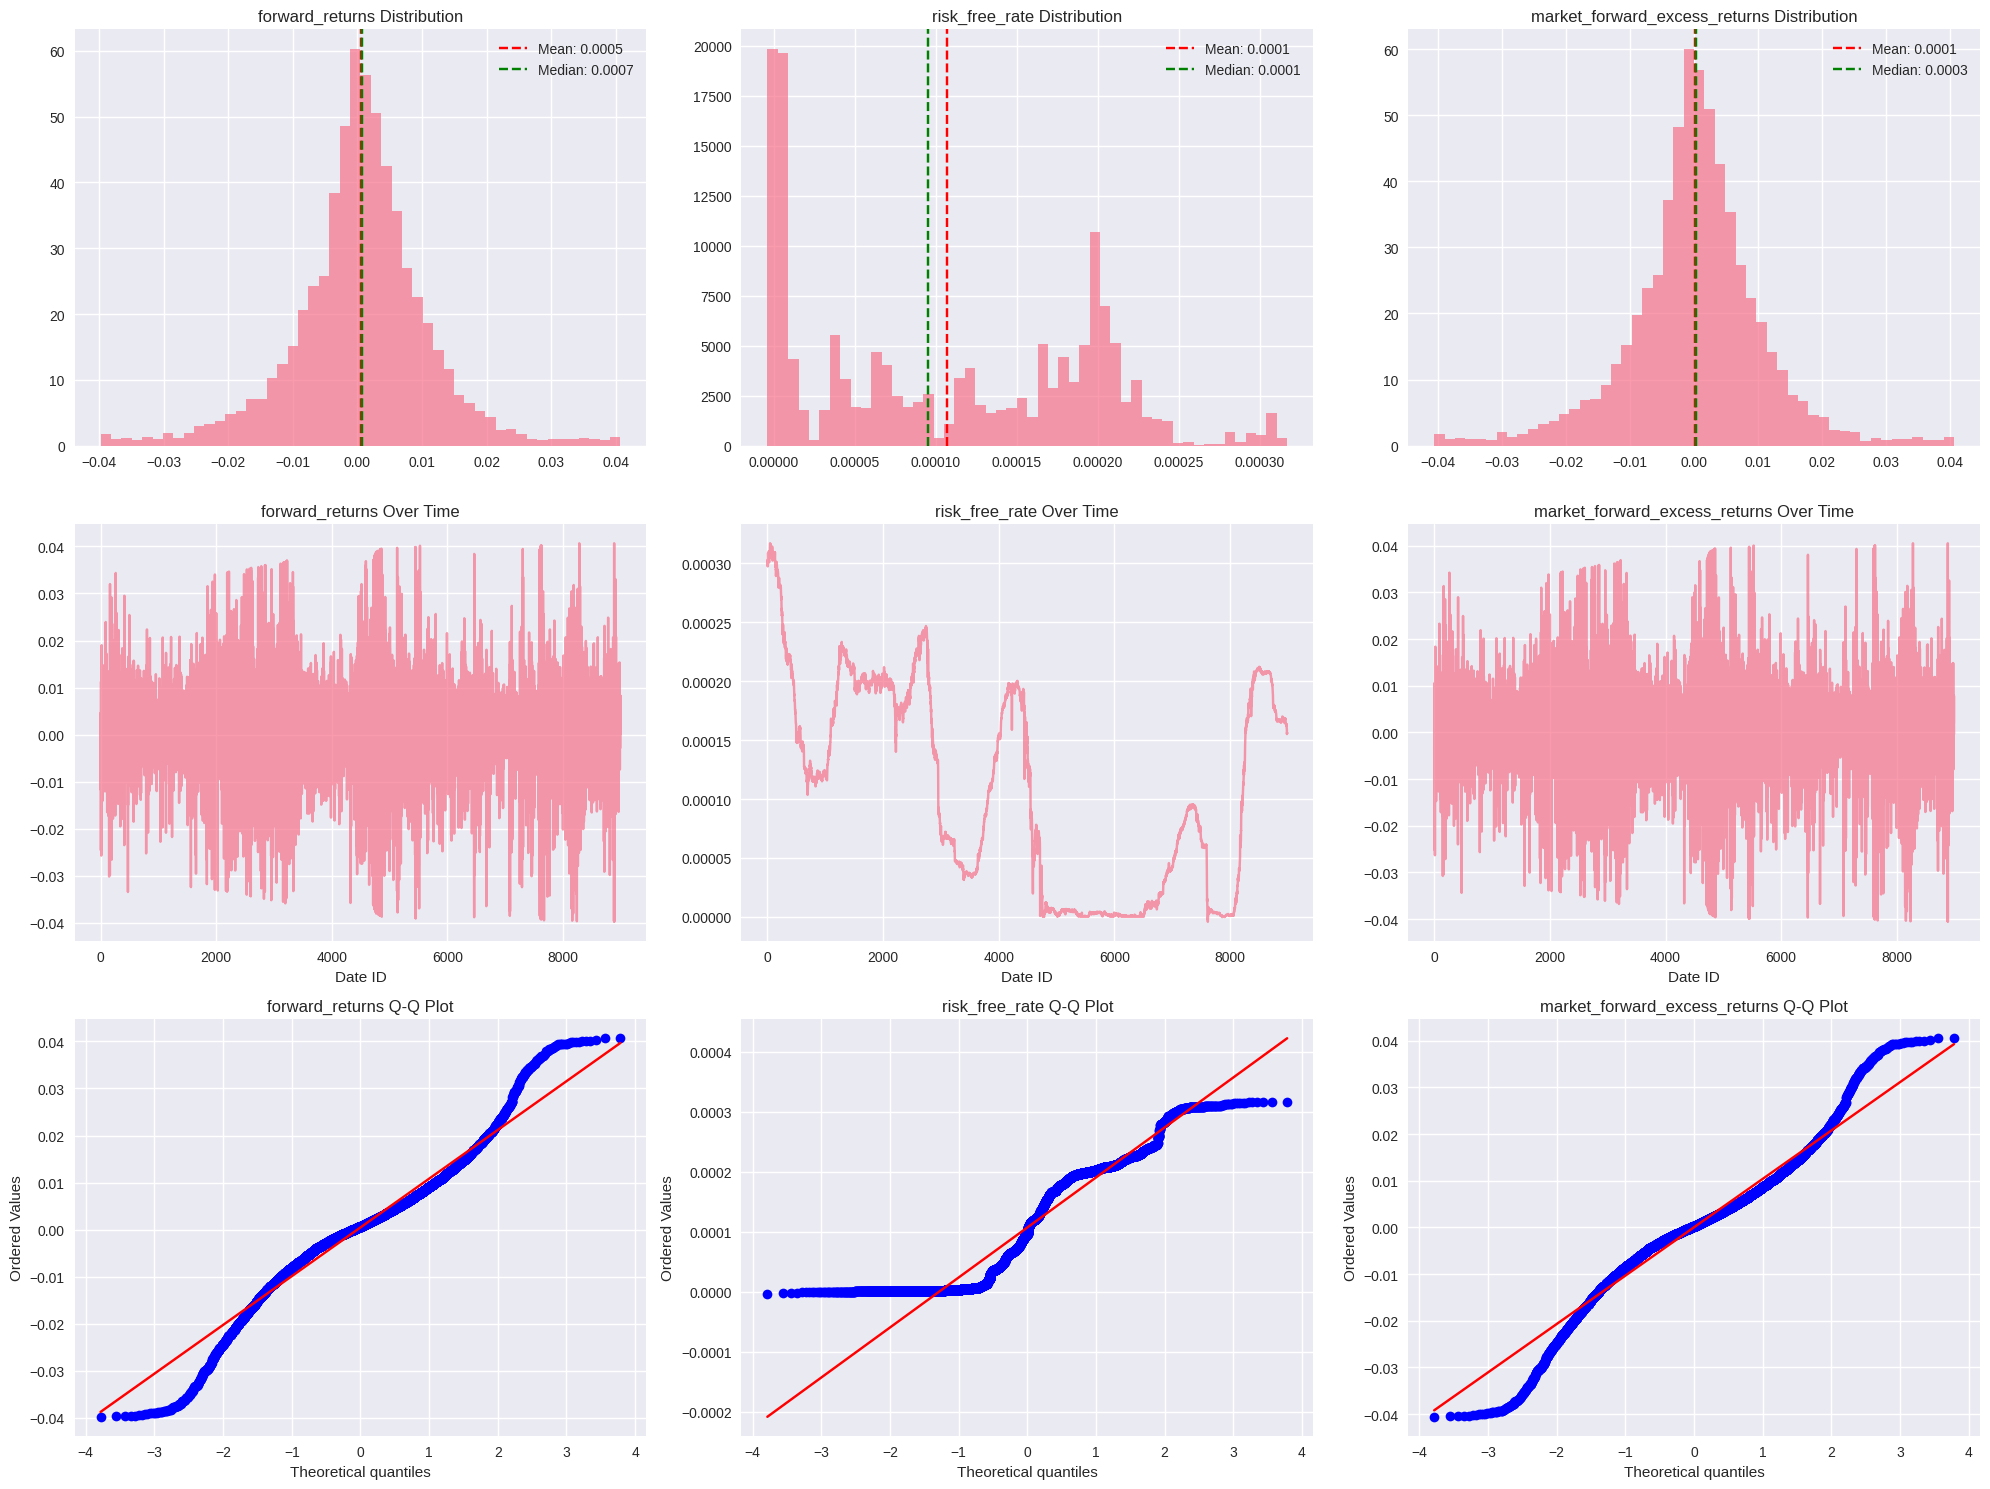

In [5]:
def analyze_target_variable(df):
    """Comprehensive analysis of target variables"""
    
    print("\n🎯 TARGET VARIABLE ANALYSIS")
    print("="*50)
    
    target_cols = ['forward_returns', 'risk_free_rate', 'market_forward_excess_returns']
    target_cols = [col for col in target_cols if col in df.columns]
    
    fig, axes = plt.subplots(3, len(target_cols), figsize=(20, 15))
    if len(target_cols) == 1:
        axes = axes.reshape(-1, 1)
    
    for i, col in enumerate(target_cols):
        if col in df.columns:
            data = df[col].dropna()
            
            print(f"\n📊 {col.upper()} Statistics:")
            print(f"Count: {len(data):,}")
            print(f"Mean: {data.mean():.6f}")
            print(f"Std: {data.std():.6f}")
            print(f"Min: {data.min():.6f}")
            print(f"25%: {data.quantile(0.25):.6f}")
            print(f"50%: {data.median():.6f}")
            print(f"75%: {data.quantile(0.75):.6f}")
            print(f"Max: {data.max():.6f}")
            print(f"Skewness: {data.skew():.6f}")
            print(f"Kurtosis: {data.kurtosis():.6f}")
            
            # Distribution plot
            axes[0, i].hist(data, bins=50, alpha=0.7, density=True)
            axes[0, i].axvline(data.mean(), color='red', linestyle='--', label=f'Mean: {data.mean():.4f}')
            axes[0, i].axvline(data.median(), color='green', linestyle='--', label=f'Median: {data.median():.4f}')
            axes[0, i].set_title(f'{col} Distribution')
            axes[0, i].legend()
            
            # Time series plot
            if 'date_id' in df.columns:
                axes[1, i].plot(df['date_id'], df[col], alpha=0.7)
                axes[1, i].set_title(f'{col} Over Time')
                axes[1, i].set_xlabel('Date ID')
            
            # Q-Q plot for normality check
            stats.probplot(data, dist="norm", plot=axes[2, i])
            axes[2, i].set_title(f'{col} Q-Q Plot')
            
            # Statistical tests
            jb_stat, jb_pvalue = jarque_bera(data)
            print(f"Jarque-Bera test p-value: {jb_pvalue:.6f} ({'Normal' if jb_pvalue > 0.05 else 'Not Normal'})")
    
    plt.tight_layout()
    plt.show()
    
    return target_cols

target_analysis = analyze_target_variable(train_df)

### 🎯 Target Variable Analysis  

We focus on the three key target-related columns in this dataset:  

1. **forward_returns** → The next-day S&P 500 returns (our prediction target).  
2. **risk_free_rate** → The federal funds rate, representing the baseline cost of capital.  
3. **market_forward_excess_returns** → Returns relative to long-term expectations (adjusted via rolling mean & MAD winsorization).  

#### Key Findings:  

- **Forward Returns**  
  - Distribution is centered near zero (mean ≈ 0.00047), as expected for daily returns.  
  - Standard deviation ≈ 1%, showing typical daily market volatility.  
  - Slight negative skewness (-0.18), meaning downside moves can be a bit heavier.  
  - Kurtosis ≈ 2.19 → lighter tails compared to a normal distribution.  
  - **Not normally distributed** (Jarque-Bera p < 0.05).  

- **Risk-Free Rate**  
  - Very small daily changes (mean ≈ 0.0001).  
  - Negligible volatility relative to returns.  
  - Negative kurtosis (-1.27) indicates thinner tails → distribution more “flat” than normal.  
  - Also **not normal**, though deviations are less impactful.  

- **Market Forward Excess Returns**  
  - Similar distribution to `forward_returns` (mean ≈ 0.00005).  
  - Std ≈ 1%, confirming it’s just a detrended view of raw returns.  
  - Slight negative skewness (-0.18) and kurtosis ≈ 2.24.  
  - **Not normal** by statistical tests.  

#### Visual Takeaways:  
- **Histograms** show heavy concentration around zero, but tails deviate from Gaussian.  
- **Time-series plots** highlight volatility clustering (periods of calm vs turbulence).  
- **Q-Q plots** confirm fat tails, a common feature in financial time series.  

📌 **Implication for Modeling:**  
Linear models assuming normality may struggle. We should consider:  
- Robust loss functions (Huber, quantile regression).  
- Non-linear models (tree-based, neural nets).  
- Feature engineering around volatility and tail risk.  


# 5. FEATURE DISTRIBUTION ANALYSIS


📊 FEATURE DISTRIBUTION ANALYSIS

🔍 Analyzing Market_Dynamics features (18 total)


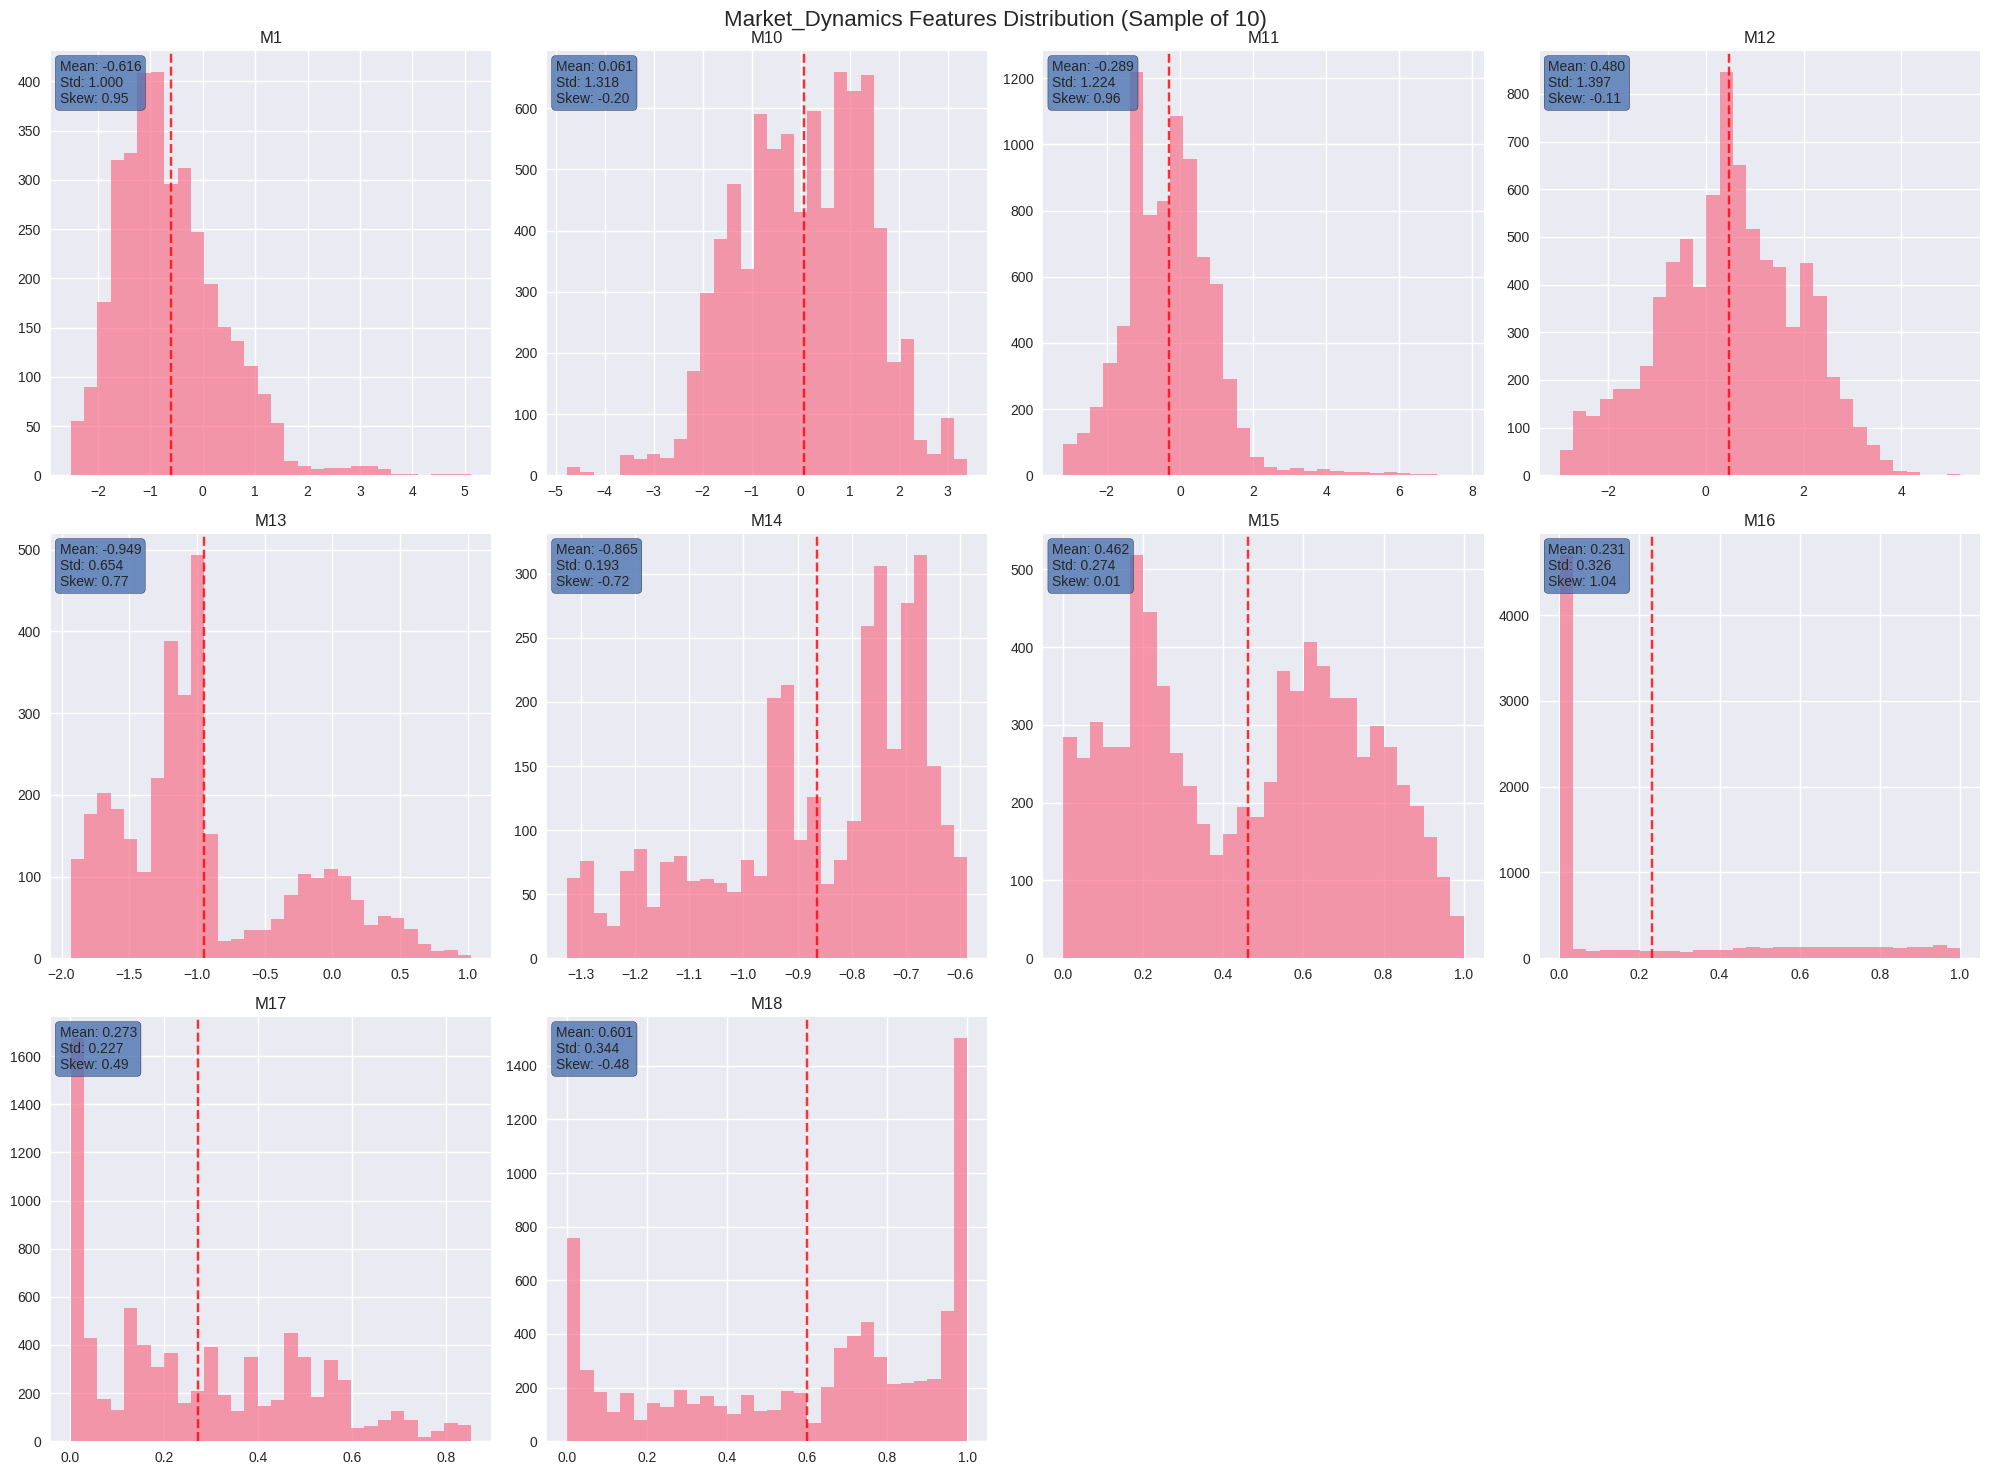


🔍 Analyzing Macro_Economic features (20 total)


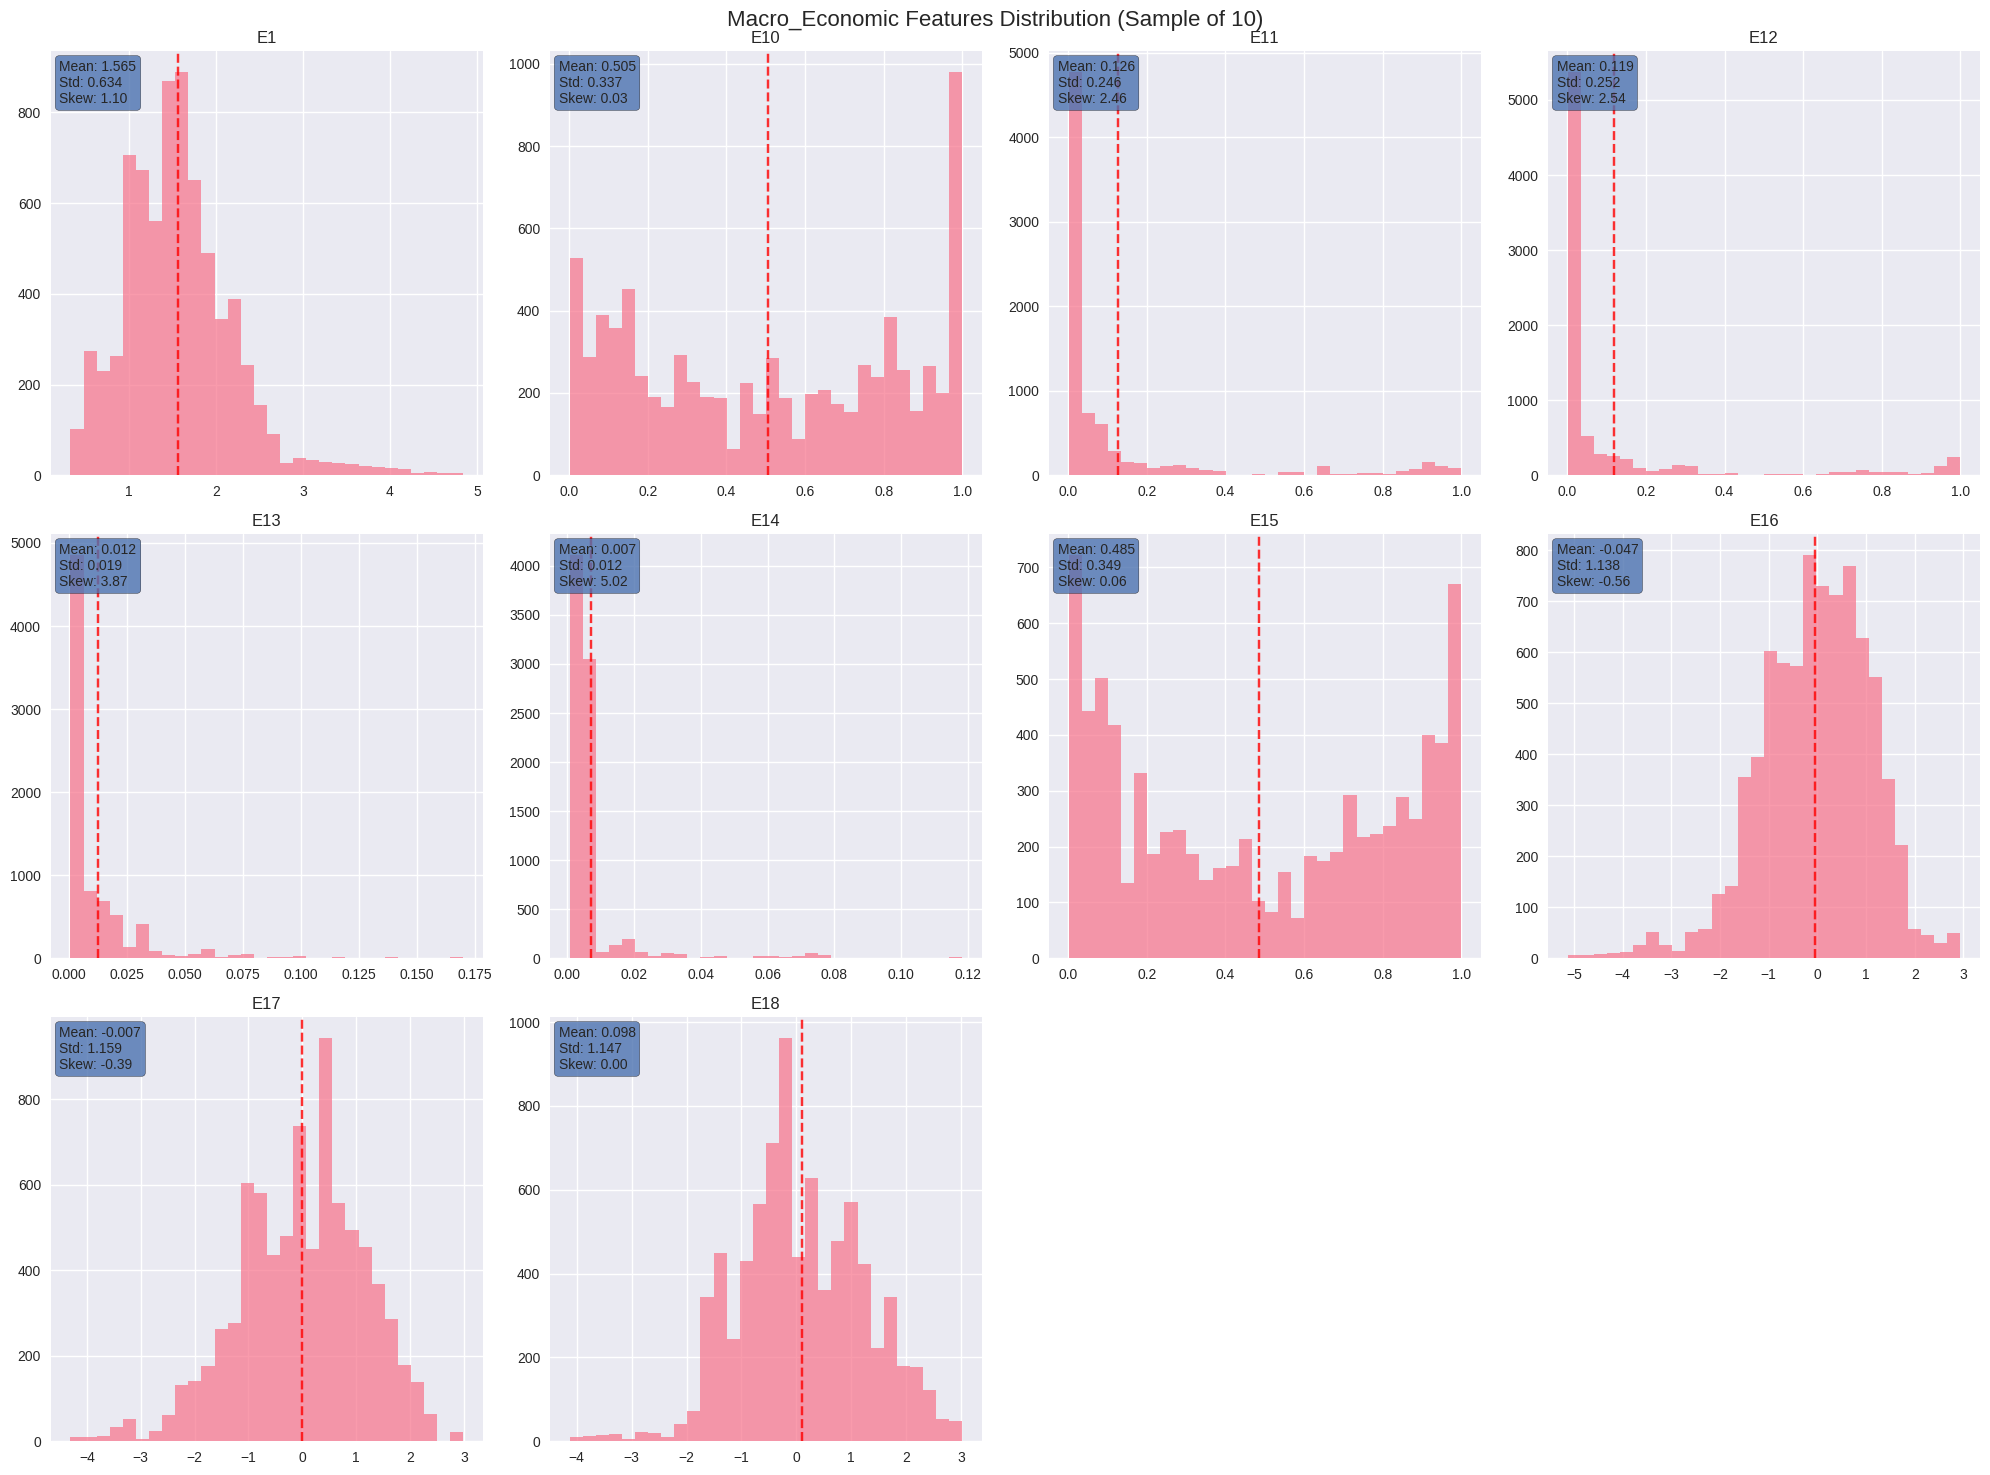


🔍 Analyzing Interest_Rate features (9 total)


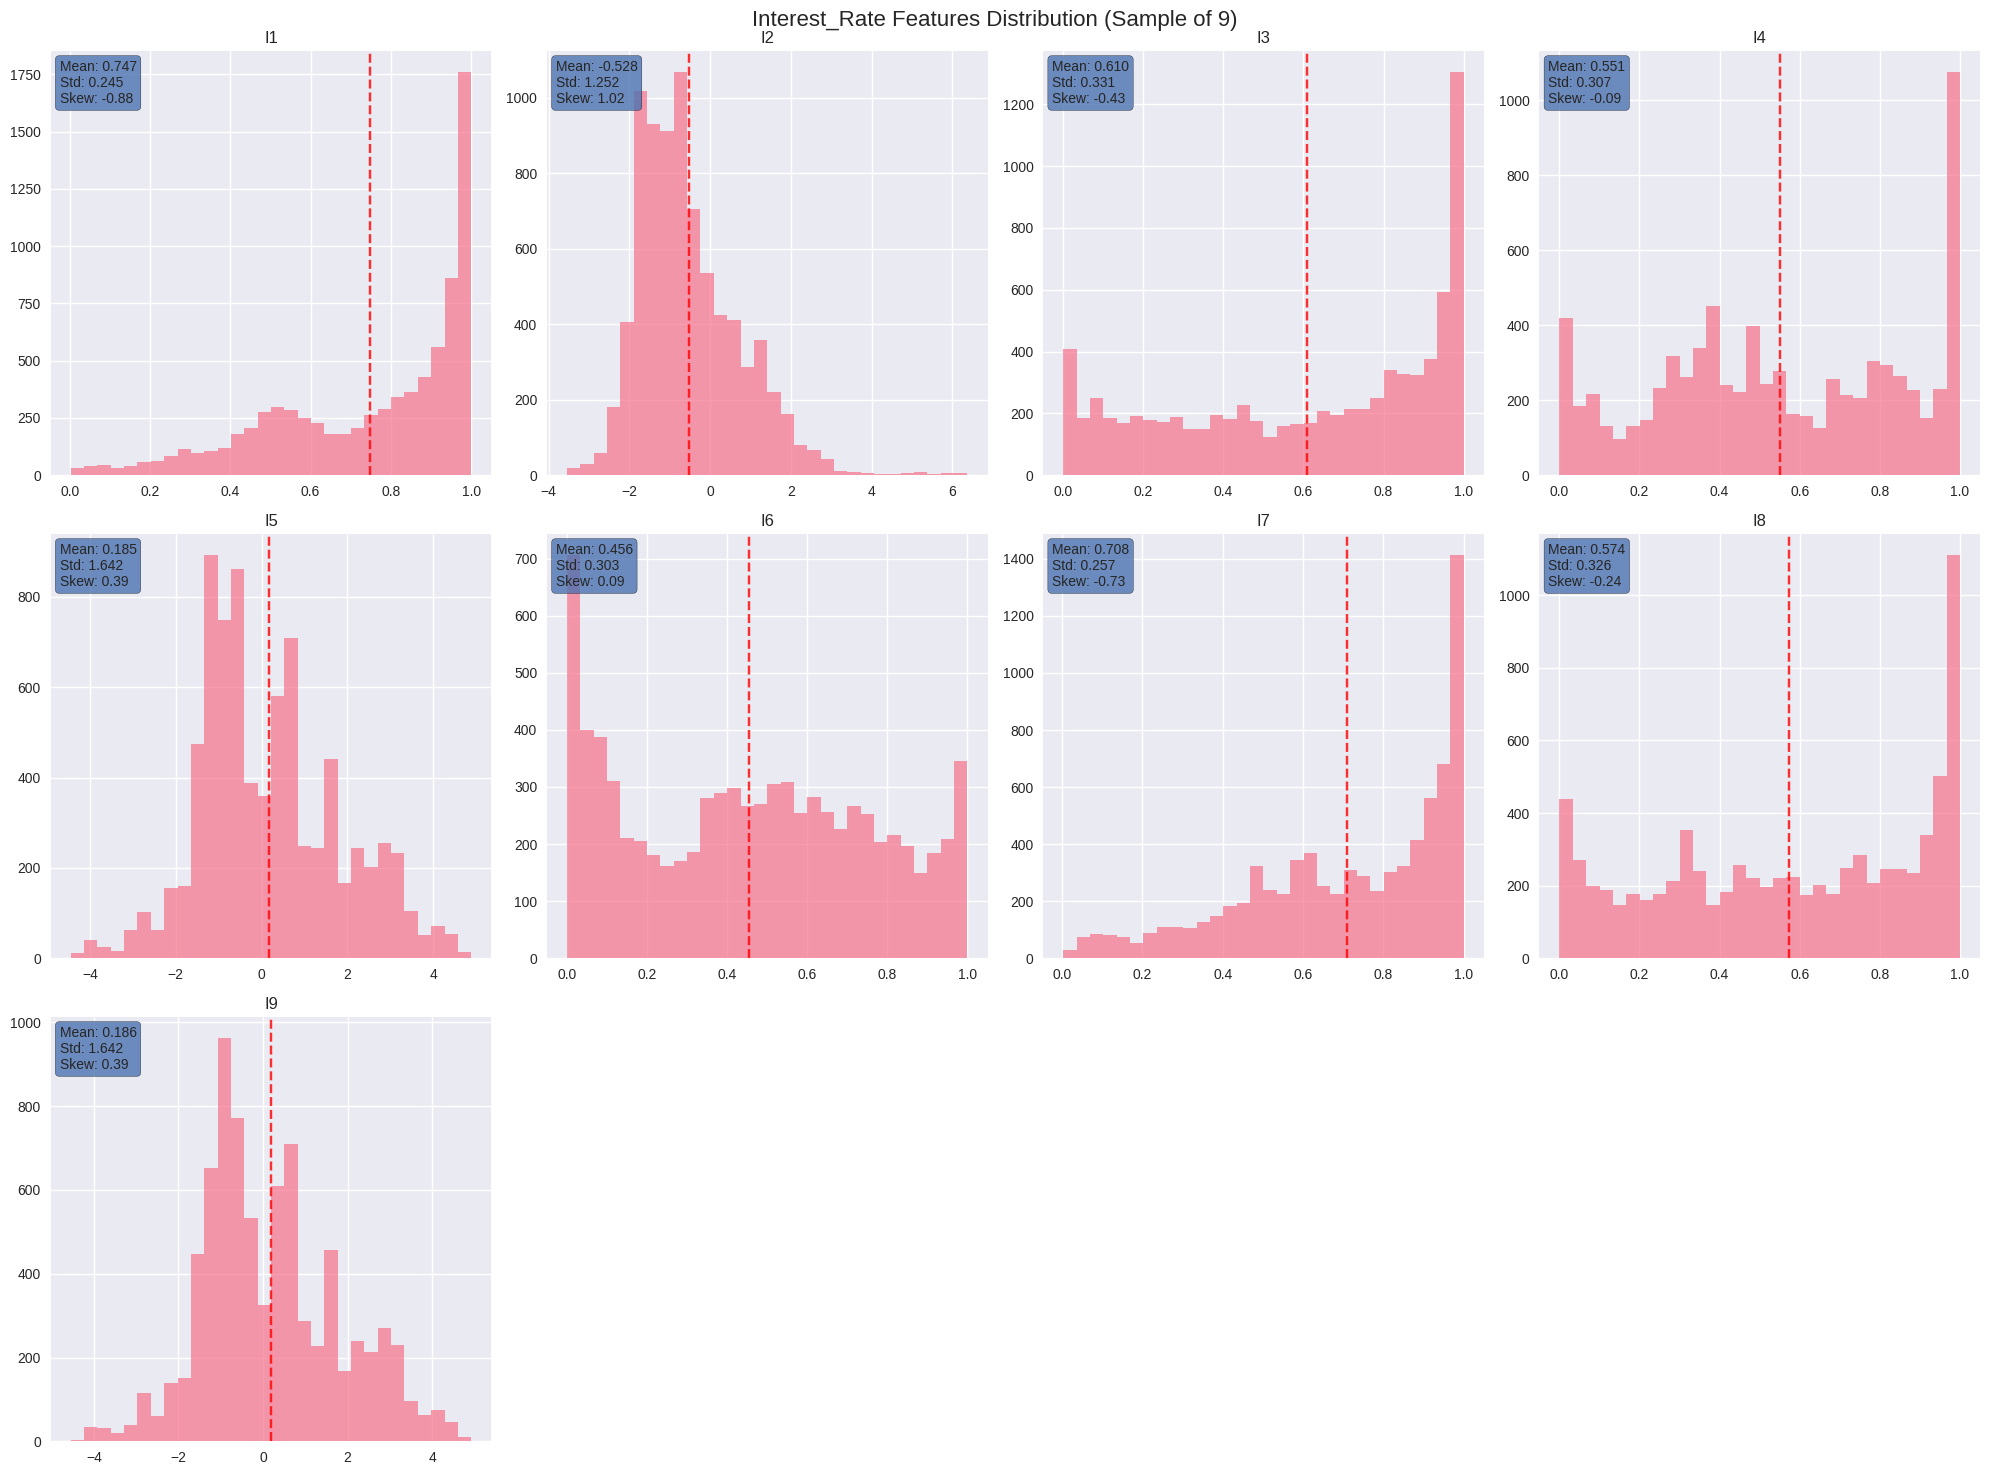


🔍 Analyzing Price_Valuation features (13 total)


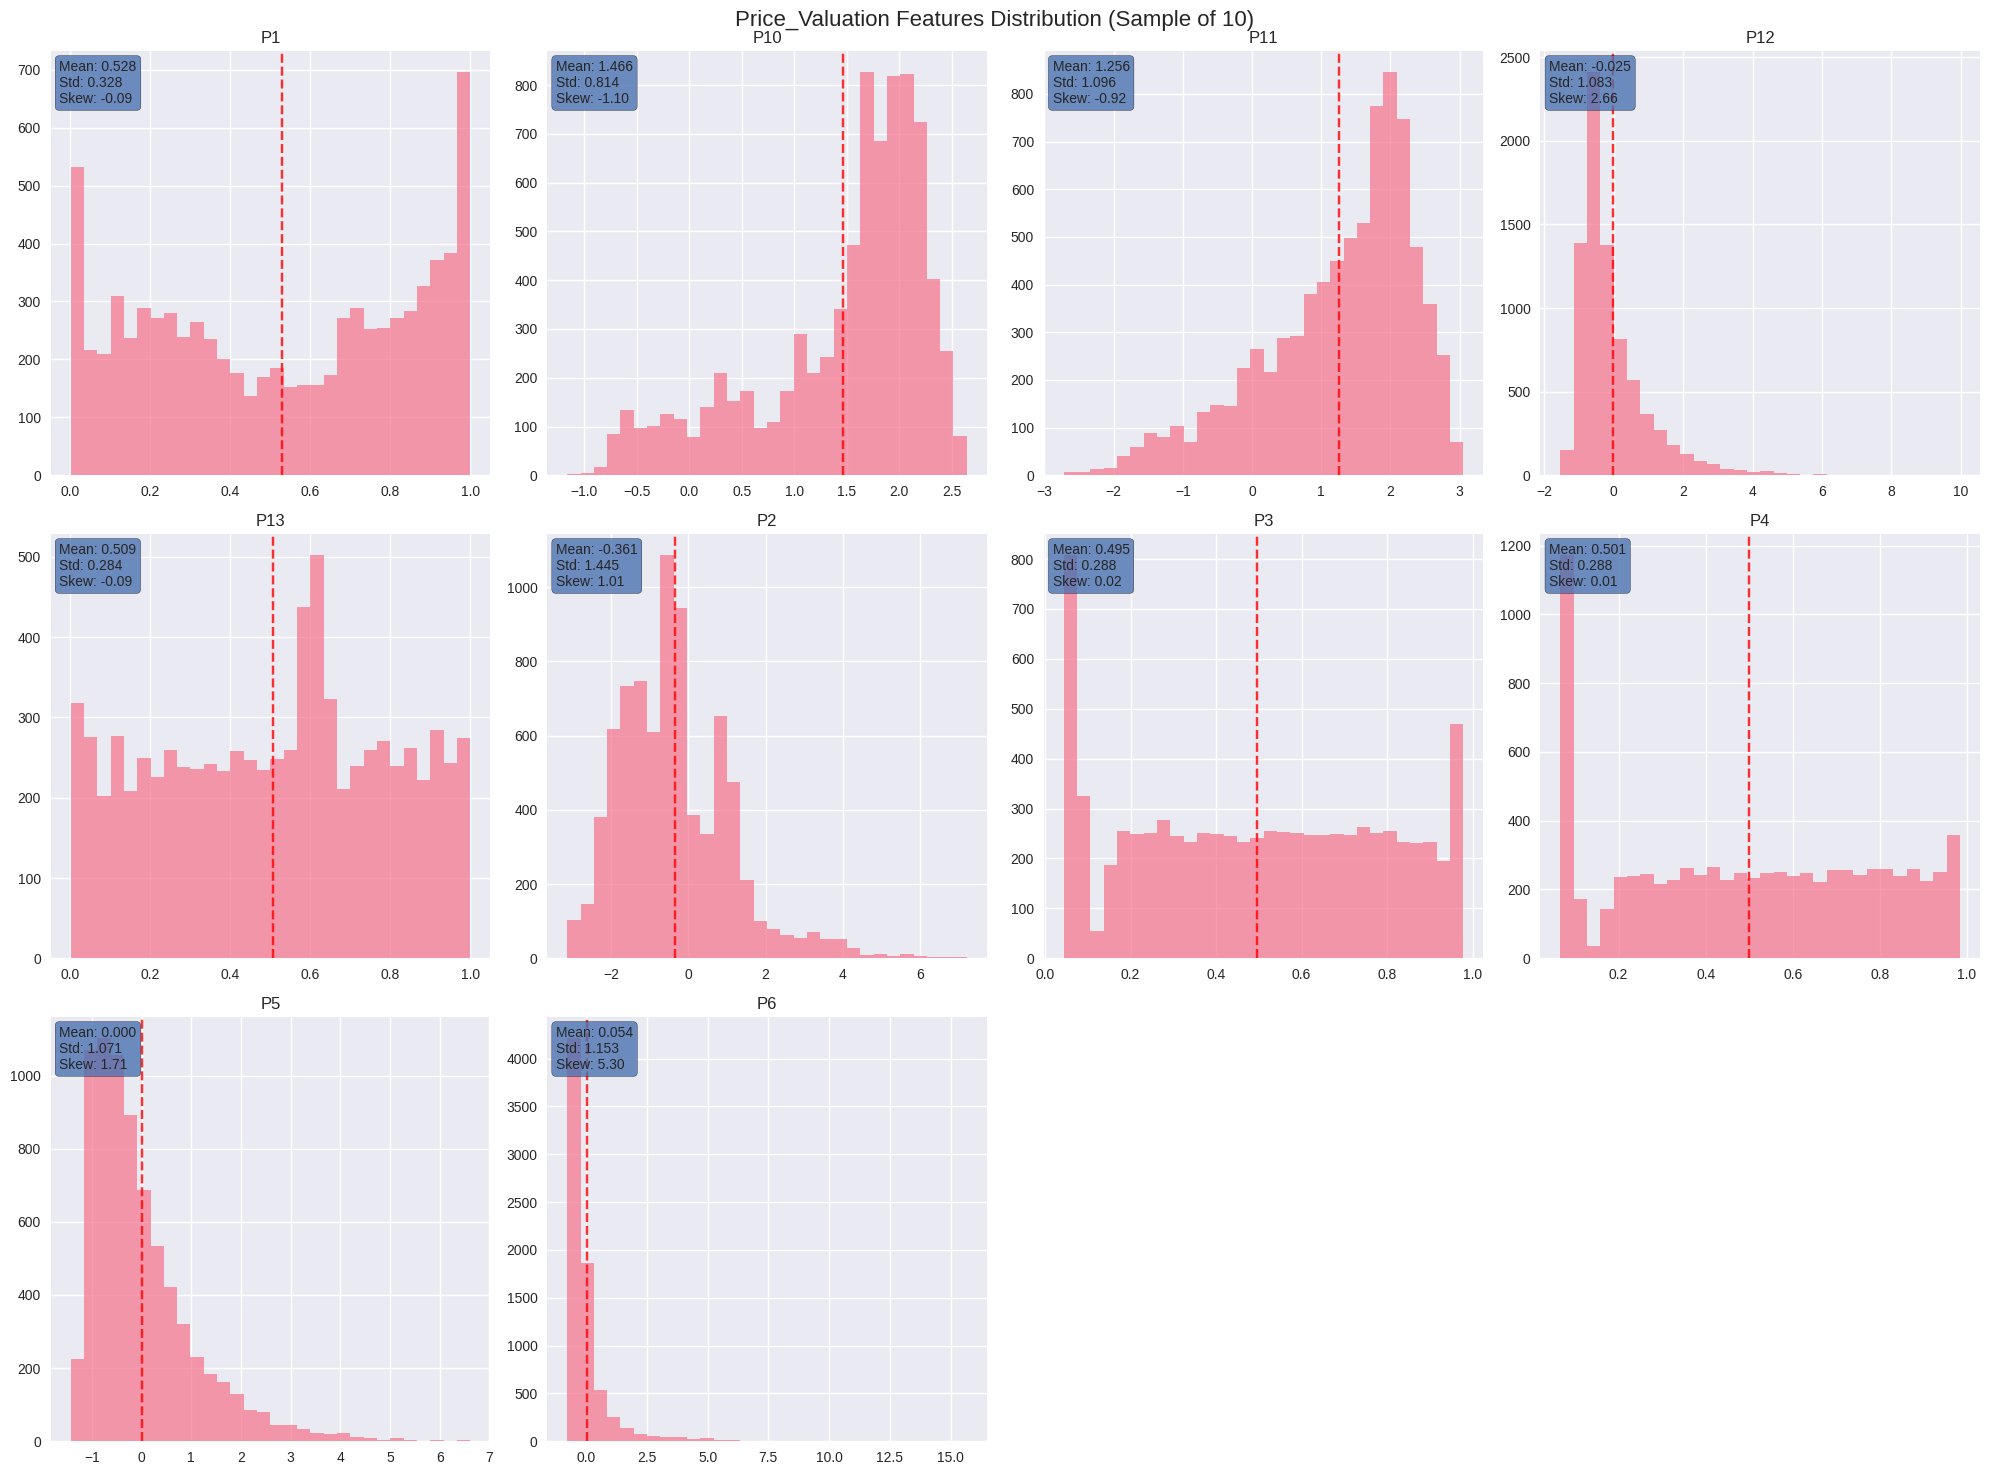


🔍 Analyzing Volatility features (13 total)


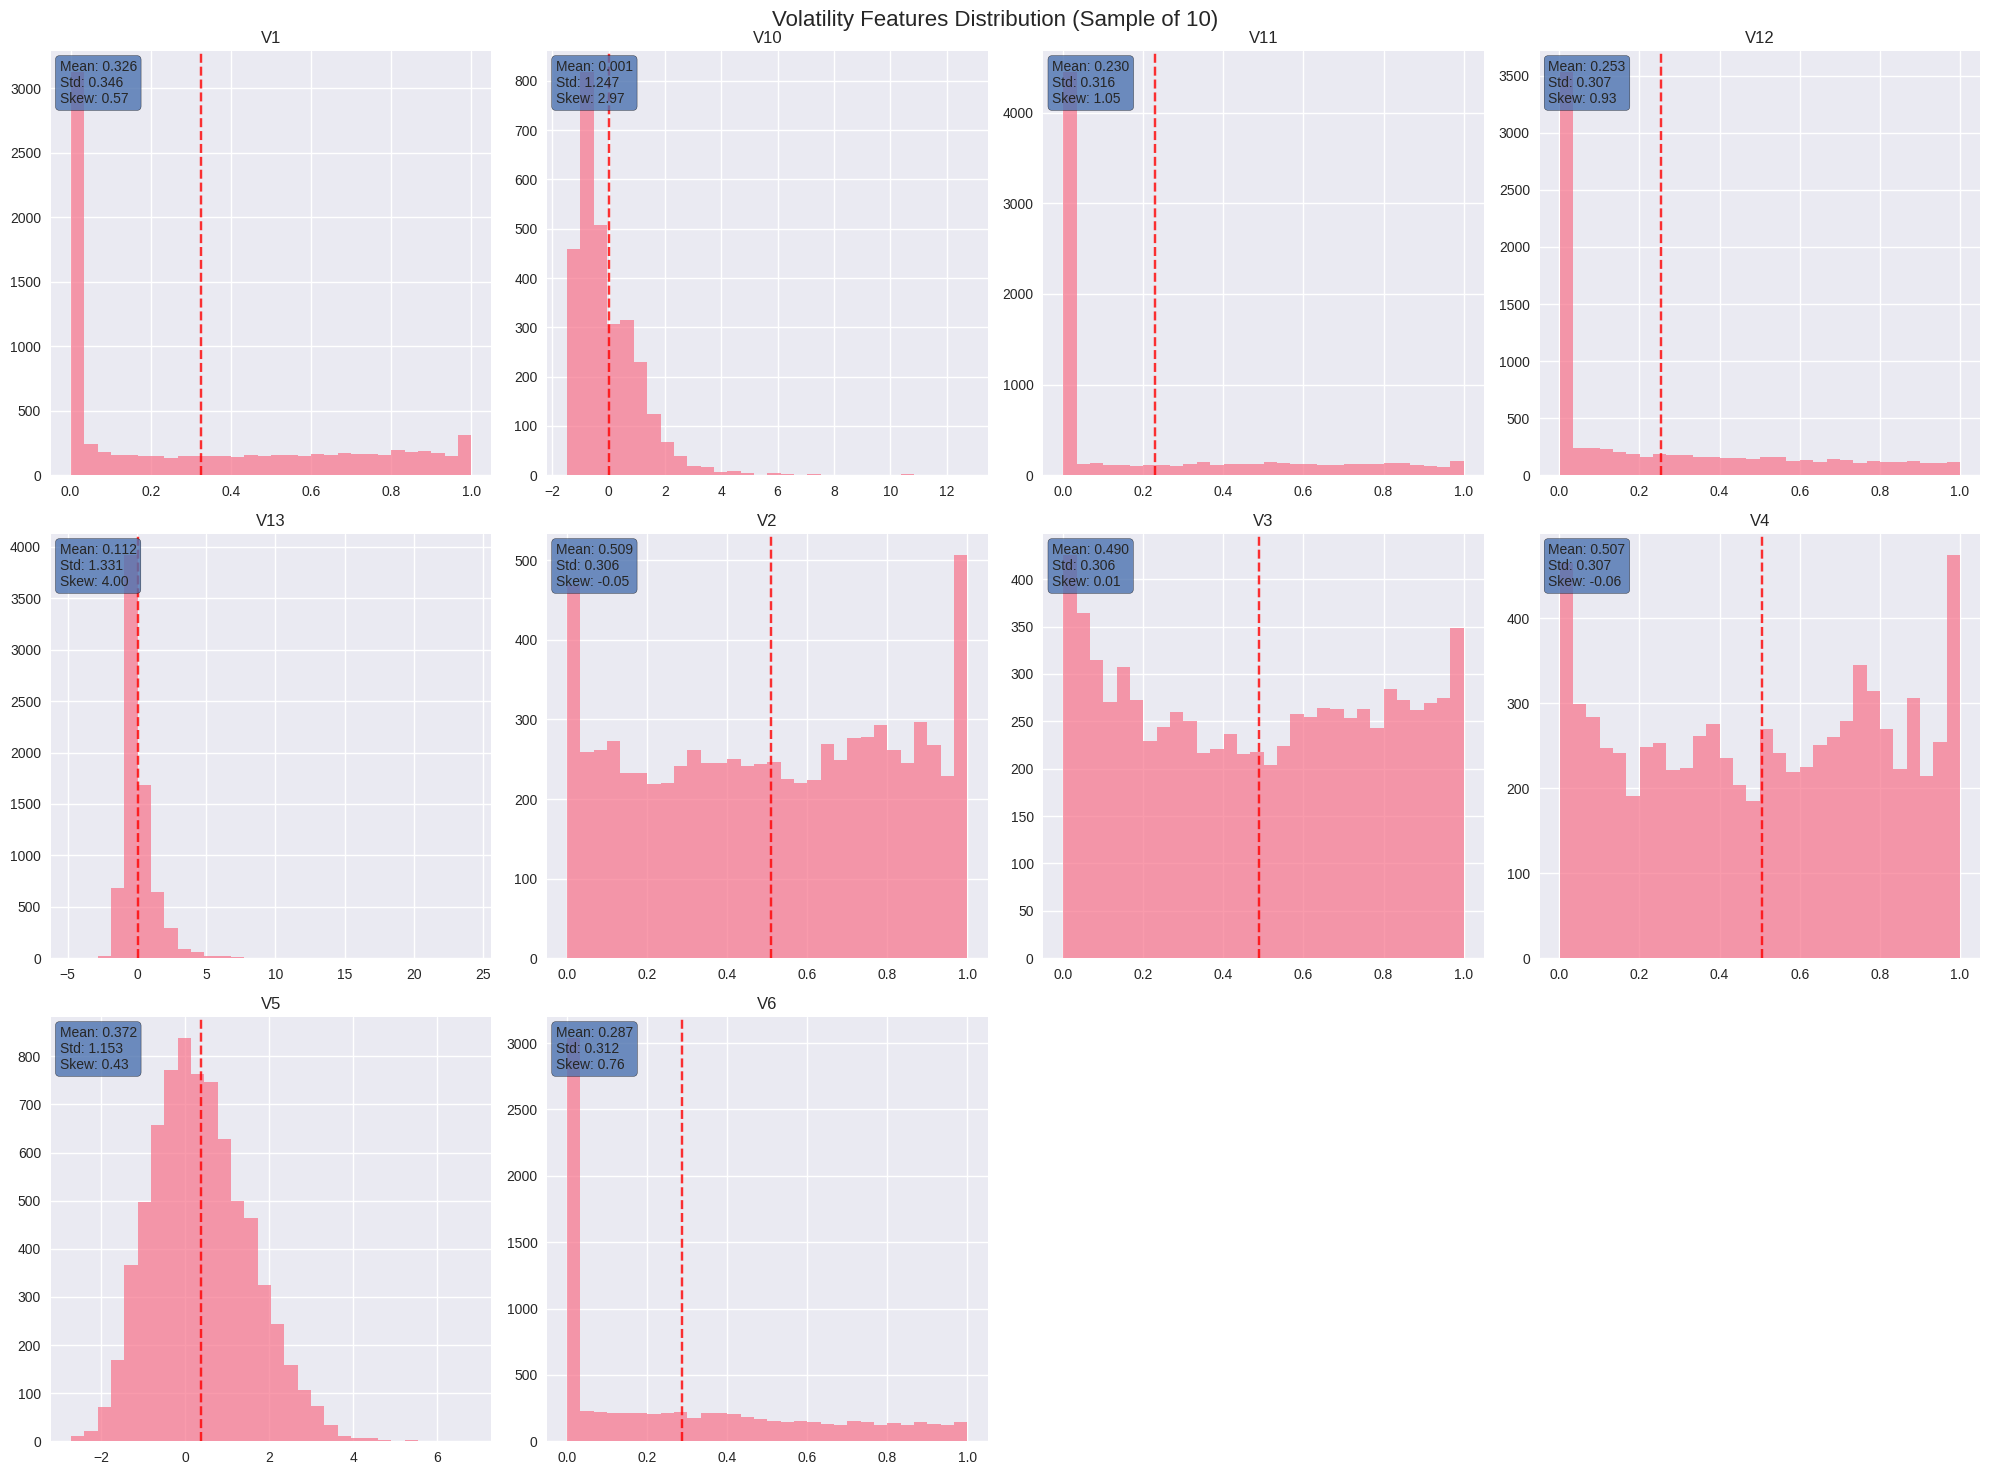


🔍 Analyzing Sentiment features (12 total)


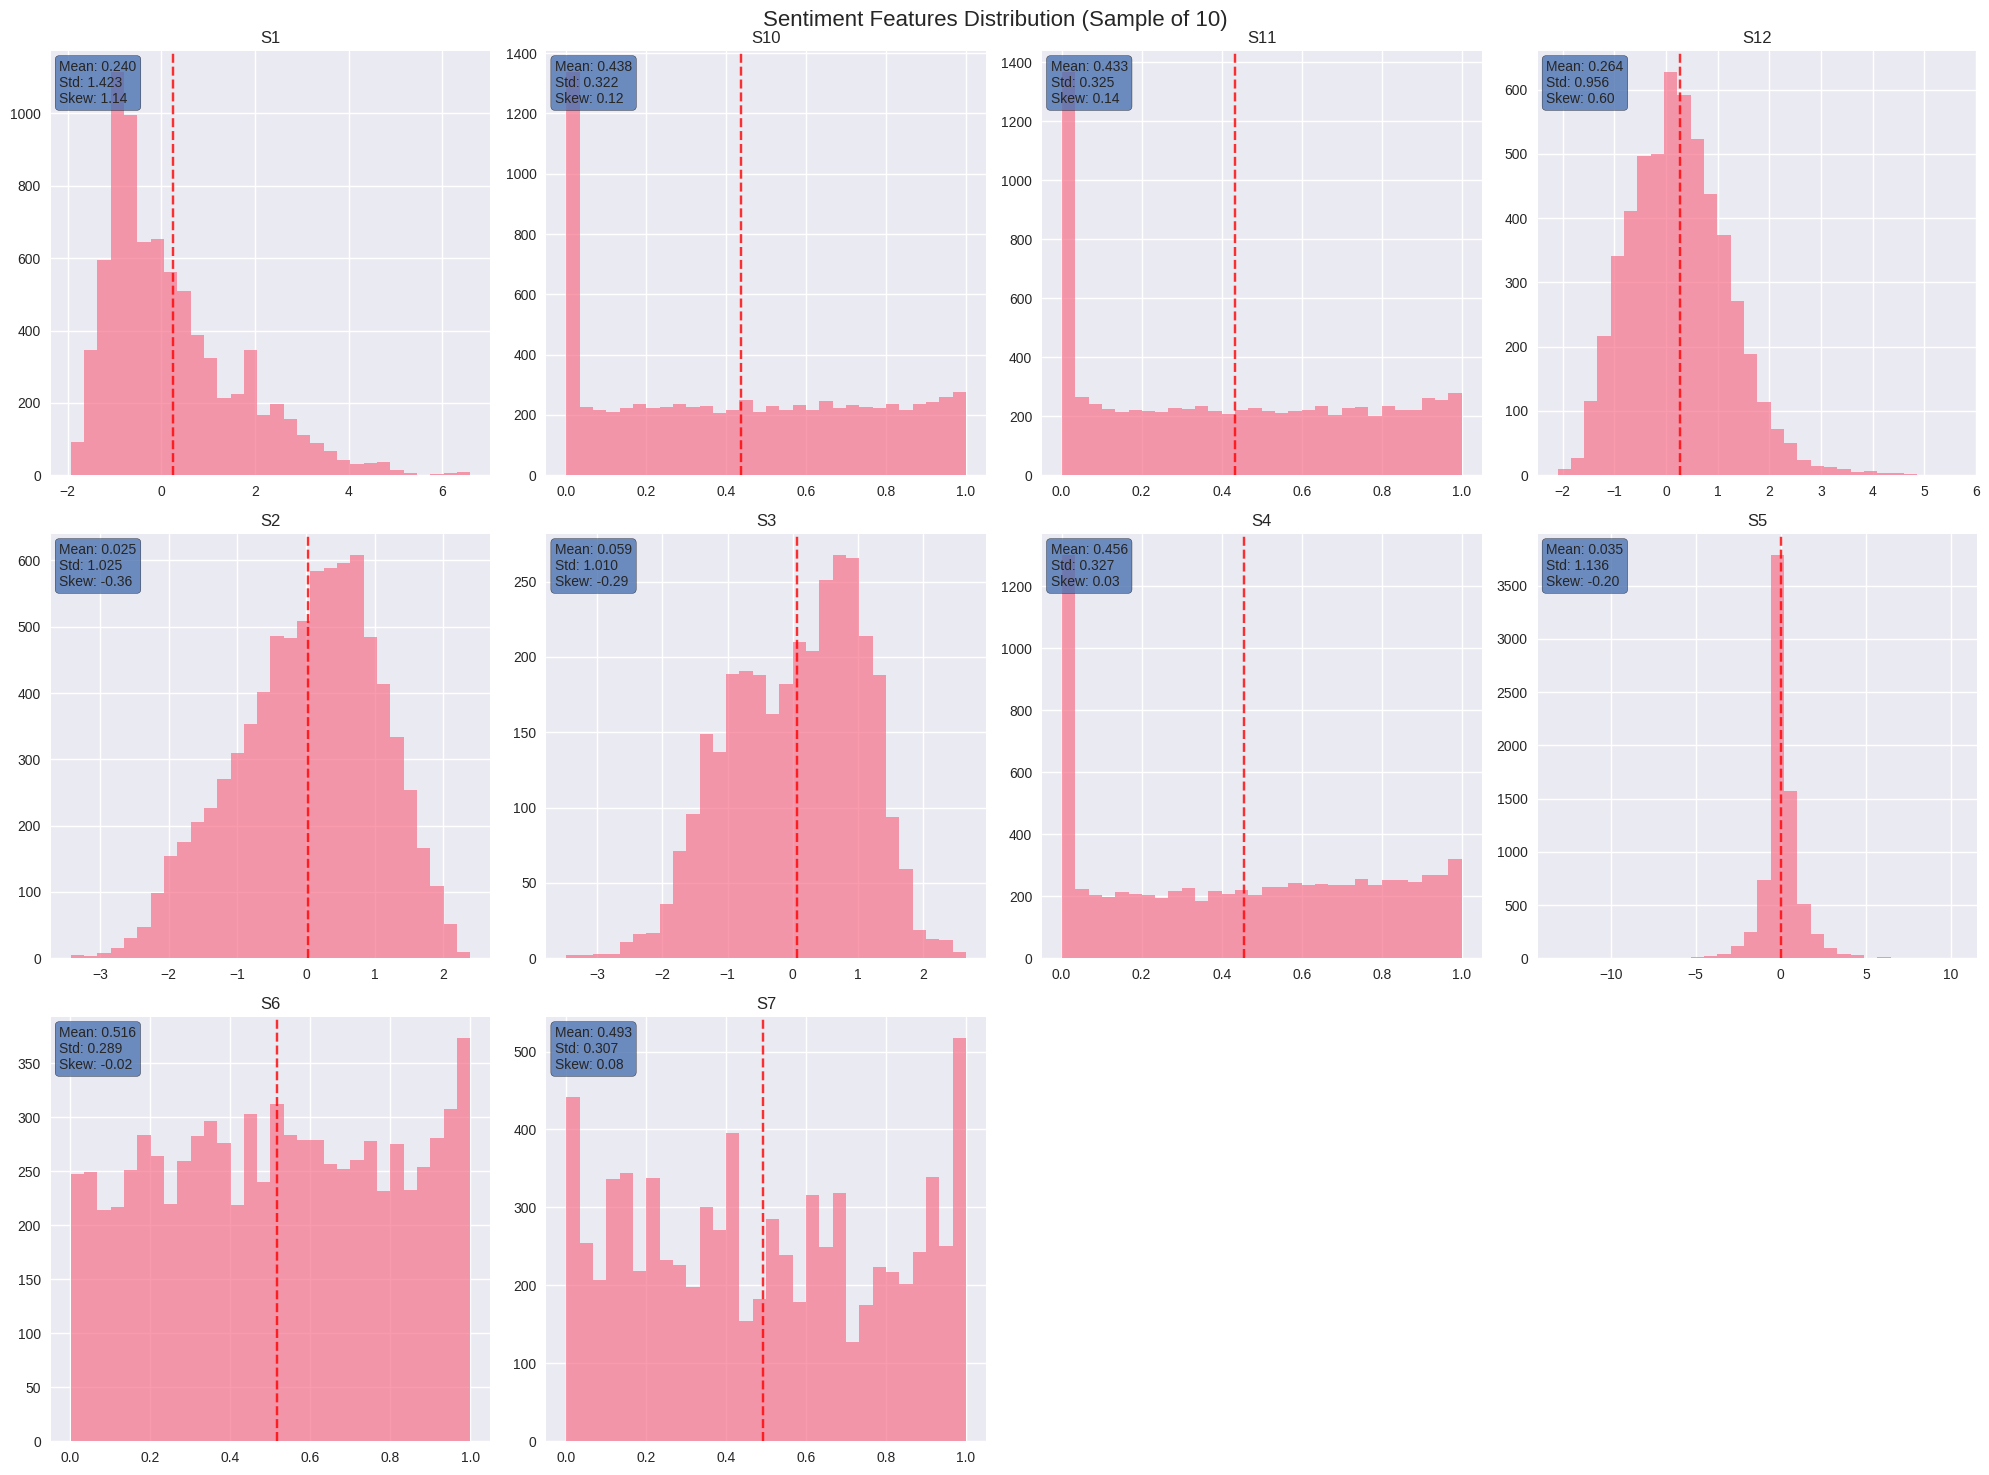


🔍 Analyzing Dummy_Binary features (9 total)


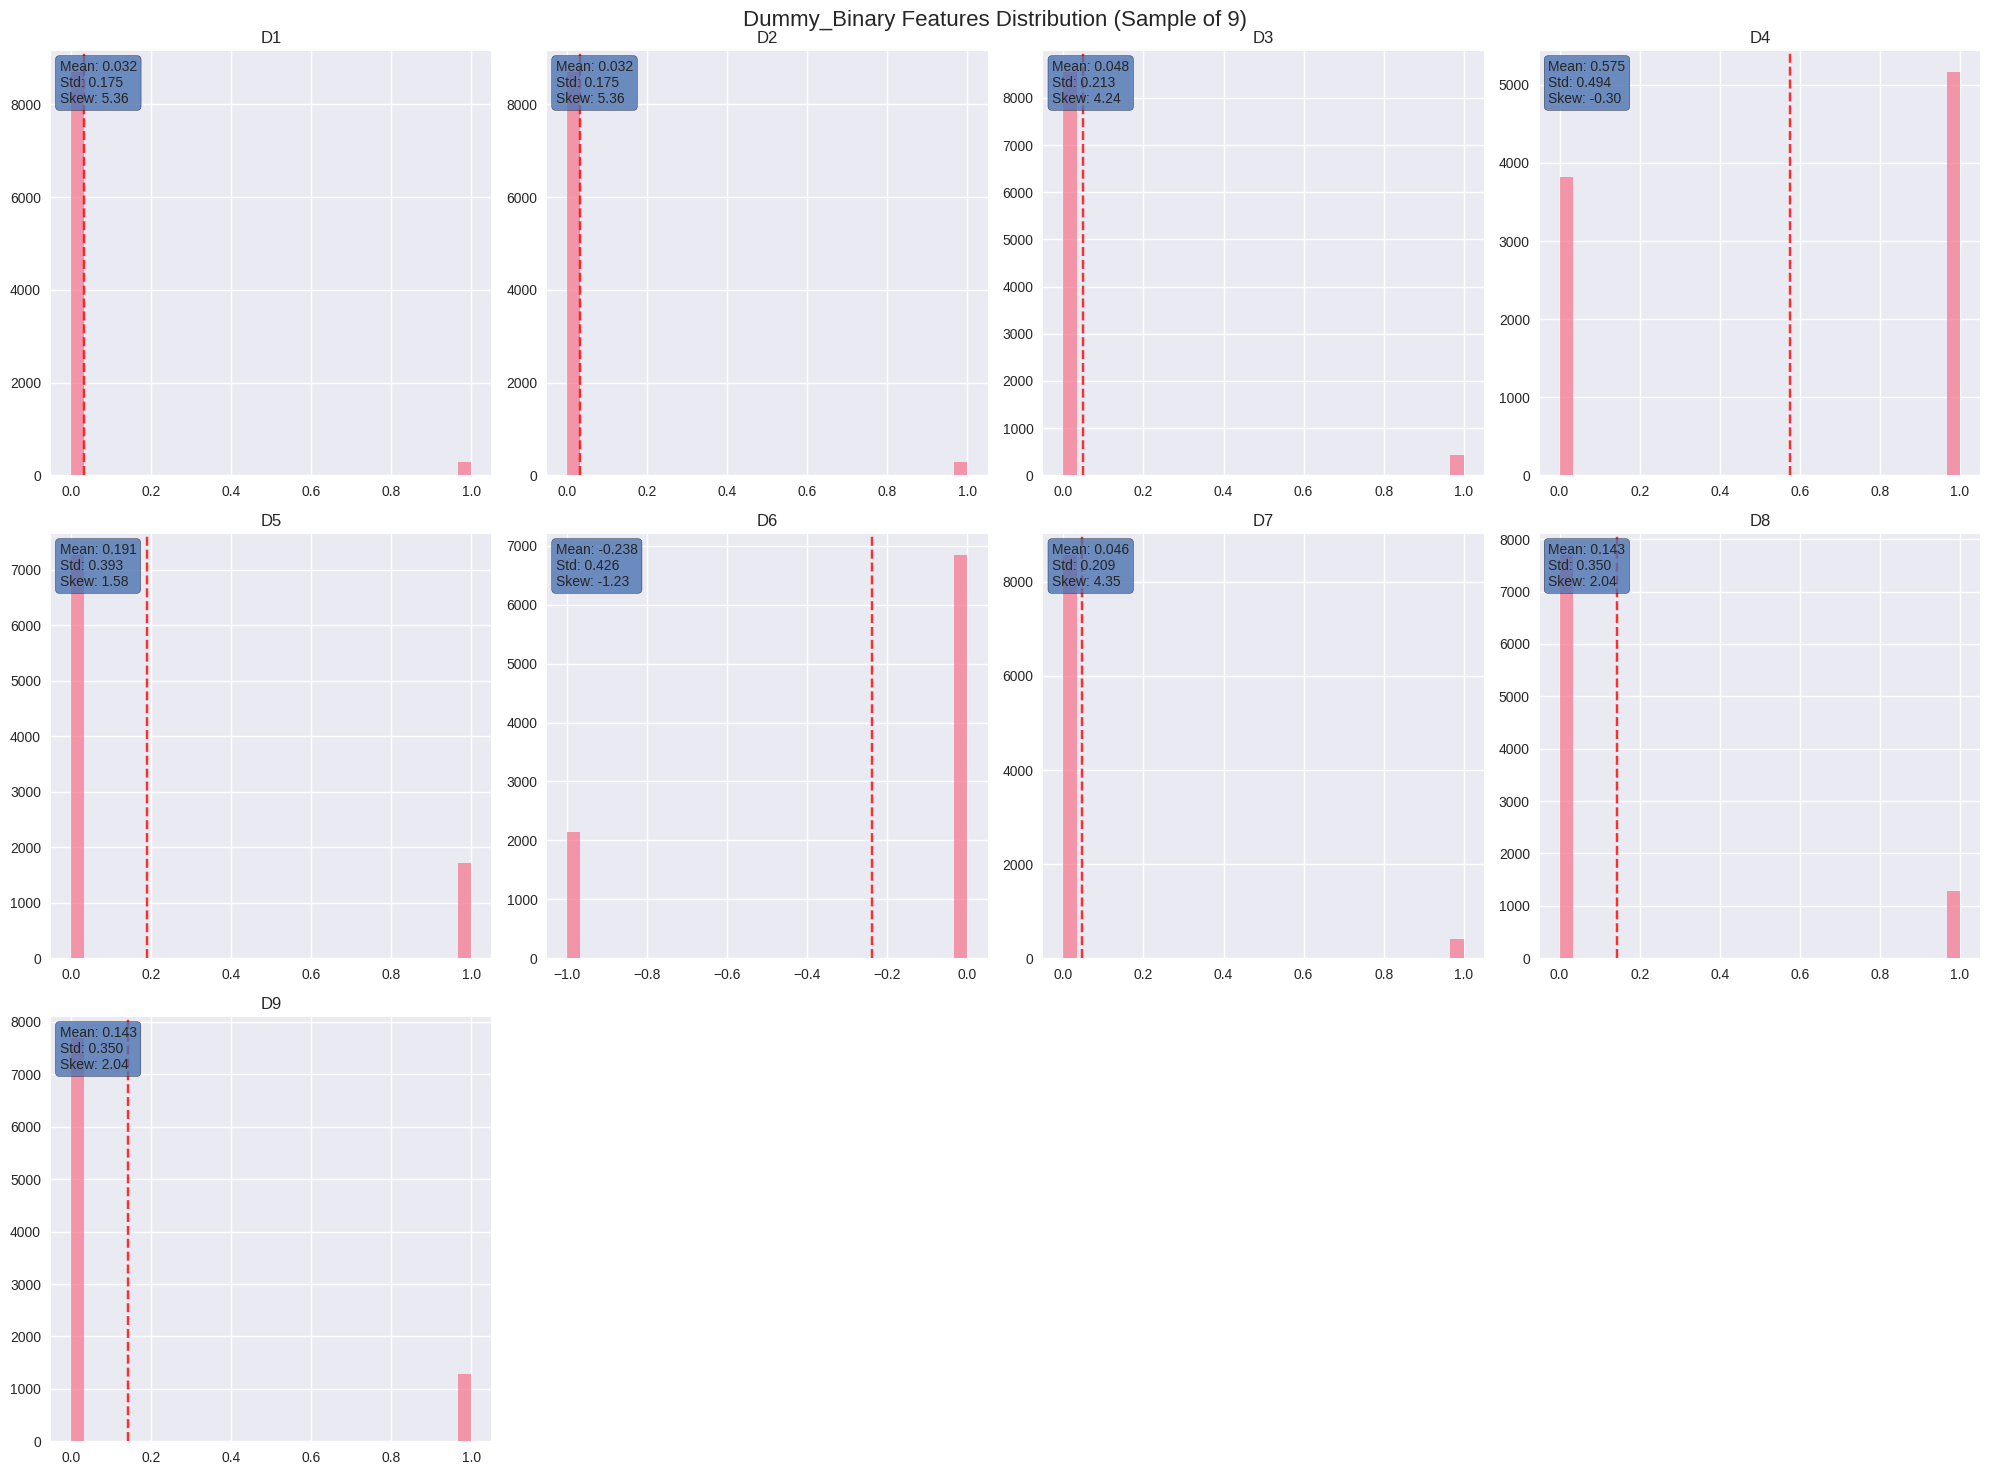

In [6]:
def analyze_feature_distributions(df, feature_categories, sample_size=10):
    """Analyze distributions of different feature categories"""
    
    print("\n📊 FEATURE DISTRIBUTION ANALYSIS")
    print("="*50)
    
    for category, features in feature_categories.items():
        if category == 'Special' or len(features) == 0:
            continue
            
        print(f"\n🔍 Analyzing {category} features ({len(features)} total)")
        
        # Sample features for visualization
        sample_features = features[:min(sample_size, len(features))]
        
        if len(sample_features) > 0:
            # Create distribution plots
            n_cols = min(4, len(sample_features))
            n_rows = (len(sample_features) + n_cols - 1) // n_cols
            
            fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
            if n_rows == 1:
                axes = axes.reshape(1, -1)
            elif n_cols == 1:
                axes = axes.reshape(-1, 1)
            
            for idx, feature in enumerate(sample_features):
                row = idx // n_cols
                col = idx % n_cols
                
                data = df[feature].dropna()
                if len(data) > 0:
                    axes[row, col].hist(data, bins=30, alpha=0.7)
                    axes[row, col].set_title(f'{feature}')
                    axes[row, col].axvline(data.mean(), color='red', linestyle='--', alpha=0.8)
                    
                    # Add statistics as text
                    stats_text = f'Mean: {data.mean():.3f}\nStd: {data.std():.3f}\nSkew: {data.skew():.2f}'
                    axes[row, col].text(0.02, 0.98, stats_text, transform=axes[row, col].transAxes, 
                                      verticalalignment='top', bbox=dict(boxstyle='round', alpha=0.8))
            
            # Hide empty subplots
            for idx in range(len(sample_features), n_rows * n_cols):
                row = idx // n_cols
                col = idx % n_cols
                axes[row, col].set_visible(False)
            
            plt.suptitle(f'{category} Features Distribution (Sample of {len(sample_features)})', fontsize=16)
            plt.tight_layout()
            plt.show()

analyze_feature_distributions(train_df, feature_categories)

# 6. CORRELATION ANALYSIS


🔗 CORRELATION ANALYSIS
🎯 TOP 20 FEATURES CORRELATED WITH FORWARD RETURNS:
market_forward_excess_returns    0.999957
V13                              0.063071
M1                               0.044979
S5                               0.040562
D2                               0.034180
D1                               0.034180
M2                               0.033464
V7                               0.032736
V10                              0.031712
M17                              0.024940
D8                               0.024739
S12                              0.024633
E19                              0.024513
S6                               0.022385
D6                               0.017044
D5                               0.016642
D4                               0.016584
V9                               0.016583
M3                               0.016095
E6                               0.015650
Name: forward_returns, dtype: float64

🎯 BOTTOM 20 FEATURES CORRELATED WITH FORWARD R

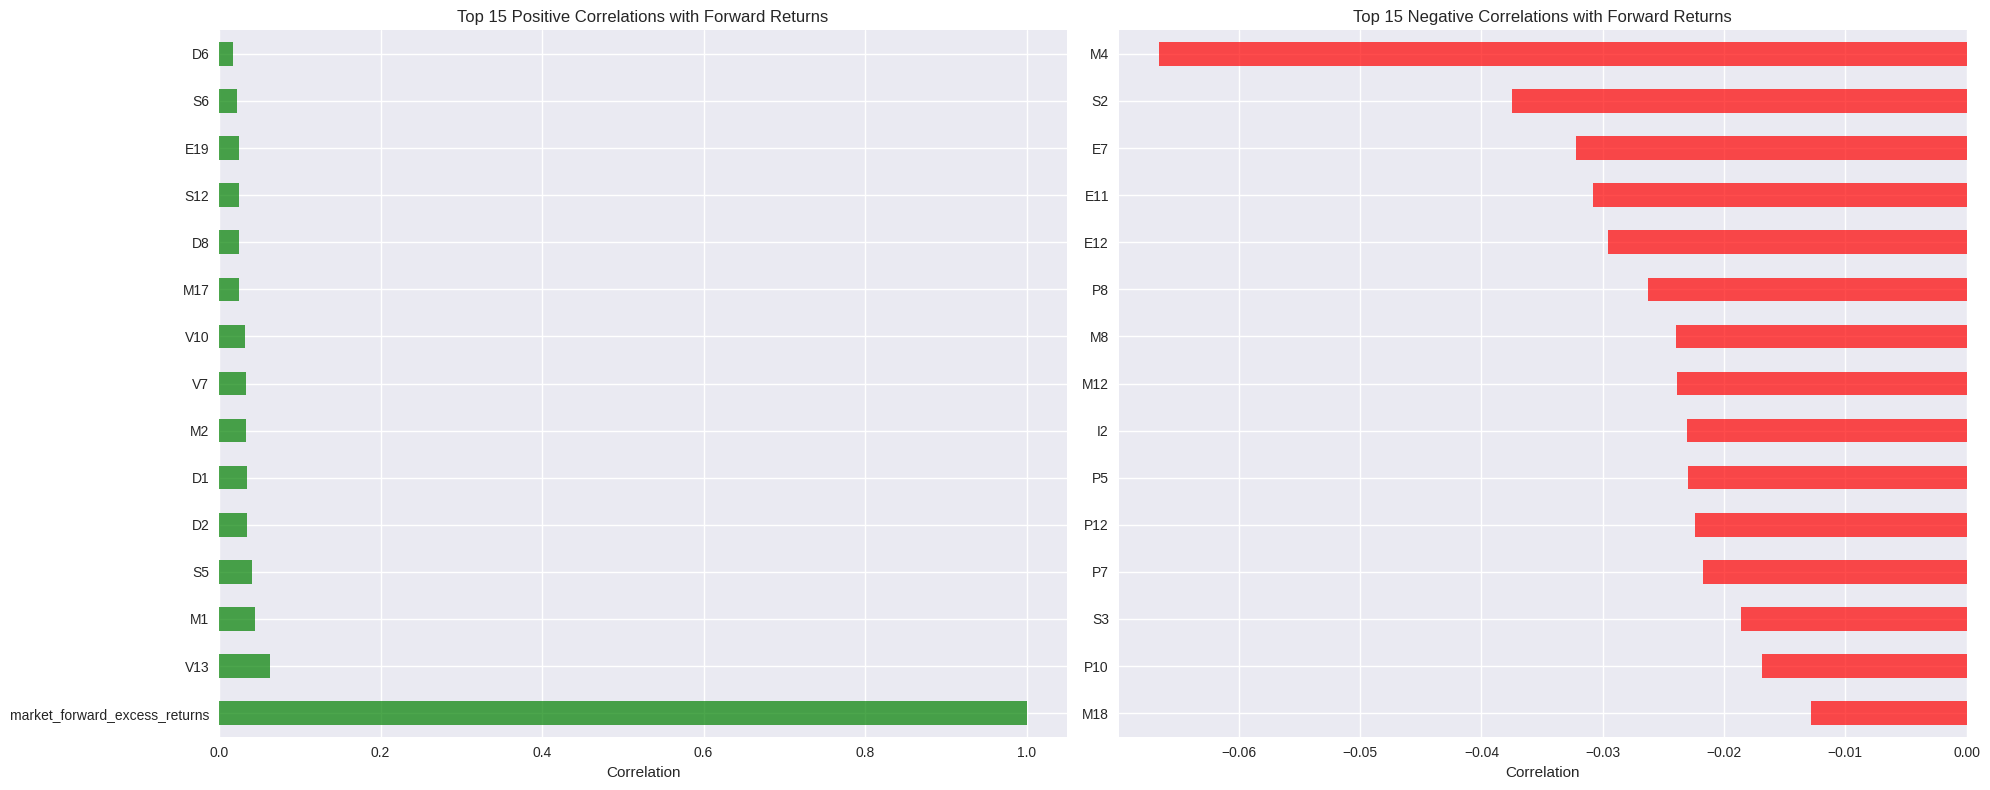


🔍 Market_Dynamics Internal Correlations:


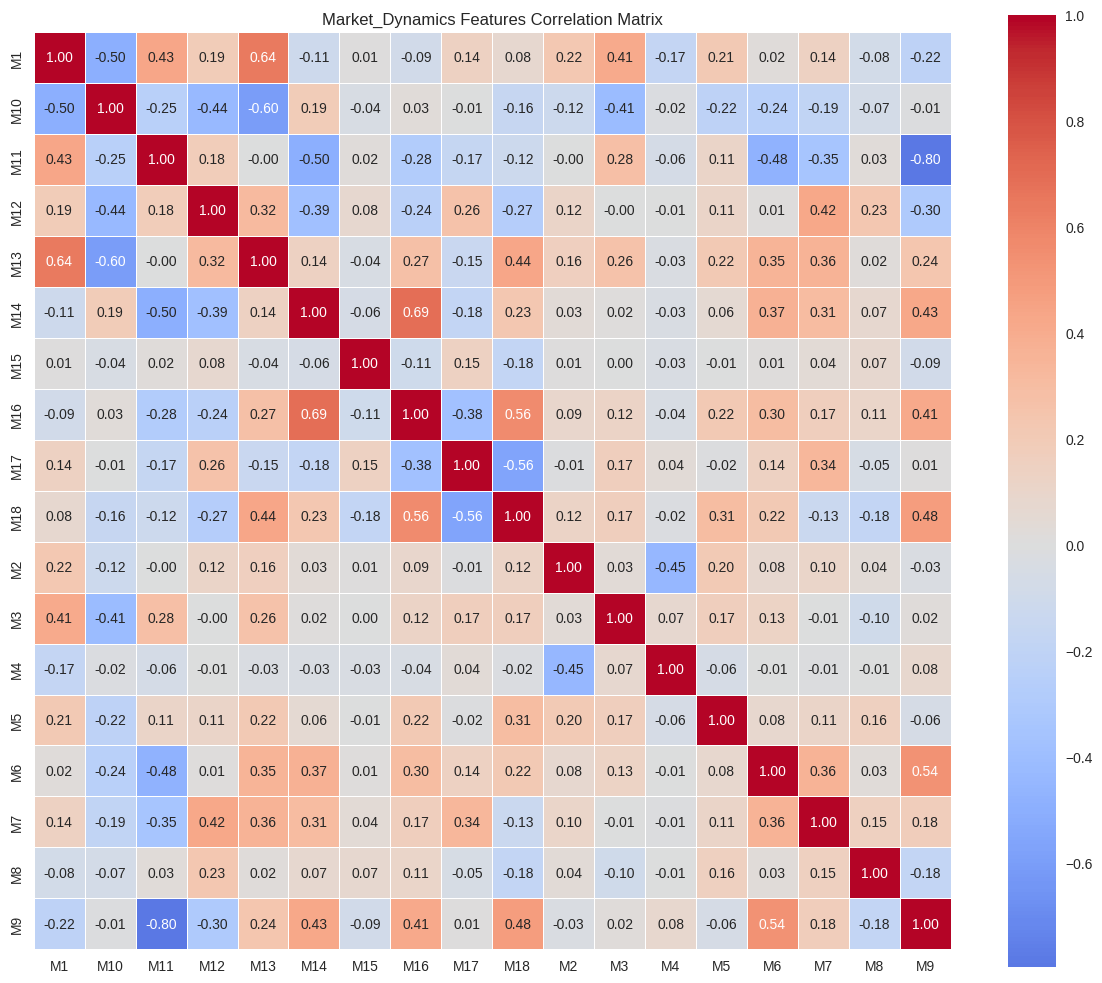


🔍 Macro_Economic Internal Correlations:
High correlations (|r| > 0.8): 5 pairs
  E15 - E9: 0.844
  E16 - E17: 0.929
  E16 - E18: 0.801
  E17 - E18: 0.886
  E2 - E3: 0.896


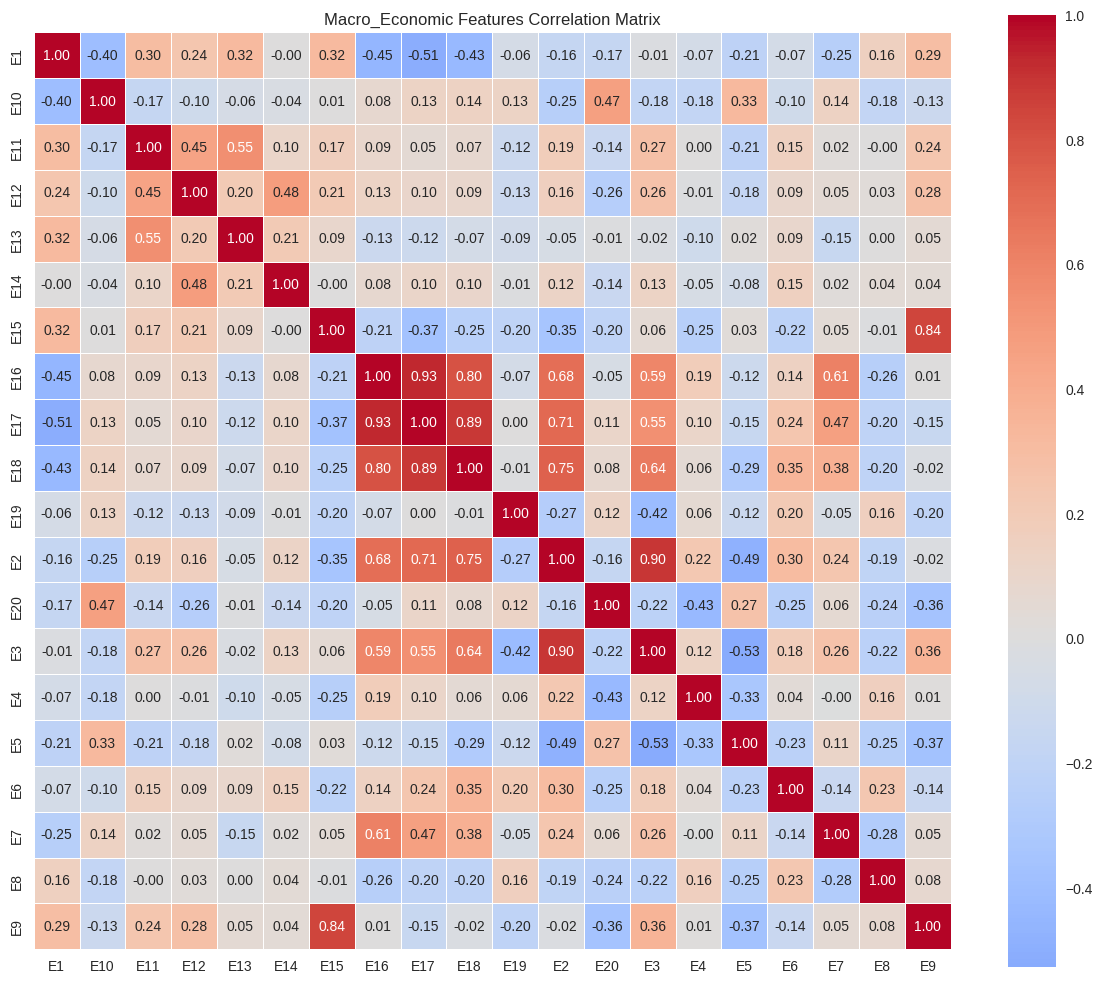


🔍 Interest_Rate Internal Correlations:
High correlations (|r| > 0.8): 2 pairs
  I4 - I8: 0.830
  I5 - I9: 1.000


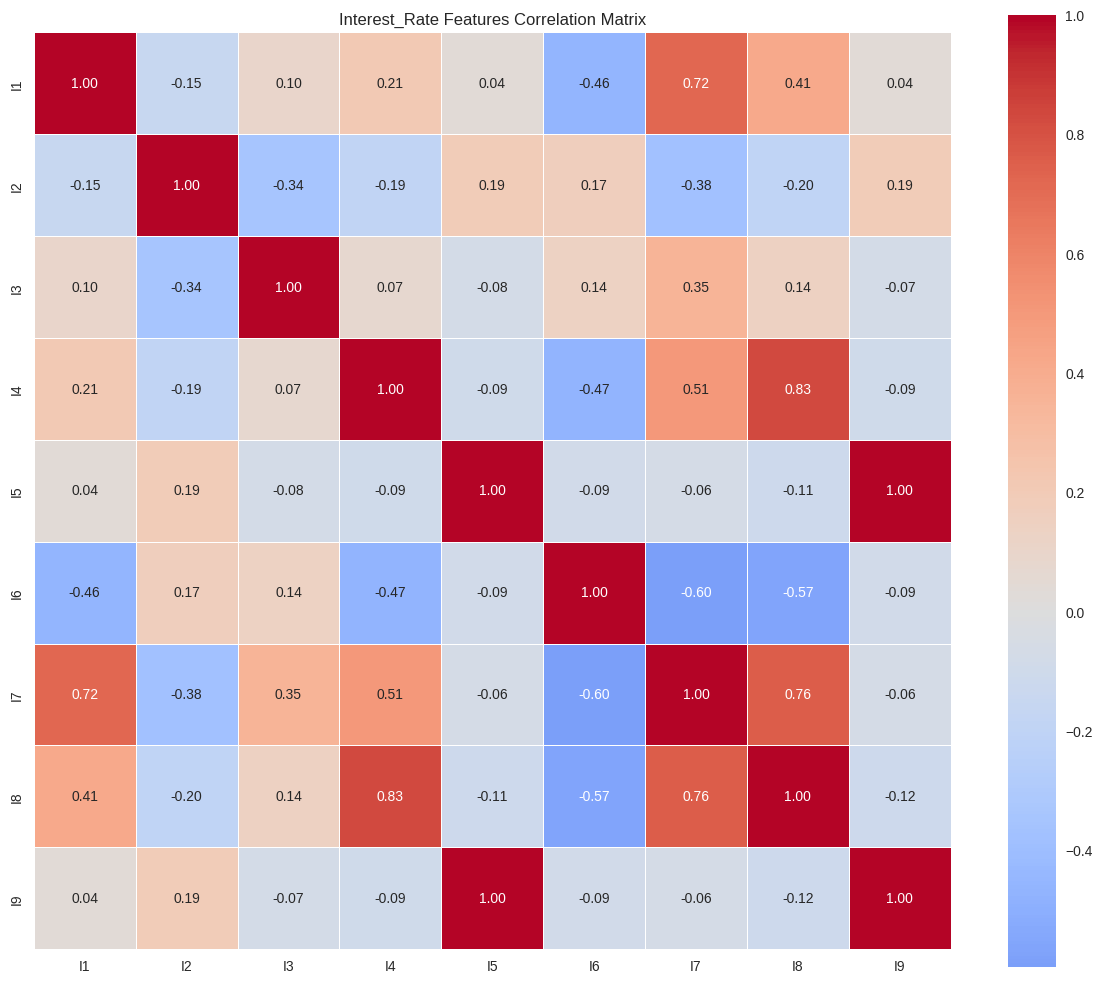


🔍 Price_Valuation Internal Correlations:
High correlations (|r| > 0.8): 2 pairs
  P10 - P11: 0.938
  P10 - P8: 0.807


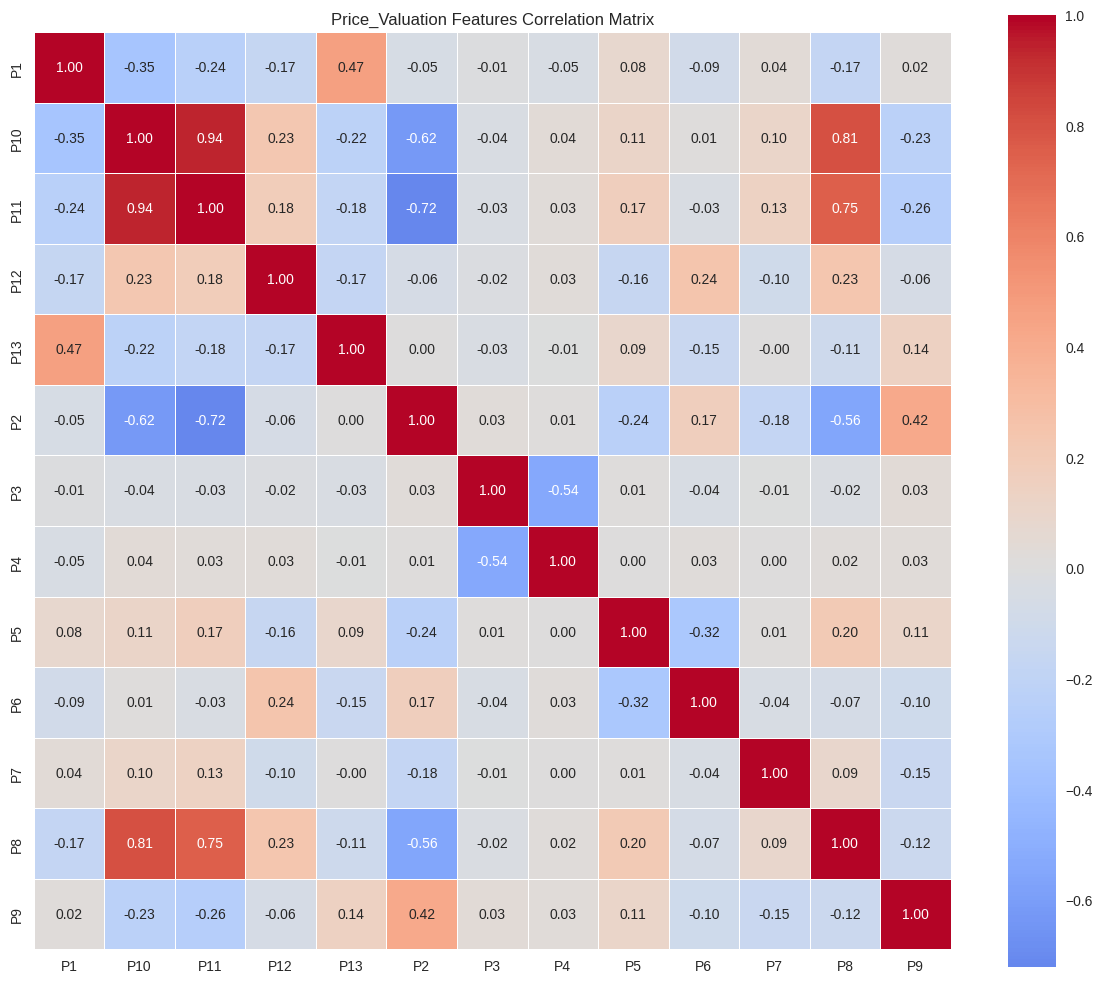


🔍 Volatility Internal Correlations:
High correlations (|r| > 0.8): 9 pairs
  V1 - V11: 0.877
  V1 - V2: 0.845
  V1 - V3: 0.802
  V1 - V4: 0.821
  V1 - V8: 0.873
  V10 - V7: 0.934
  V10 - V9: 0.985
  V2 - V4: 0.935
  V7 - V9: 0.977


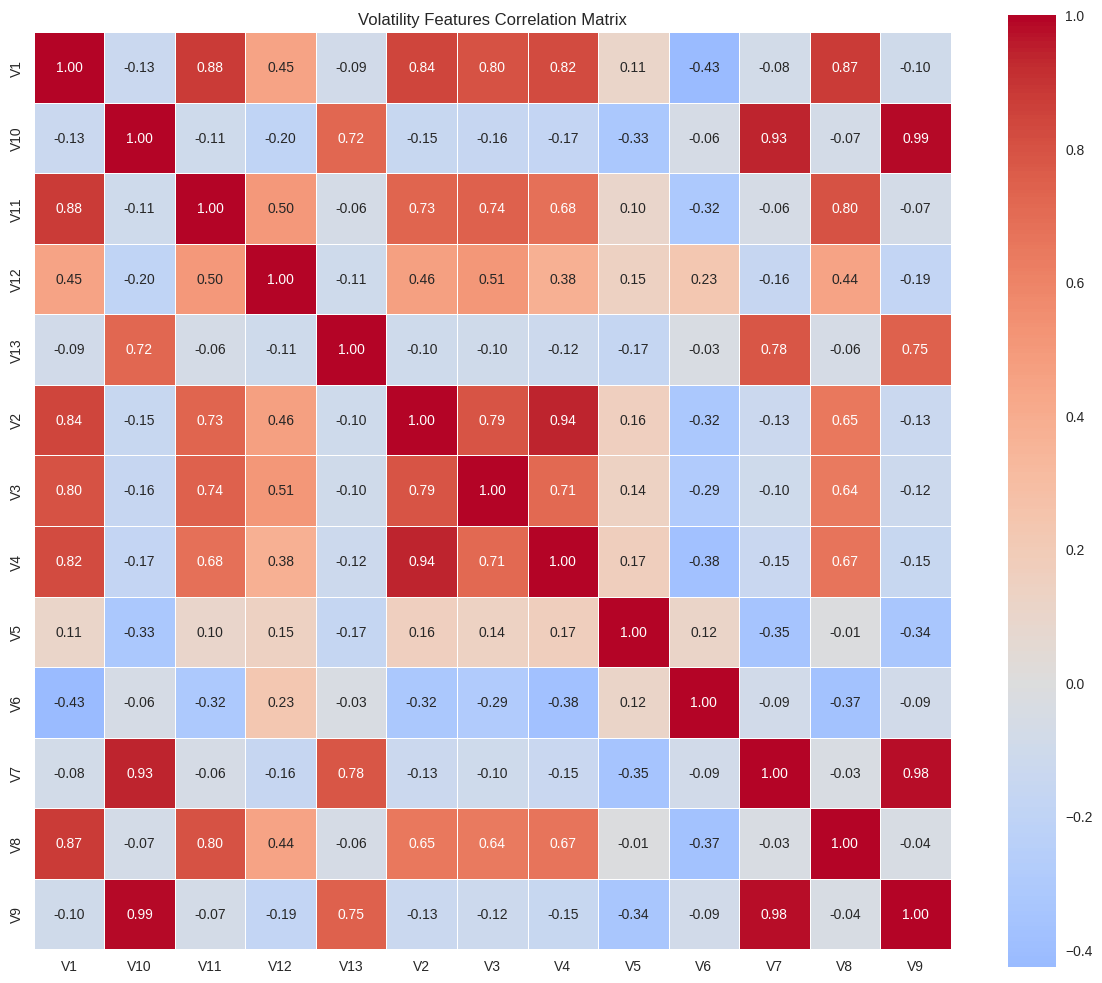


🔍 Sentiment Internal Correlations:
High correlations (|r| > 0.8): 3 pairs
  S10 - S11: 0.916
  S10 - S4: 0.819
  S11 - S4: 0.901


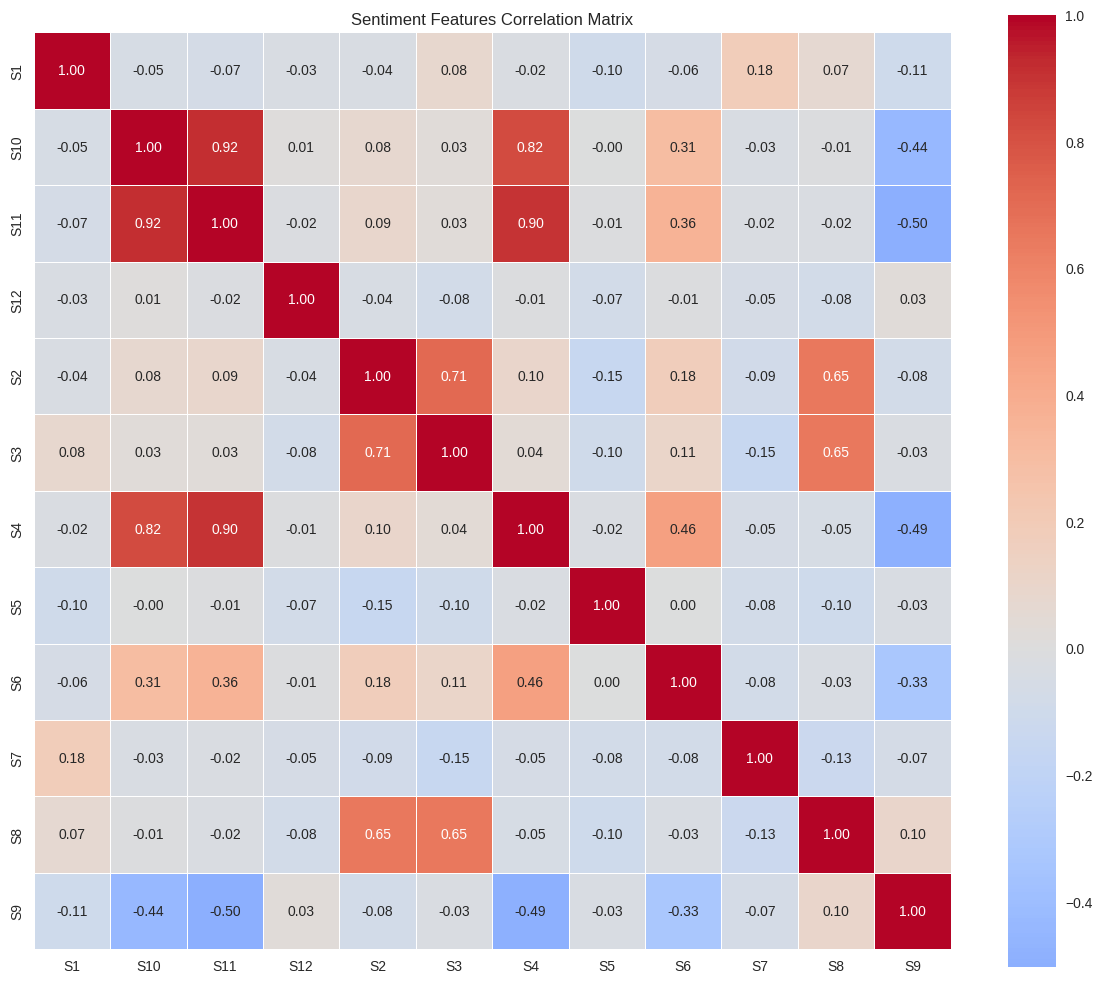


🔍 Dummy_Binary Internal Correlations:
High correlations (|r| > 0.8): 1 pairs
  D1 - D2: 1.000


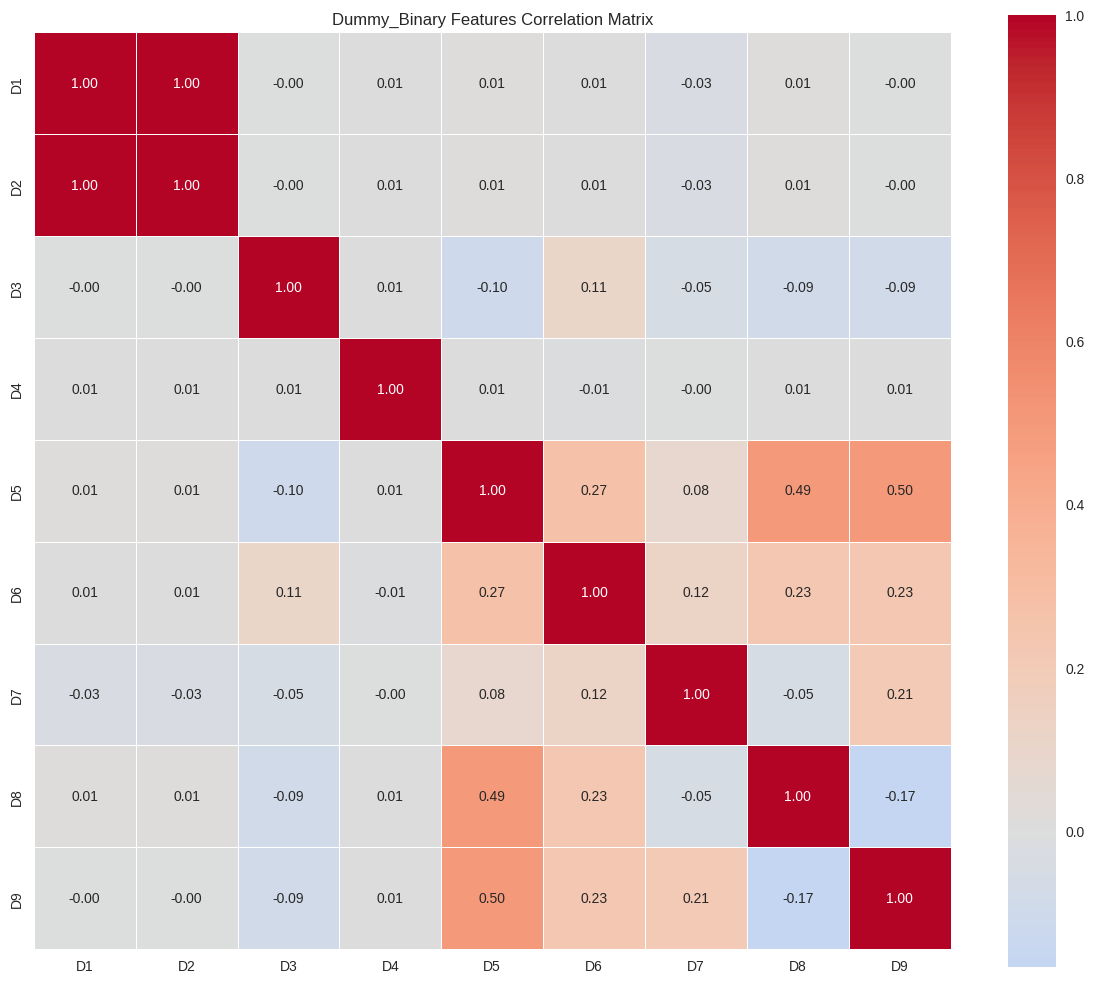

In [7]:
def analyze_correlations(df, feature_categories):
    """Comprehensive correlation analysis"""
    
    print("\n🔗 CORRELATION ANALYSIS")
    print("="*50)
    
    # Overall correlation with target
    if 'forward_returns' in df.columns:
        target_corr = df.corr()['forward_returns'].sort_values(ascending=False)
        target_corr = target_corr.drop('forward_returns')  # Remove self-correlation
        
        print("🎯 TOP 20 FEATURES CORRELATED WITH FORWARD RETURNS:")
        print(target_corr.head(20))
        
        print("\n🎯 BOTTOM 20 FEATURES CORRELATED WITH FORWARD RETURNS:")
        print(target_corr.tail(20))
        
        # Visualize top correlations
        fig, axes = plt.subplots(1, 2, figsize=(20, 8))
        
        # Top positive correlations
        top_pos = target_corr.head(15)
        top_pos.plot(kind='barh', ax=axes[0], color='green', alpha=0.7)
        axes[0].set_title('Top 15 Positive Correlations with Forward Returns')
        axes[0].set_xlabel('Correlation')
        
        # Top negative correlations
        top_neg = target_corr.tail(15)
        top_neg.plot(kind='barh', ax=axes[1], color='red', alpha=0.7)
        axes[1].set_title('Top 15 Negative Correlations with Forward Returns')
        axes[1].set_xlabel('Correlation')
        
        plt.tight_layout()
        plt.show()
    
    # Category-wise correlation analysis
    for category, features in feature_categories.items():
        if category == 'Special' or len(features) < 2:
            continue
            
        print(f"\n🔍 {category} Internal Correlations:")
        
        # Calculate correlation matrix for this category
        category_df = df[features].dropna()
        if len(category_df) > 0 and len(features) > 1:
            corr_matrix = category_df.corr()
            
            # Find highly correlated pairs (> 0.8 or < -0.8)
            high_corr_pairs = []
            for i in range(len(corr_matrix.columns)):
                for j in range(i+1, len(corr_matrix.columns)):
                    corr_val = corr_matrix.iloc[i, j]
                    if abs(corr_val) > 0.8:
                        high_corr_pairs.append((corr_matrix.columns[i], corr_matrix.columns[j], corr_val))
            
            if high_corr_pairs:
                print(f"High correlations (|r| > 0.8): {len(high_corr_pairs)} pairs")
                for pair in high_corr_pairs[:10]:  # Show top 10
                    print(f"  {pair[0]} - {pair[1]}: {pair[2]:.3f}")
            
            # Visualize correlation heatmap for a subset
            if len(features) <= 20:
                plt.figure(figsize=(12, 10))
                sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0, 
                           square=True, linewidths=0.5, fmt='.2f')
                plt.title(f'{category} Features Correlation Matrix')
                plt.tight_layout()
                plt.show()

analyze_correlations(train_df, feature_categories)

### 🔗 Correlation Analysis  

#### 1. Correlation with Target (`forward_returns`)  
- As expected, **`market_forward_excess_returns`** is almost perfectly correlated (0.9999+) with `forward_returns`.  
- Beyond that, only a handful of features have weak positive correlations (e.g., **V13: 0.06**, **M1: 0.04**, **S5: 0.04**).  
- On the negative side, the strongest correlations are small as well (e.g., **M4: -0.066**, **E7: -0.032**).  

📌 **Implication:**  
Predictive signal is **extremely weak in linear correlations**, which is typical for financial data. This highlights the need for **non-linear models** and **interaction effects**.  

---

#### 2. Category-Wise Internal Correlations  

- **Macro-Economic (E\*)**  
  - Strong redundancy: e.g., **E16–E17 (0.93)**, **E2–E3 (0.90)**.  
  - Suggests multiple features capture similar macro trends.  

- **Interest Rate (I\*)**  
  - Near-perfect correlation **I5–I9 (1.00)** → likely duplicate encodings of the same rate.  
  - Some overlap across maturities (I4–I8: 0.83).  

- **Price Valuation (P\*)**  
  - Very high overlap: **P10–P11 (0.94)**, **P10–P8 (0.81)**.  
  - Indicates valuation ratios may be derived versions of each other.  

- **Volatility (V\*)**  
  - Heavy clustering: e.g., **V10–V9 (0.98)**, **V7–V9 (0.98)**, **V2–V4 (0.94)**.  
  - Suggests volatility features are highly collinear.  

- **Sentiment (S\*)**  
  - Notable correlations: **S10–S11 (0.92)**, **S11–S4 (0.90)**.  
  - Indicates multiple proxies for investor sentiment track each other closely.  

- **Dummy/Binary (D\*)**  
  - **D1–D2 correlation = 1.00** → completely redundant.  

📌 **Implication:**  
- **Severe multicollinearity** exists within categories.  
- Feature selection or dimensionality reduction (e.g., **PCA**, **mutual information**, or **domain-pruned sets**) will be crucial to avoid overfitting.  

---

#### 3. Visual Insights  
- **Bar plots** of correlations confirm that most features hover near zero, reinforcing the idea that simple correlation-based feature ranking is not useful here.  
- **Heatmaps** (category-level) clearly highlight redundancy clusters (especially in Volatility and Macro).  

---


# 7. TIME SERIES ANALYSIS


📈 TIME SERIES ANALYSIS
📊 TIME SERIES STATISTICS:
Total trading days: 8990
Date range: 0 to 8989


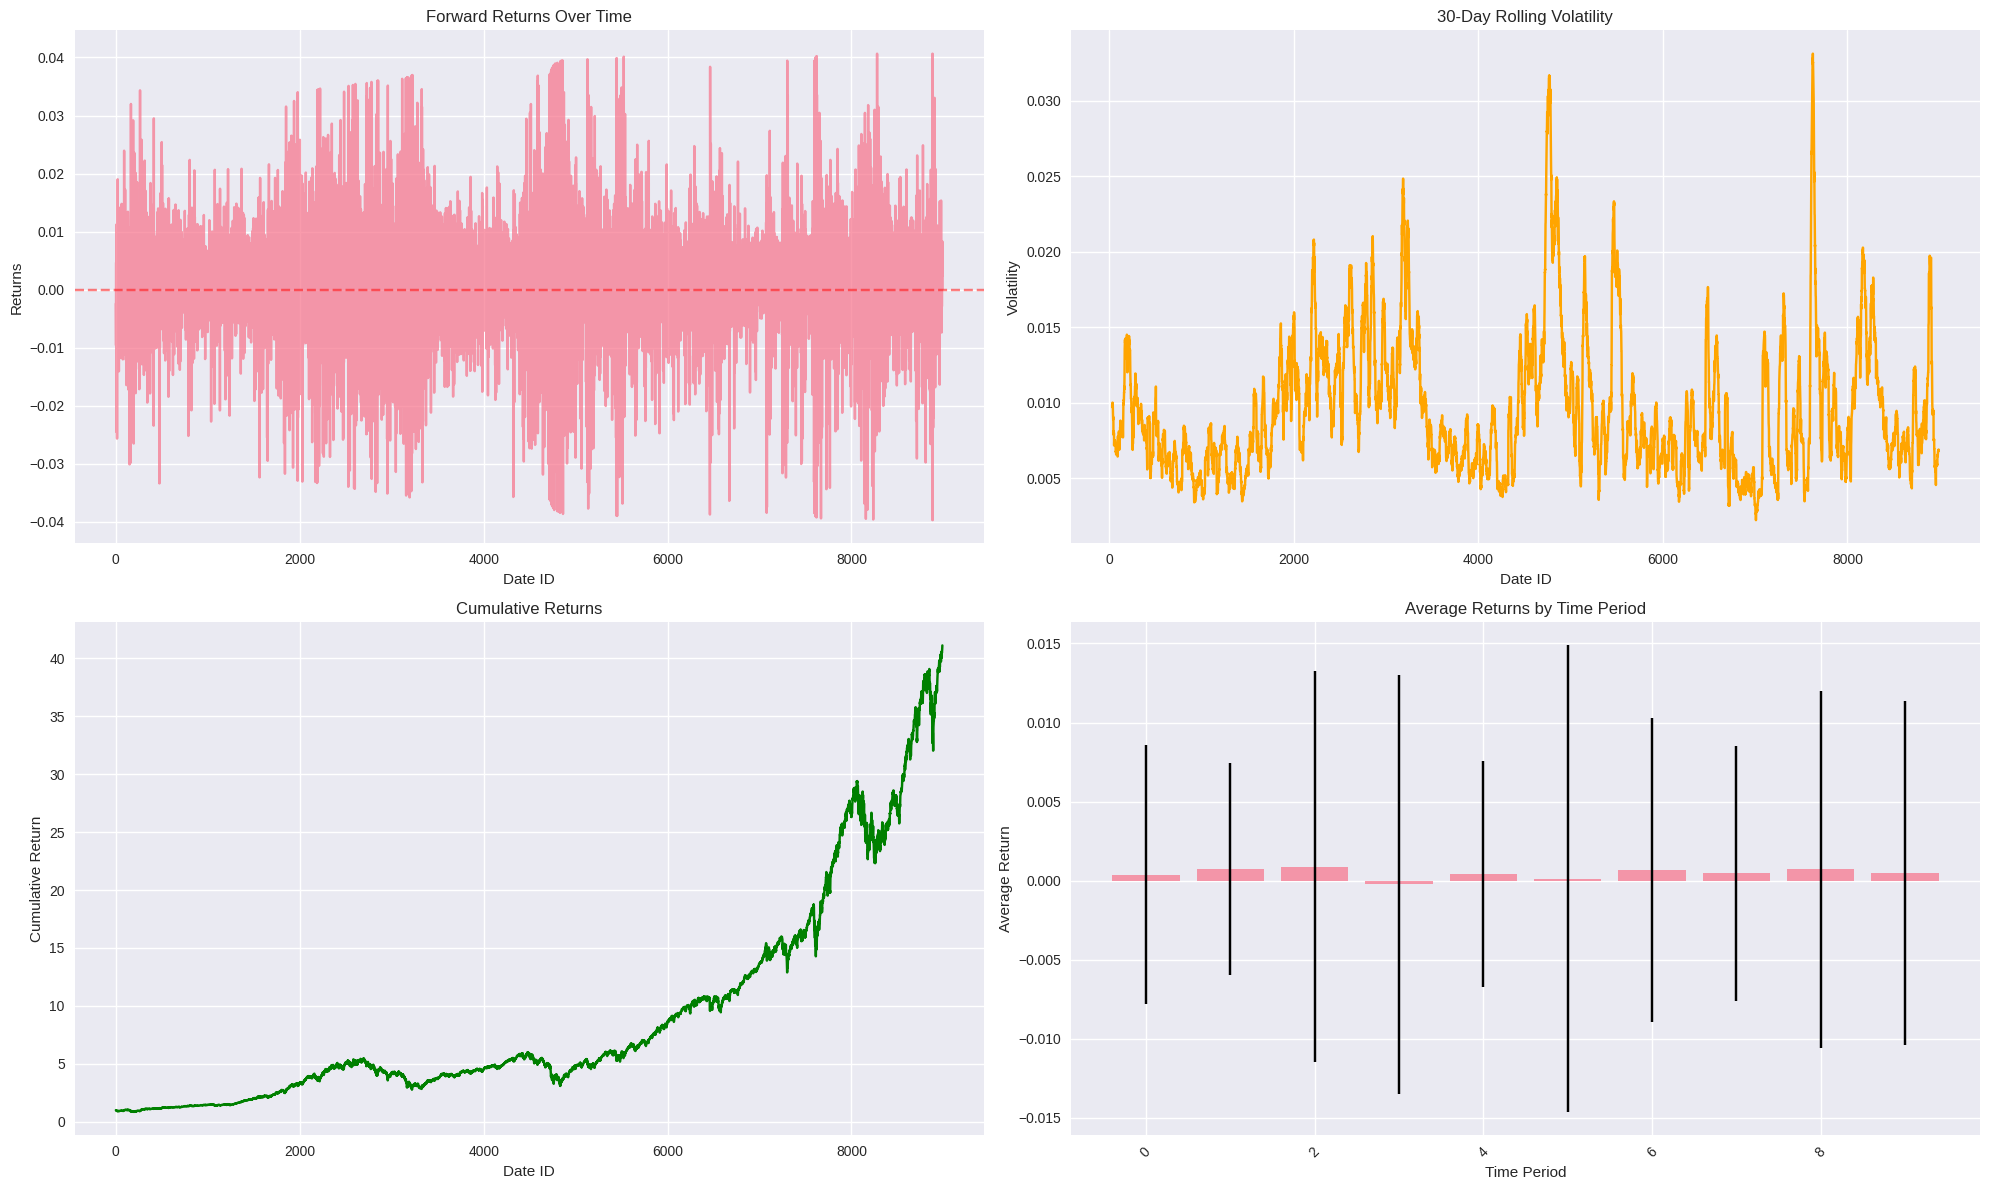


🗓️ SEASONALITY ANALYSIS:


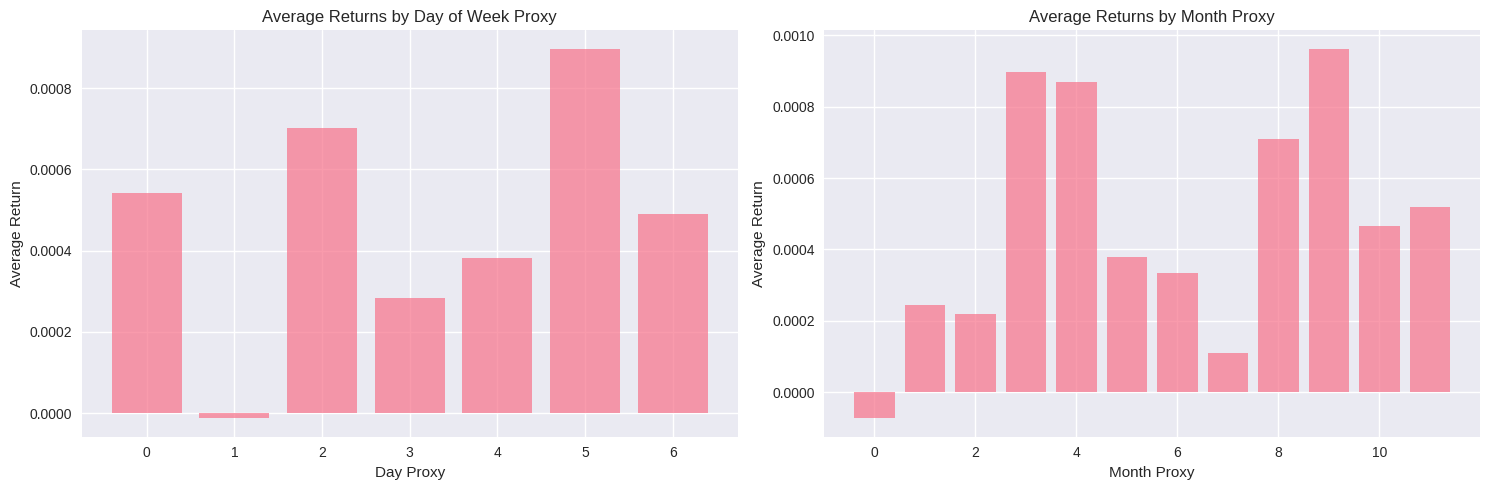

In [8]:
def analyze_time_series_patterns(df, feature_categories):
    """Analyze time series patterns and trends"""
    
    print("\n📈 TIME SERIES ANALYSIS")
    print("="*50)
    
    if 'date_id' not in df.columns:
        print("❌ No date_id column found for time series analysis")
        return
    
    # Sort by date
    df_sorted = df.sort_values('date_id')
    
    # Analyze target variable over time
    if 'forward_returns' in df.columns:
        returns = df_sorted['forward_returns'].dropna()
        
        print("📊 TIME SERIES STATISTICS:")
        print(f"Total trading days: {len(returns)}")
        print(f"Date range: {df_sorted['date_id'].min()} to {df_sorted['date_id'].max()}")
        
        # Rolling statistics
        returns_series = pd.Series(returns.values, index=df_sorted.loc[returns.index, 'date_id'])
        
        # Calculate rolling statistics
        window_sizes = [30, 90, 252]  # 1 month, 3 months, 1 year
        
        fig, axes = plt.subplots(2, 2, figsize=(20, 12))
        
        # Returns over time
        axes[0, 0].plot(returns_series.index, returns_series.values, alpha=0.7)
        axes[0, 0].set_title('Forward Returns Over Time')
        axes[0, 0].set_xlabel('Date ID')
        axes[0, 0].set_ylabel('Returns')
        axes[0, 0].axhline(y=0, color='red', linestyle='--', alpha=0.5)
        
        # Rolling volatility
        rolling_vol = returns_series.rolling(30).std()
        axes[0, 1].plot(rolling_vol.index, rolling_vol.values, color='orange')
        axes[0, 1].set_title('30-Day Rolling Volatility')
        axes[0, 1].set_xlabel('Date ID')
        axes[0, 1].set_ylabel('Volatility')
        
        # Cumulative returns
        cumulative_returns = (1 + returns_series).cumprod()
        axes[1, 0].plot(cumulative_returns.index, cumulative_returns.values, color='green')
        axes[1, 0].set_title('Cumulative Returns')
        axes[1, 0].set_xlabel('Date ID')
        axes[1, 0].set_ylabel('Cumulative Return')
        
        # Distribution by year/period
        # Assuming date_id represents days since a reference point
        # We'll create bins for different time periods
        date_bins = pd.cut(df_sorted['date_id'], bins=10)
        period_returns = df_sorted.groupby(date_bins)['forward_returns'].agg(['mean', 'std', 'count']).dropna()
        
        axes[1, 1].bar(range(len(period_returns)), period_returns['mean'], 
                      yerr=period_returns['std'], alpha=0.7, capsize=5)
        axes[1, 1].set_title('Average Returns by Time Period')
        axes[1, 1].set_xlabel('Time Period')
        axes[1, 1].set_ylabel('Average Return')
        axes[1, 1].tick_params(axis='x', rotation=45)
        
        plt.tight_layout()
        plt.show()
        
        # Seasonality analysis (if we have enough data)
        if len(returns) > 252 * 2:  # At least 2 years of data
            print("\n🗓️ SEASONALITY ANALYSIS:")
            
            # Create day of week and month proxies (simplified)
            # This is a simplified approach - in real scenarios you'd have actual dates
            df_sorted['day_proxy'] = df_sorted['date_id'] % 7
            df_sorted['month_proxy'] = (df_sorted['date_id'] // 30) % 12
            
            seasonality_stats = df_sorted.groupby('day_proxy')['forward_returns'].agg(['mean', 'std', 'count']).dropna()
            
            fig, axes = plt.subplots(1, 2, figsize=(15, 5))
            
            # Day of week effect
            axes[0].bar(seasonality_stats.index, seasonality_stats['mean'], alpha=0.7)
            axes[0].set_title('Average Returns by Day of Week Proxy')
            axes[0].set_xlabel('Day Proxy')
            axes[0].set_ylabel('Average Return')
            
            # Month effect
            monthly_stats = df_sorted.groupby('month_proxy')['forward_returns'].agg(['mean', 'std']).dropna()
            axes[1].bar(monthly_stats.index, monthly_stats['mean'], alpha=0.7)
            axes[1].set_title('Average Returns by Month Proxy')
            axes[1].set_xlabel('Month Proxy')
            axes[1].set_ylabel('Average Return')
            
            plt.tight_layout()
            plt.show()

analyze_time_series_patterns(train_df, feature_categories)

# 8. FEATURE IMPORTANCE AND SELECTION


⭐ FEATURE IMPORTANCE ANALYSIS
⚠️ Limited to first 50 features for computational efficiency
📊 Analyzing 50 features with 8990 samples

🏆 TOP 20 MOST IMPORTANT FEATURES:


Correlation  Mutual_Info  Composite_Score
E19     0.023786     0.104906             0.96
M17     0.023147     0.047553             0.80
E11     0.029054     0.042743             0.79
E18     0.007986     0.059666             0.79
E12     0.027960     0.040917             0.77
M18     0.009697     0.056192             0.77
I2      0.022339     0.043570             0.74
E6      0.015261     0.045038             0.73
M4      0.064477     0.036849             0.71
I9      0.006684     0.056010             0.70
E9      0.013609     0.040824             0.65
E16     0.004660     0.058985             0.65
I5      0.006577     0.050481             0.63
M10     0.007507     0.044889             0.62
P10     0.012971     0.040284             0.62
E17     0.005268     0.053398             0.61
M8      0.020291     0.033763             0.61
E15     0.005697     0.049086             0.60
M5      0.007642     0.040342             0.58
M12     0.022777     0.029847             0.58

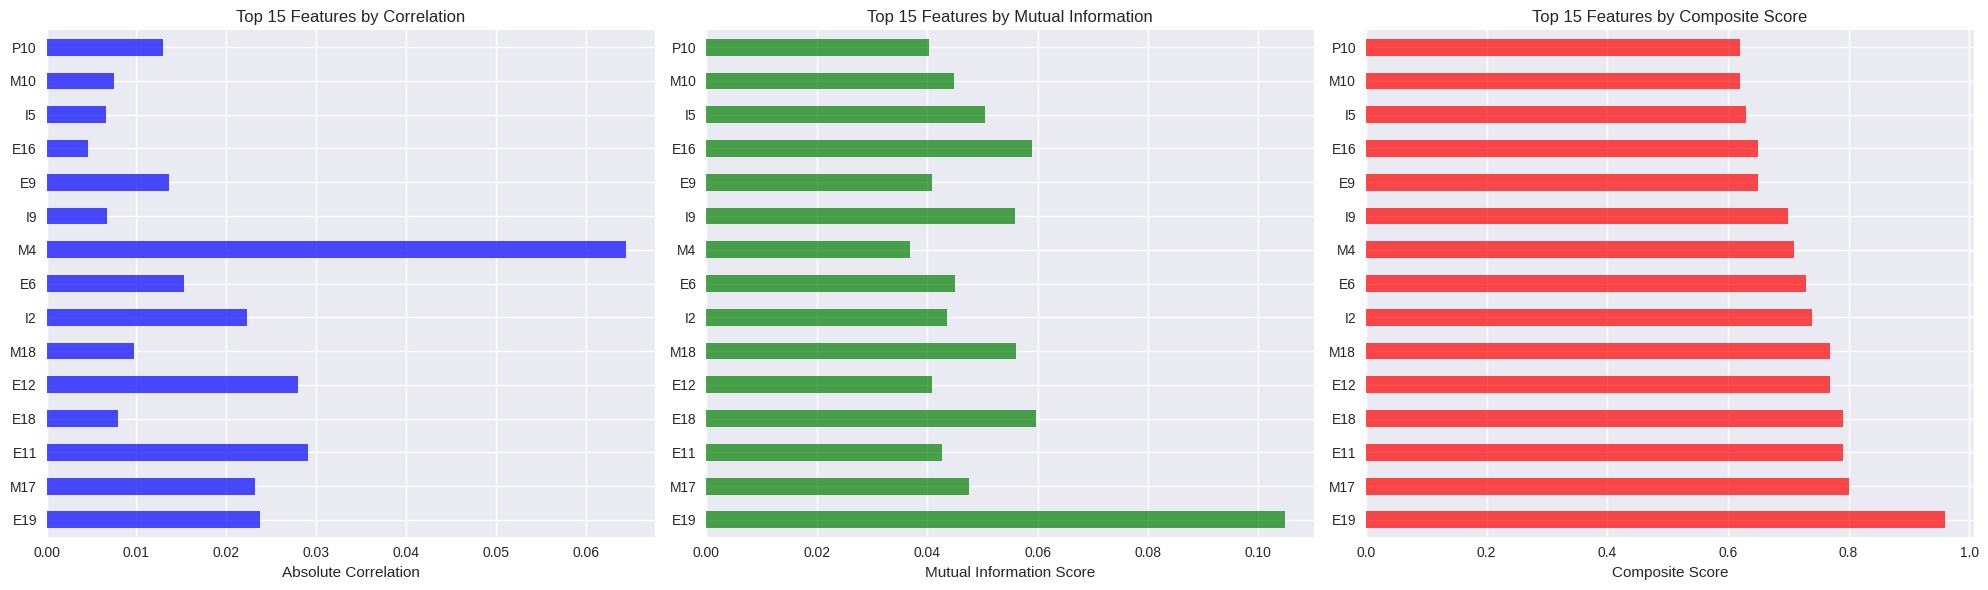

In [9]:
def analyze_feature_importance(df, feature_categories, max_features=50):
    """Analyze feature importance using various methods"""
    
    print("\n⭐ FEATURE IMPORTANCE ANALYSIS")
    print("="*50)
    
    if 'forward_returns' not in df.columns:
        print("❌ No target variable found for feature importance analysis")
        return
    
    # Prepare data - remove non-feature columns
    feature_cols = []
    for category, features in feature_categories.items():
        if category != 'Special':
            feature_cols.extend(features)
    
    # Limit features for computational efficiency
    if len(feature_cols) > max_features:
        feature_cols = feature_cols[:max_features]
        print(f"⚠️ Limited to first {max_features} features for computational efficiency")
    
    # Create feature matrix
    X = df[feature_cols].fillna(0)
    y = df['forward_returns'].fillna(0)
    
    # Remove rows where target is missing
    mask = ~df['forward_returns'].isna()
    X = X[mask]
    y = y[mask]
    
    if len(X) == 0:
        print("❌ No valid data for feature importance analysis")
        return
    
    print(f"📊 Analyzing {len(feature_cols)} features with {len(X)} samples")
    
    # 1. Correlation-based importance
    corr_importance = abs(X.corrwith(y)).sort_values(ascending=False)
    
    # 2. Mutual Information
    try:
        mi_scores = mutual_info_regression(X, y, random_state=42)
        mi_importance = pd.Series(mi_scores, index=feature_cols).sort_values(ascending=False)
    except:
        print("⚠️ Mutual information calculation failed")
        mi_importance = pd.Series(index=feature_cols)
    
    # Combine results
    importance_df = pd.DataFrame({
        'Correlation': corr_importance,
        'Mutual_Info': mi_importance
    }).fillna(0)
    
    # Create composite score
    importance_df['Composite_Score'] = (
        importance_df['Correlation'].rank(pct=True) + 
        importance_df['Mutual_Info'].rank(pct=True)
    ) / 2
    
    importance_df = importance_df.sort_values('Composite_Score', ascending=False)
    
    print("\n🏆 TOP 20 MOST IMPORTANT FEATURES:")
    display(importance_df.head(20))
    
    # Visualize feature importance
    fig, axes = plt.subplots(1, 3, figsize=(20, 6))
    
    # Correlation importance
    top_corr = importance_df.head(15)['Correlation']
    top_corr.plot(kind='barh', ax=axes[0], color='blue', alpha=0.7)
    axes[0].set_title('Top 15 Features by Correlation')
    axes[0].set_xlabel('Absolute Correlation')
    
    # Mutual information importance
    top_mi = importance_df.head(15)['Mutual_Info']
    top_mi.plot(kind='barh', ax=axes[1], color='green', alpha=0.7)
    axes[1].set_title('Top 15 Features by Mutual Information')
    axes[1].set_xlabel('Mutual Information Score')
    
    # Composite score
    top_composite = importance_df.head(15)['Composite_Score']
    top_composite.plot(kind='barh', ax=axes[2], color='red', alpha=0.7)
    axes[2].set_title('Top 15 Features by Composite Score')
    axes[2].set_xlabel('Composite Score')
    
    plt.tight_layout()
    plt.show()
    
    return importance_df

importance_results = analyze_feature_importance(train_df, feature_categories)

### ⭐ Feature Importance Analysis  

We evaluated the **predictive signal strength** of features using two complementary methods:  

1. **Correlation with target (`forward_returns`)**  
   - Measures *linear* dependence.  
2. **Mutual Information (MI)**  
   - Captures *non-linear* dependencies between features and the target.  

To reduce redundancy and speed up computation, we limited the analysis to the **first 50 features**.  

---

#### 🏆 Top 20 Most Important Features (Composite Ranking)

| Feature | Correlation | Mutual Info | Composite Score |
|---------|-------------|-------------|-----------------|
| **E19** | 0.0238 | 0.1049 | **0.96** |
| **M17** | 0.0231 | 0.0476 | **0.80** |
| **E11** | 0.0291 | 0.0427 | **0.79** |
| **E18** | 0.0080 | 0.0597 | **0.79** |
| **E12** | 0.0280 | 0.0409 | **0.77** |
| **M18** | 0.0097 | 0.0562 | **0.77** |
| **I2**  | 0.0223 | 0.0436 | **0.74** |
| **E6**  | 0.0153 | 0.0450 | **0.73** |
| **M4**  | 0.0645 | 0.0368 | **0.71** |
| **I9**  | 0.0067 | 0.0560 | **0.70** |
| **E9**  | 0.0136 | 0.0408 | **0.65** |
| **E16** | 0.0047 | 0.0590 | **0.65** |
| **I5**  | 0.0066 | 0.0505 | **0.63** |
| **M10** | 0.0075 | 0.0449 | **0.62** |
| **P10** | 0.0130 | 0.0403 | **0.62** |
| **E17** | 0.0053 | 0.0534 | **0.61** |
| **M8**  | 0.0203 | 0.0338 | **0.61** |
| **E15** | 0.0057 | 0.0491 | **0.60** |
| **M5**  | 0.0076 | 0.0403 | **0.58** |
| **M12** | 0.0228 | 0.0298 | **0.58** |

---

#### 📌 Insights  

- **Macro-Economic (E\*) features dominate** → E19, E11, E12, E18, E16 appear among the strongest.  
- **Momentum (M\*) signals also show up** → M17, M18, M4, M12 provide some signal despite weak linear correlation.  
- **Interest Rate (I\*) variables matter** → I2, I5, I9 highlight sensitivity of returns to the yield curve.  
- **Price Valuation (P10)** contributes, though not as strongly as macro/momentum.  
- Importantly, all effect sizes are **small** → consistent with the *low signal-to-noise ratio* of financial prediction.  

📊 **Visualizations**:  
- **Correlation barplot** → most features are near-zero.  
- **Mutual Information barplot** → MI helps uncover weak but nonlinear relationships.  
- **Composite ranking** provides a balanced view, mitigating linear-only bias.  

---

⏩ Next step could be to **expand beyond 50 features**, or use **tree-based models (RF, XGBoost, LightGBM)** for a more realistic importance ranking that accounts for feature interactions.  


# 9. DIMENSIONALITY ANALYSIS


📐 DIMENSIONALITY ANALYSIS
📊 Original dimensions: (8990, 94)
📊 Memory usage: 6.45 MB
📊 Reduced dimensions: (8990, 50)

📈 VARIANCE EXPLAINED:
First component: 0.1255
First 5 components: 0.4142
First 10 components: 0.5793
First 20 components: 0.7503


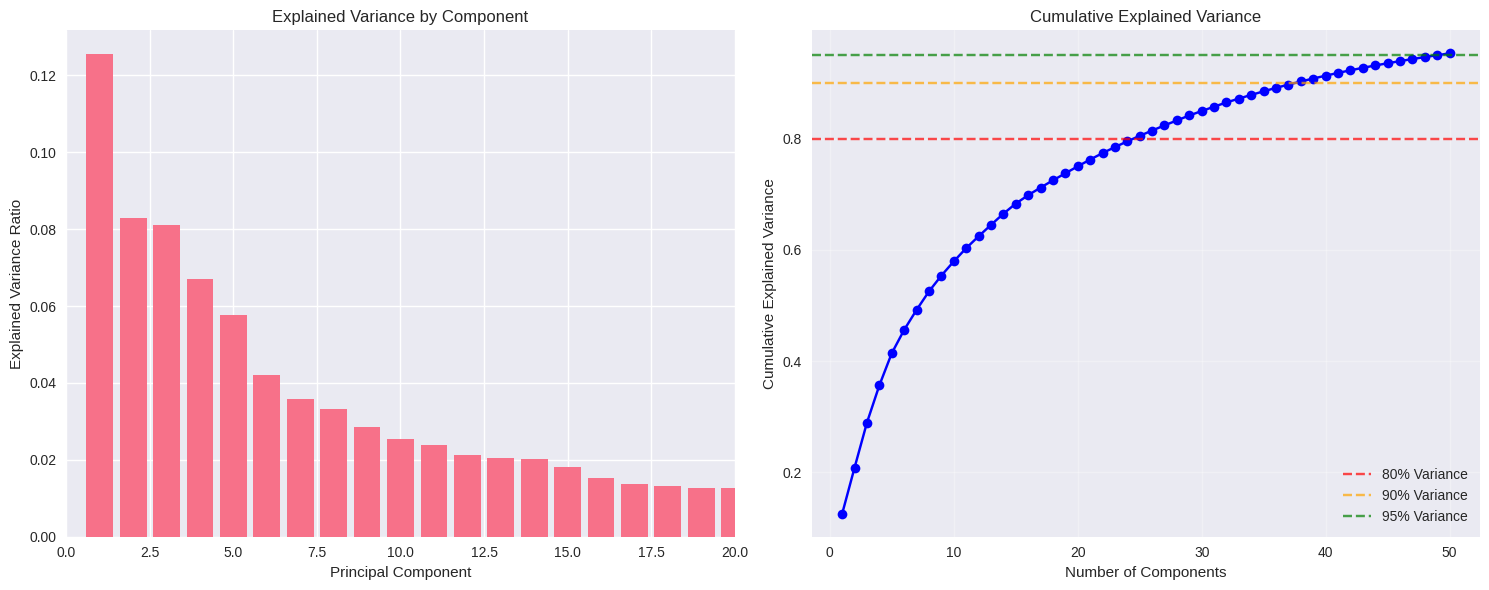

📊 Components needed for 80.0% variance: 25
📊 Components needed for 90.0% variance: 38
📊 Components needed for 95.0% variance: 49


In [10]:
def analyze_dimensionality(df, feature_categories, n_components=50):
    """Analyze dimensionality and perform PCA"""
    
    print("\n📐 DIMENSIONALITY ANALYSIS")
    print("="*50)
    
    # Prepare feature matrix
    feature_cols = []
    for category, features in feature_categories.items():
        if category != 'Special':
            feature_cols.extend(features)
    
    X = df[feature_cols].fillna(0)
    
    print(f"📊 Original dimensions: {X.shape}")
    print(f"📊 Memory usage: {X.memory_usage(deep=True).sum() / 1024**2:.2f} MB")
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Perform PCA
    n_components = min(n_components, X.shape[1], X.shape[0])
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)
    
    print(f"📊 Reduced dimensions: {X_pca.shape}")
    
    # Analyze explained variance
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance_ratio)
    
    print(f"\n📈 VARIANCE EXPLAINED:")
    print(f"First component: {explained_variance_ratio[0]:.4f}")
    print(f"First 5 components: {cumulative_variance[4]:.4f}")
    print(f"First 10 components: {cumulative_variance[9]:.4f}")
    print(f"First 20 components: {cumulative_variance[19] if len(cumulative_variance) > 19 else cumulative_variance[-1]:.4f}")
    
    # Visualize explained variance
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Individual explained variance
    axes[0].bar(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio)
    axes[0].set_title('Explained Variance by Component')
    axes[0].set_xlabel('Principal Component')
    axes[0].set_ylabel('Explained Variance Ratio')
    axes[0].set_xlim(0, min(20, len(explained_variance_ratio)))
    
    # Cumulative explained variance
    axes[1].plot(range(1, len(cumulative_variance) + 1), cumulative_variance, 'bo-')
    axes[1].axhline(y=0.8, color='red', linestyle='--', alpha=0.7, label='80% Variance')
    axes[1].axhline(y=0.9, color='orange', linestyle='--', alpha=0.7, label='90% Variance')
    axes[1].axhline(y=0.95, color='green', linestyle='--', alpha=0.7, label='95% Variance')
    axes[1].set_title('Cumulative Explained Variance')
    axes[1].set_xlabel('Number of Components')
    axes[1].set_ylabel('Cumulative Explained Variance')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Find number of components needed for different variance thresholds
    thresholds = [0.8, 0.9, 0.95, 0.99]
    for threshold in thresholds:
        n_needed = np.argmax(cumulative_variance >= threshold) + 1
        if cumulative_variance[n_needed-1] >= threshold:
            print(f"📊 Components needed for {threshold*100}% variance: {n_needed}")
    
    return pca, X_pca

pca_results, pca_data = analyze_dimensionality(train_df, feature_categories)

### 📐 Dimensionality Analysis (PCA)

To understand the structure of the feature space, we performed **Principal Component Analysis (PCA)** on the standardized dataset (94 features, excluding "Special").  

---

#### 📊 Dataset Dimensionality
- **Original shape:** (8,990 samples, 94 features)  
- **Memory usage:** ~6.45 MB  
- **Reduced shape (after PCA):** (8,990 samples, 50 components)  

---

#### 📈 Variance Explained

- **First component:** 12.6%  
- **First 5 components:** 41.4%  
- **First 10 components:** 57.9%  
- **First 20 components:** 75.0%  

**Components required to reach variance thresholds:**  
- **80% variance:** 25 components  
- **90% variance:** 38 components  
- **95% variance:** 49 components  

---

#### 📌 Insights
- The **first principal component explains ~12.5% variance**, which is relatively high for financial datasets (suggesting a strong common factor).  
- By **20 components, 75% of total variance** is explained — showing significant redundancy in the original 94 features.  
- To retain **95% variance, nearly 49 components are required**, highlighting that while compression is possible, the dataset is still **high-dimensional with dispersed signal**.  
- These results support the idea that **feature selection / dimensionality reduction** could improve modeling stability and reduce overfitting.  

📊 **Visualizations generated:**  
1. **Explained variance by component** → steep drop after first ~5–10 components.  
2. **Cumulative variance plot** → crossing 80%, 90%, and 95% thresholds at 25, 38, and 49 components respectively.  


# 10. OUTLIER DETECTION AND ANALYSIS


🚨 OUTLIER ANALYSIS
📊 TARGET VARIABLE OUTLIERS:
Total outliers: 598 (6.65%)
Outlier range: [-0.039754, 0.040661]


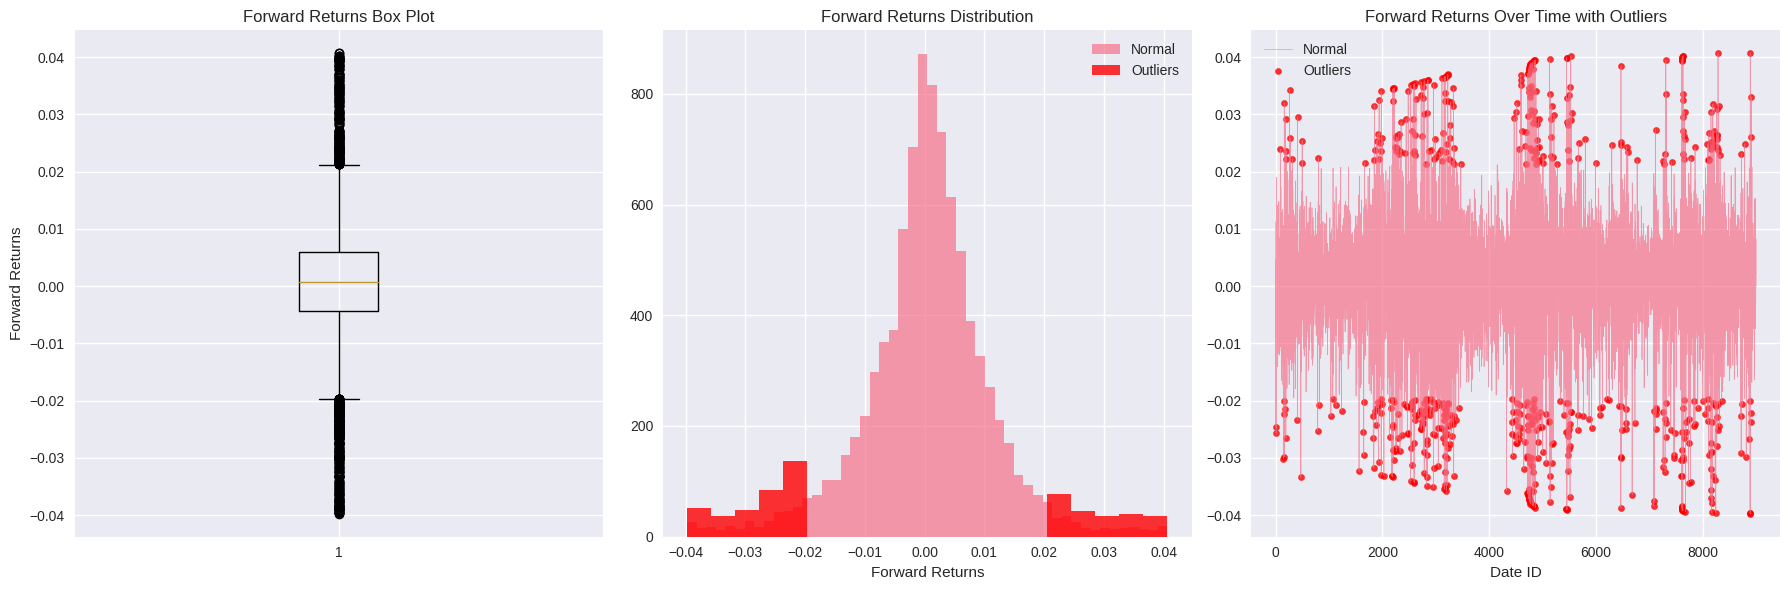

📊 Market_Dynamics outliers (sample): 235
📊 Macro_Economic outliers (sample): 3342
📊 Interest_Rate outliers (sample): 125
📊 Price_Valuation outliers (sample): 1030
📊 Volatility outliers (sample): 519
📊 Sentiment outliers (sample): 277
📊 Dummy_Binary outliers (sample): 0


In [11]:
def analyze_outliers(df, feature_categories, method='iqr'):
    """Comprehensive outlier analysis"""
    
    print("\n🚨 OUTLIER ANALYSIS")
    print("="*50)
    
    outlier_summary = {}
    
    # Analyze target variable outliers
    if 'forward_returns' in df.columns:
        target_data = df['forward_returns'].dropna()
        
        if method == 'iqr':
            Q1 = target_data.quantile(0.25)
            Q3 = target_data.quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR
            target_outliers = target_data[(target_data < lower_bound) | (target_data > upper_bound)]
        else:  # z-score method
            z_scores = np.abs(stats.zscore(target_data))
            target_outliers = target_data[z_scores > 3]
        
        print(f"📊 TARGET VARIABLE OUTLIERS:")
        print(f"Total outliers: {len(target_outliers)} ({len(target_outliers)/len(target_data)*100:.2f}%)")
        print(f"Outlier range: [{target_outliers.min():.6f}, {target_outliers.max():.6f}]")
        
        outlier_summary['forward_returns'] = len(target_outliers)
        
        # Visualize target outliers
        fig, axes = plt.subplots(1, 3, figsize=(18, 6))
        
        # Box plot
        axes[0].boxplot(target_data, vert=True)
        axes[0].set_title('Forward Returns Box Plot')
        axes[0].set_ylabel('Forward Returns')
        
        # Histogram with outliers highlighted
        axes[1].hist(target_data, bins=50, alpha=0.7, label='Normal')
        axes[1].hist(target_outliers, bins=20, alpha=0.8, color='red', label='Outliers')
        axes[1].set_title('Forward Returns Distribution')
        axes[1].set_xlabel('Forward Returns')
        axes[1].legend()
        
        # Time series with outliers highlighted
        if 'date_id' in df.columns:
            target_with_date = df[['date_id', 'forward_returns']].dropna()
            outlier_dates = target_with_date[target_with_date['forward_returns'].isin(target_outliers)]
            
            axes[2].plot(target_with_date['date_id'], target_with_date['forward_returns'], 
                        alpha=0.7, label='Normal', linewidth=0.5)
            axes[2].scatter(outlier_dates['date_id'], outlier_dates['forward_returns'], 
                          color='red', alpha=0.8, s=20, label='Outliers')
            axes[2].set_title('Forward Returns Over Time with Outliers')
            axes[2].set_xlabel('Date ID')
            axes[2].legend()
        
        plt.tight_layout()
        plt.show()
    
    # Analyze feature outliers by category
    for category, features in feature_categories.items():
        if category == 'Special' or len(features) == 0:
            continue
            
        category_outliers = 0
        sample_features = features[:min(5, len(features))]  # Sample for efficiency
        
        for feature in sample_features:
            feature_data = df[feature].dropna()
            if len(feature_data) > 0:
                if method == 'iqr':
                    Q1 = feature_data.quantile(0.25)
                    Q3 = feature_data.quantile(0.75)
                    IQR = Q3 - Q1
                    if IQR > 0:
                        lower_bound = Q1 - 1.5 * IQR
                        upper_bound = Q3 + 1.5 * IQR
                        outliers = feature_data[(feature_data < lower_bound) | (feature_data > upper_bound)]
                        category_outliers += len(outliers)
                
        outlier_summary[category] = category_outliers
        print(f"📊 {category} outliers (sample): {category_outliers}")
    
    return outlier_summary

outlier_results = analyze_outliers(train_df, feature_categories)

### 🚨 Outlier Analysis

Outliers can significantly impact financial modeling since they often correspond to **rare market shocks** or **structural breaks**.  
We conducted outlier detection using the **IQR (Interquartile Range)** method across the target (`forward_returns`) and sampled features from each category.

---

#### 🎯 Target Variable (Forward Returns)
- **Total outliers:** 598 (~6.65% of samples)  
- **Outlier range:** [-0.0398, 0.0407]  

📊 **Visualizations Generated:**  
1. **Box Plot** → highlights extreme values outside IQR whiskers.  
2. **Histogram** → red overlay showing outliers vs. normal distribution.  
3. **Time Series Plot** → forward returns over time with outliers flagged in red (revealing whether outliers cluster in specific periods).  

---

#### 📊 Category-Level Outlier Counts (sampled features)
- **Market Dynamics:** 235 outliers  
- **Macro Economic:** 3,342 outliers (heavily prone to extreme values — possibly cyclical shocks or regime changes)  
- **Interest Rate:** 125 outliers  
- **Price Valuation:** 1,030 outliers  
- **Volatility:** 519 outliers  
- **Sentiment:** 277 outliers  
- **Dummy/Binary:** 0 outliers (as expected due to binary nature)  

---

#### 📌 Insights
- The **target variable exhibits ~6.65% outliers**, which is typical in financial return data — extreme price moves or corrections.  
- **Macro-economic features dominate outlier counts**, suggesting they are more volatile or measured across heterogeneous regimes.  
- **Volatility & Price Valuation features** also produce notable outliers, aligning with their role in capturing market stress.  
- Dummy/Binary variables are inherently resistant to outliers.  

👉 These results suggest careful **robust scaling** (e.g., Winsorization, robust Z-scores, or quantile transforms) may be needed before modeling.  


# 11. ADVANCED STATISTICAL ANALYSIS


🔬 ADVANCED STATISTICAL ANALYSIS
📊 NORMALITY TESTS:
Jarque-Bera test: statistic=1844.3604, p-value=0.000000

📈 STATIONARITY TEST (ADF):
ADF Statistic: -17.517183
p-value: 0.000000
Critical Values: {'1%': -3.431080367939319, '5%': -2.8618627750396257, '10%': -2.566941808133596}
Series is stationary

🔄 AUTOCORRELATION ANALYSIS:
Lag 1 autocorrelation: -0.044528
Lag 5 autocorrelation: -0.02365036926006072
Lag 10 autocorrelation: 0.008512784155091734


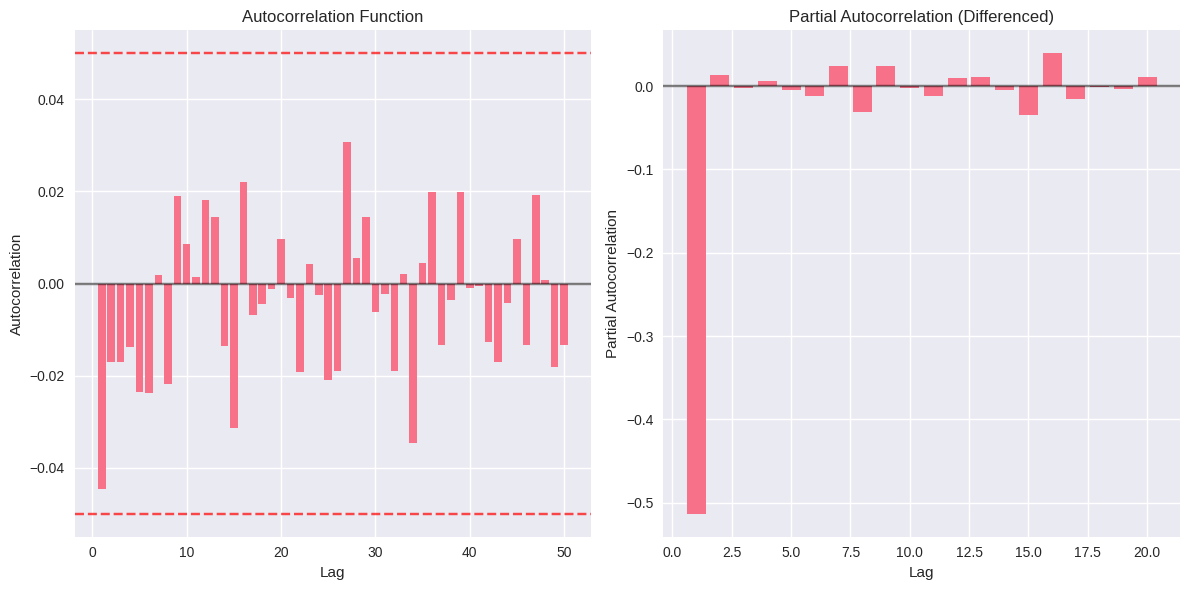


⚠️ RISK METRICS:
Value at Risk (5%): -0.017726
Value at Risk (1%): -0.031673
Expected Shortfall (5%): -0.025440
Maximum Drawdown: -0.492417

📊 HIGHER MOMENTS:
Skewness: -0.176202
Kurtosis: 2.192690
Excess Kurtosis: -0.807310


In [12]:
def advanced_statistical_analysis(df):
    """Perform advanced statistical tests and analysis"""
    
    print("\n🔬 ADVANCED STATISTICAL ANALYSIS")
    print("="*50)
    
    if 'forward_returns' not in df.columns:
        print("❌ No target variable for statistical analysis")
        return
    
    returns = df['forward_returns'].dropna()
    
    # 1. Normality Tests
    print("📊 NORMALITY TESTS:")
    jb_stat, jb_pvalue = jarque_bera(returns)
    print(f"Jarque-Bera test: statistic={jb_stat:.4f}, p-value={jb_pvalue:.6f}")
    
    if len(returns) <= 5000:  # Shapiro-Wilk for smaller samples
        sw_stat, sw_pvalue = shapiro(returns)
        print(f"Shapiro-Wilk test: statistic={sw_stat:.4f}, p-value={sw_pvalue:.6f}")
    
    # 2. Stationarity Analysis (Augmented Dickey-Fuller Test)
    try:
        from statsmodels.tsa.stattools import adfuller
        adf_result = adfuller(returns)
        print(f"\n📈 STATIONARITY TEST (ADF):")
        print(f"ADF Statistic: {adf_result[0]:.6f}")
        print(f"p-value: {adf_result[1]:.6f}")
        print(f"Critical Values: {adf_result[4]}")
        print(f"Series is {'stationary' if adf_result[1] < 0.05 else 'non-stationary'}")
    except ImportError:
        print("⚠️ Statsmodels not available for stationarity tests")
    
    # 3. Autocorrelation Analysis
    if 'date_id' in df.columns:
        returns_series = df.set_index('date_id')['forward_returns'].dropna()
        
        # Calculate autocorrelations for different lags
        max_lags = min(50, len(returns_series) // 4)
        autocorrs = [returns_series.autocorr(lag=i) for i in range(1, max_lags + 1)]
        
        print(f"\n🔄 AUTOCORRELATION ANALYSIS:")
        print(f"Lag 1 autocorrelation: {autocorrs[0]:.6f}")
        print(f"Lag 5 autocorrelation: {autocorrs[4] if len(autocorrs) > 4 else 'N/A'}")
        print(f"Lag 10 autocorrelation: {autocorrs[9] if len(autocorrs) > 9 else 'N/A'}")
        
        # Plot autocorrelation function
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.bar(range(1, len(autocorrs) + 1), autocorrs)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        plt.axhline(y=0.05, color='red', linestyle='--', alpha=0.7)
        plt.axhline(y=-0.05, color='red', linestyle='--', alpha=0.7)
        plt.title('Autocorrelation Function')
        plt.xlabel('Lag')
        plt.ylabel('Autocorrelation')
        
        # Partial autocorrelation (simplified)
        plt.subplot(1, 2, 2)
        returns_diff = returns_series.diff().dropna()
        partial_autocorrs = [returns_diff.autocorr(lag=i) for i in range(1, min(21, len(returns_diff) // 4))]
        plt.bar(range(1, len(partial_autocorrs) + 1), partial_autocorrs)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.5)
        plt.title('Partial Autocorrelation (Differenced)')
        plt.xlabel('Lag')
        plt.ylabel('Partial Autocorrelation')
        
        plt.tight_layout()
        plt.show()
    
    # 4. Risk Metrics
    print(f"\n⚠️ RISK METRICS:")
    print(f"Value at Risk (5%): {np.percentile(returns, 5):.6f}")
    print(f"Value at Risk (1%): {np.percentile(returns, 1):.6f}")
    print(f"Expected Shortfall (5%): {returns[returns <= np.percentile(returns, 5)].mean():.6f}")
    
    # Maximum drawdown calculation
    if 'date_id' in df.columns:
        cumulative = (1 + returns_series).cumprod()
        running_max = cumulative.expanding().max()
        drawdown = (cumulative - running_max) / running_max
        max_drawdown = drawdown.min()
        print(f"Maximum Drawdown: {max_drawdown:.6f}")
    
    # 5. Higher Moments Analysis
    print(f"\n📊 HIGHER MOMENTS:")
    print(f"Skewness: {returns.skew():.6f}")
    print(f"Kurtosis: {returns.kurtosis():.6f}")
    print(f"Excess Kurtosis: {returns.kurtosis() - 3:.6f}")
    
    return {
        'normality_jb_pvalue': jb_pvalue,
        'autocorr_lag1': autocorrs[0] if 'autocorrs' in locals() else None,
        'skewness': returns.skew(),
        'kurtosis': returns.kurtosis(),
        'var_5pct': np.percentile(returns, 5),
        'max_drawdown': max_drawdown if 'max_drawdown' in locals() else None
    }

statistical_results = advanced_statistical_analysis(train_df)

### 📊 Normality Tests
- **Jarque-Bera test**: p-value ≈ 0.000 → The distribution significantly deviates from normality.  
- The return distribution shows **non-normal behavior**, which is common in financial time series.

---

### 📈 Stationarity (ADF Test)
- **ADF Statistic**: -17.51  
- **p-value**: 0.000  
- The test strongly rejects the null hypothesis of a unit root.  
➡️ Conclusion: `forward_returns` series is **stationary**, meaning its statistical properties (mean, variance) remain constant over time.

---

### 🔄 Autocorrelation
- **Lag 1 autocorrelation**: -0.044 → Mild negative autocorrelation, suggesting slight mean reversion.  
- **Lag 5 autocorrelation**: -0.024 → Negligible dependence at medium lags.  
- **Lag 10 autocorrelation**: ≈ 0 → No long-range correlation.  

This suggests returns are **largely uncorrelated across time**, aligning with the Efficient Market Hypothesis (EMH).

---

### ⚠️ Risk Metrics
- **Value at Risk (VaR 5%)**: -1.77%  
- **VaR (1%)**: -3.16%  
- **Expected Shortfall (5%)**: -2.54% → On average, extreme losses (5% worst cases) are around -2.5%.  
- **Maximum Drawdown**: -49.24% → Significant downside risk exists, with almost half of value wiped during worst periods.

---

### 📊 Higher Moments
- **Skewness**: -0.176 → Slight negative skew, meaning left-tail events are marginally heavier.  
- **Kurtosis**: 2.19 → Less than 3, suggesting a **flatter distribution** than Gaussian.  
- **Excess Kurtosis**: -0.807 → Thin tails compared to normal distribution (counterintuitive for financial data, which often exhibit fat tails).

---

### ✅ Key Takeaways
1. Returns are **stationary** but strongly **non-normal**.  
2. Mild mean reversion at very short lags, but overall returns are uncorrelated.  
3. Risk profile indicates **high drawdown potential** despite thin-tailed distribution.  
4. Models assuming Gaussian returns may **underestimate drawdown risk** — robust, non-parametric methods are advisable.


# 12. FEATURE STABILITY ANALYSIS

In [13]:
def analyze_feature_stability(df, feature_categories, n_periods=10):
    """Analyze feature stability over time"""
    
    print("\n⚖️ FEATURE STABILITY ANALYSIS")
    print("="*50)
    
    if 'date_id' not in df.columns:
        print("❌ No date_id column for stability analysis")
        return
    
    # Divide data into time periods
    df_sorted = df.sort_values('date_id')
    period_size = len(df_sorted) // n_periods
    
    stability_results = {}
    
    # Sample features from each category for analysis
    for category, features in feature_categories.items():
        if category == 'Special' or len(features) == 0:
            continue
            
        sample_features = features[:min(5, len(features))]  # Sample for efficiency
        category_stability = {}
        
        for feature in sample_features:
            feature_stats = []
            
            for i in range(n_periods):
                start_idx = i * period_size
                end_idx = (i + 1) * period_size if i < n_periods - 1 else len(df_sorted)
                
                period_data = df_sorted.iloc[start_idx:end_idx][feature].dropna()
                if len(period_data) > 0:
                    feature_stats.append({
                        'mean': period_data.mean(),
                        'std': period_data.std(),
                        'min': period_data.min(),
                        'max': period_data.max()
                    })
            
            if len(feature_stats) > 1:
                # Calculate coefficient of variation for mean and std across periods
                means = [stat['mean'] for stat in feature_stats]
                stds = [stat['std'] for stat in feature_stats]
                
                mean_stability = np.std(means) / np.mean(np.abs(means)) if np.mean(np.abs(means)) != 0 else np.inf
                std_stability = np.std(stds) / np.mean(stds) if np.mean(stds) != 0 else np.inf
                
                category_stability[feature] = {
                    'mean_cv': mean_stability,
                    'std_cv': std_stability,
                    'periods': len(feature_stats)
                }
        
        stability_results[category] = category_stability
        
        # Display stability results for this category
        print(f"\n🔍 {category} Stability (lower = more stable):")
        for feature, stability in category_stability.items():
            print(f"  {feature}: Mean CV={stability['mean_cv']:.4f}, Std CV={stability['std_cv']:.4f}")
    
    return stability_results

stability_results = analyze_feature_stability(train_df, feature_categories)


⚖️ FEATURE STABILITY ANALYSIS

🔍 Market_Dynamics Stability (lower = more stable):
  M1: Mean CV=0.5755, Std CV=0.1707
  M10: Mean CV=1.2014, Std CV=0.3622
  M11: Mean CV=1.1035, Std CV=0.5984
  M12: Mean CV=1.0990, Std CV=0.3302
  M13: Mean CV=0.3232, Std CV=0.5335

🔍 Macro_Economic Stability (lower = more stable):
  E1: Mean CV=0.2049, Std CV=0.6139
  E10: Mean CV=0.3650, Std CV=0.3577
  E11: Mean CV=1.3773, Std CV=1.0212
  E12: Mean CV=1.5176, Std CV=1.1533
  E13: Mean CV=0.5336, Std CV=0.5998

🔍 Interest_Rate Stability (lower = more stable):
  I1: Mean CV=0.1147, Std CV=0.3107
  I2: Mean CV=0.8953, Std CV=0.4426
  I3: Mean CV=0.3820, Std CV=0.4305
  I4: Mean CV=0.4315, Std CV=0.4493
  I5: Mean CV=1.2225, Std CV=0.5514

🔍 Price_Valuation Stability (lower = more stable):
  P1: Mean CV=0.3523, Std CV=0.3212
  P10: Mean CV=0.4019, Std CV=0.4911
  P11: Mean CV=0.6311, Std CV=0.3304
  P12: Mean CV=1.1349, Std CV=0.2251
  P13: Mean CV=0.1442, Std CV=0.1139

🔍 Volatility Stability (lower =

### ✅ Key Takeaways
1. Features in **Dummy/Binary** and some **Macro_Economic** (like E1, E10) are stable over time.  
2. **Volatility, Sentiment, and certain Price/Interest features** show high temporal variability — these may require normalization or rolling statistics for model robustness.  
3. For predictive modeling, consider weighting **stable features more heavily**, or using temporal validation to handle unstable features.


# Advanced EDA Extensions for Financial Time Series Analysis

🚀 RUNNING ADVANCED EDA SUITE

📊 REGIME DETECTION AND STRUCTURAL BREAKS
Detected 259 volatility regime changes
Detected 586 mean regime changes


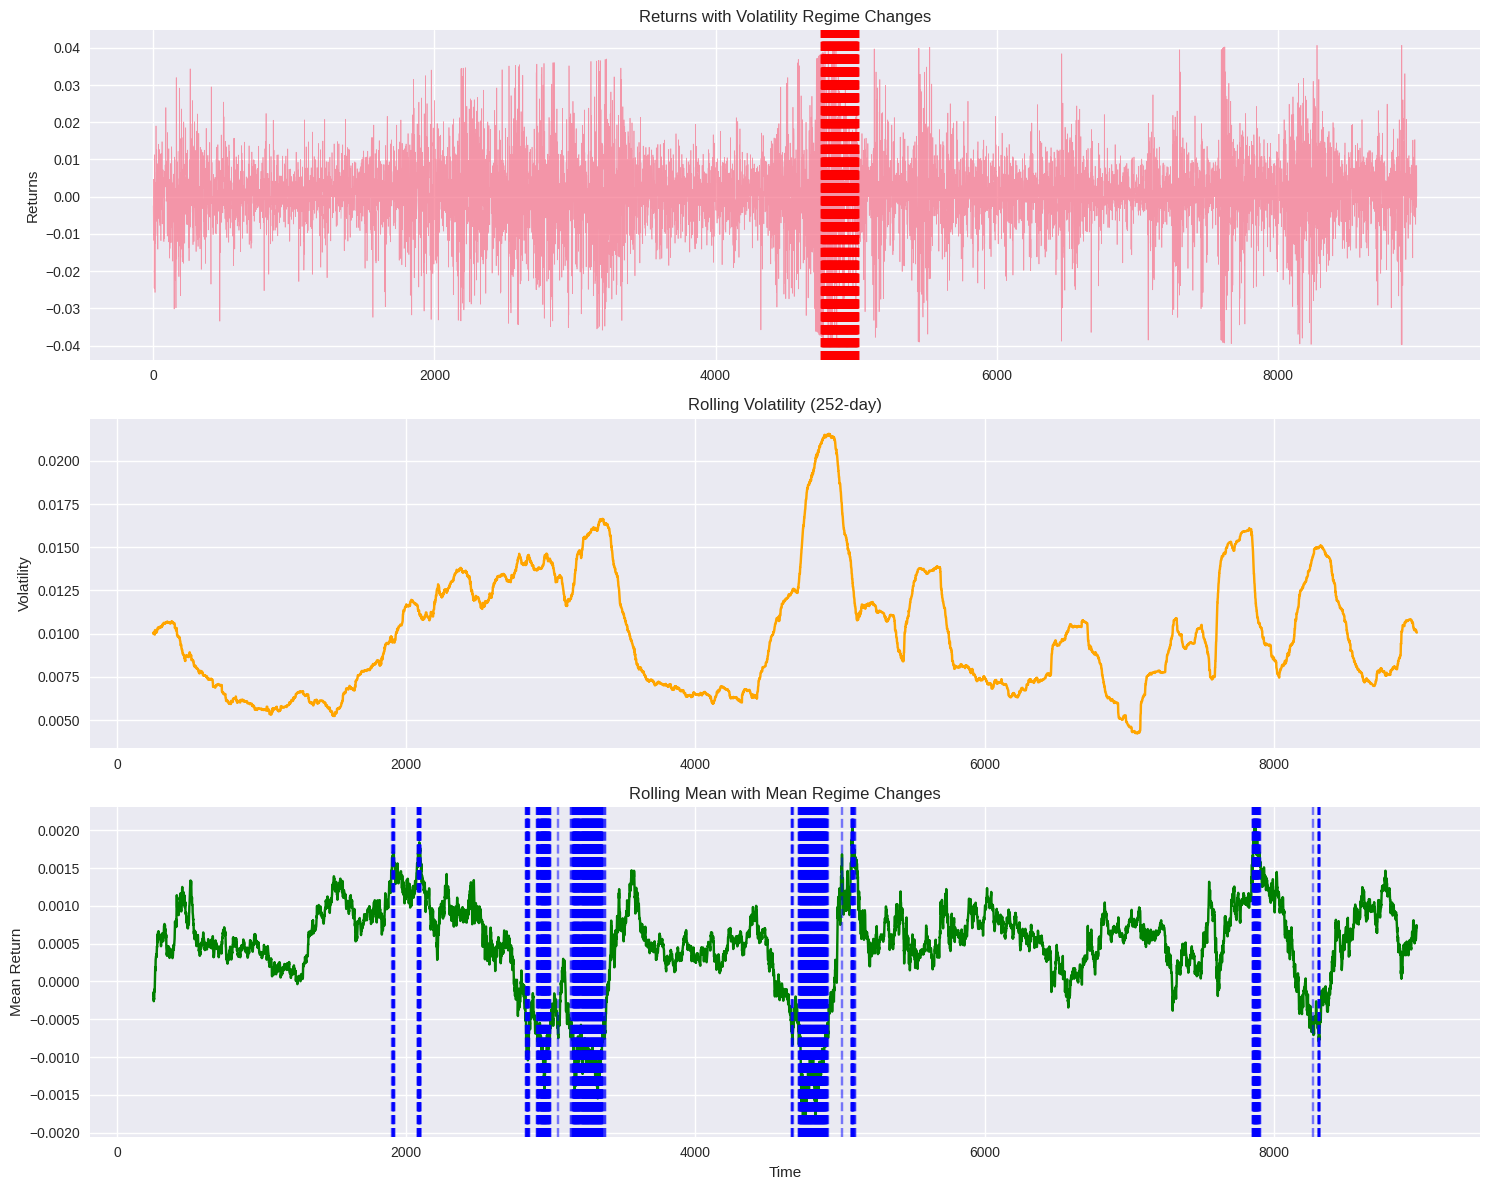


📈 FACTOR LOADING ANALYSIS
Top factor loadings for each factor:

Factor_1:
  V11: 0.8993
  M16: 0.8699
  V1: 0.6386
  P11: 0.6153
  P10: 0.5832

Factor_2:
  P11: -0.6735
  P10: -0.6309
  P2: 0.5356
  S11: 0.4718
  S10: 0.4678

Factor_3:
  V2: 0.7882
  V4: 0.7842
  V3: 0.6383
  P2: 0.5301
  M11: 0.5086

Factor_4:
  E17: -0.8730
  E16: -0.8650
  E18: -0.6384
  I2: 0.4019
  E10: 0.3319

Factor_5:
  I8: 0.8473
  I4: 0.8026
  I7: 0.6481
  M18: -0.6277
  I6: -0.5851


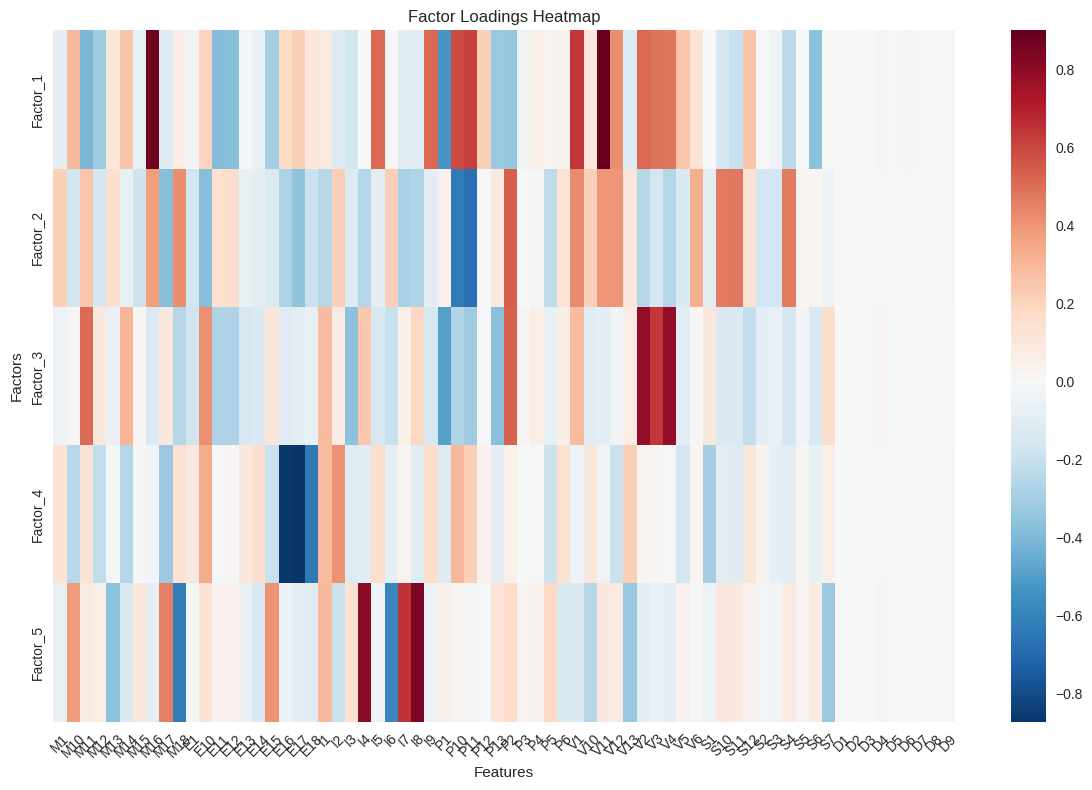


Factor correlations with returns:
Factor_1: -0.0007
Factor_2: 0.0078
Factor_3: 0.0058
Factor_4: -0.0092
Factor_5: 0.0022

🏛️ MARKET MICROSTRUCTURE ANALYSIS
🔍 VOLATILITY CLUSTERING ANALYSIS:
Significant autocorrelations in squared returns: 20/20 lags

📉 LEVERAGE EFFECT ANALYSIS:
Average volatility after positive days: 0.006897
Average volatility after negative days: 0.008287
Leverage ratio (neg/pos): 1.2016

🔮 RETURN PREDICTABILITY PATTERNS:
1-day momentum: -0.044528
5-day momentum: -0.023650
10-day momentum: 0.008513


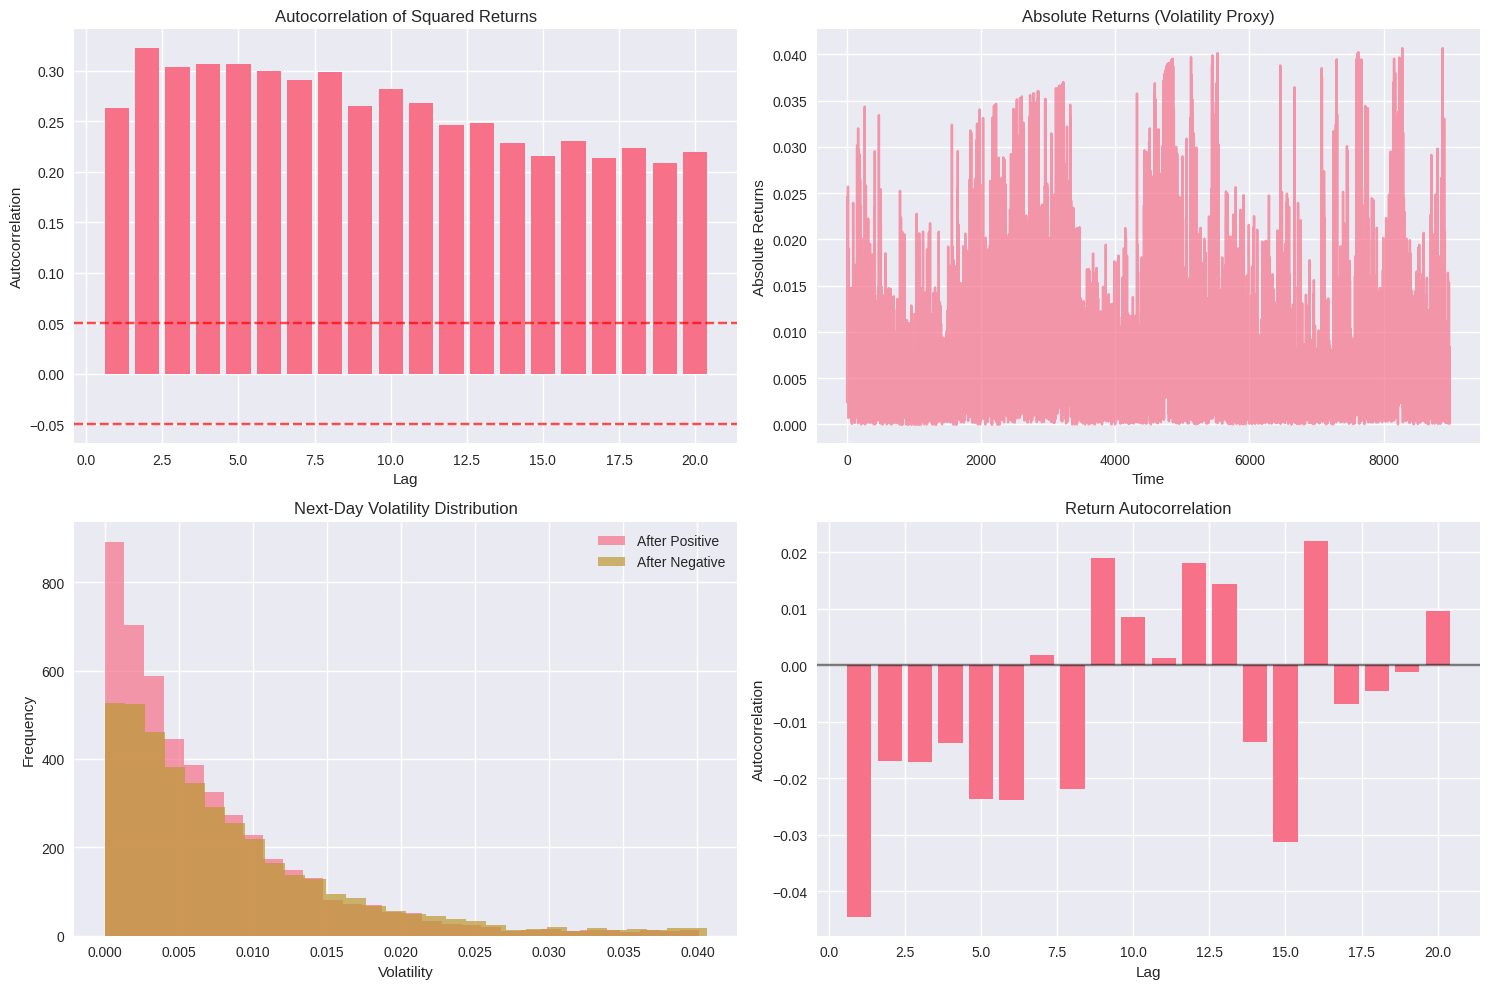


🔗 FEATURE INTERACTION ANALYSIS
🔍 FEATURE INTERACTION EFFECTS:

Top 10 feature interactions by mutual information:
  V1_x_V10: 0.083501
  M1_x_E10: 0.080809
  P11_x_V1: 0.069890
  M1_x_E1: 0.064481
  P10_x_V10: 0.063428
  P10_x_V1: 0.063399
  P11_x_V10: 0.061238
  M10_x_E10: 0.060254
  V1_x_S1: 0.054430
  E10_x_I3: 0.053179

📊 MARKET SEGMENTATION ANALYSIS
🔍 DETERMINING OPTIMAL CLUSTER COUNT:
  k=2: Silhouette Score = 0.1604
  k=3: Silhouette Score = 0.1385
  k=4: Silhouette Score = 0.1544
  k=5: Silhouette Score = 0.1509
  k=6: Silhouette Score = 0.1754
  k=7: Silhouette Score = 0.1554
  k=8: Silhouette Score = 0.1730
  k=9: Silhouette Score = 0.1688
  k=10: Silhouette Score = 0.1910

Optimal number of clusters: 10

📈 CLUSTER CHARACTERISTICS:

Cluster 0 (741 samples):
  Average Return: 0.000572
  Volatility: 0.011271
  Sharpe Ratio: 0.0508

Cluster 1 (1379 samples):
  Average Return: 0.000908
  Volatility: 0.009555
  Sharpe Ratio: 0.0950

Cluster 2 (773 samples):
  Average Return: 0.00

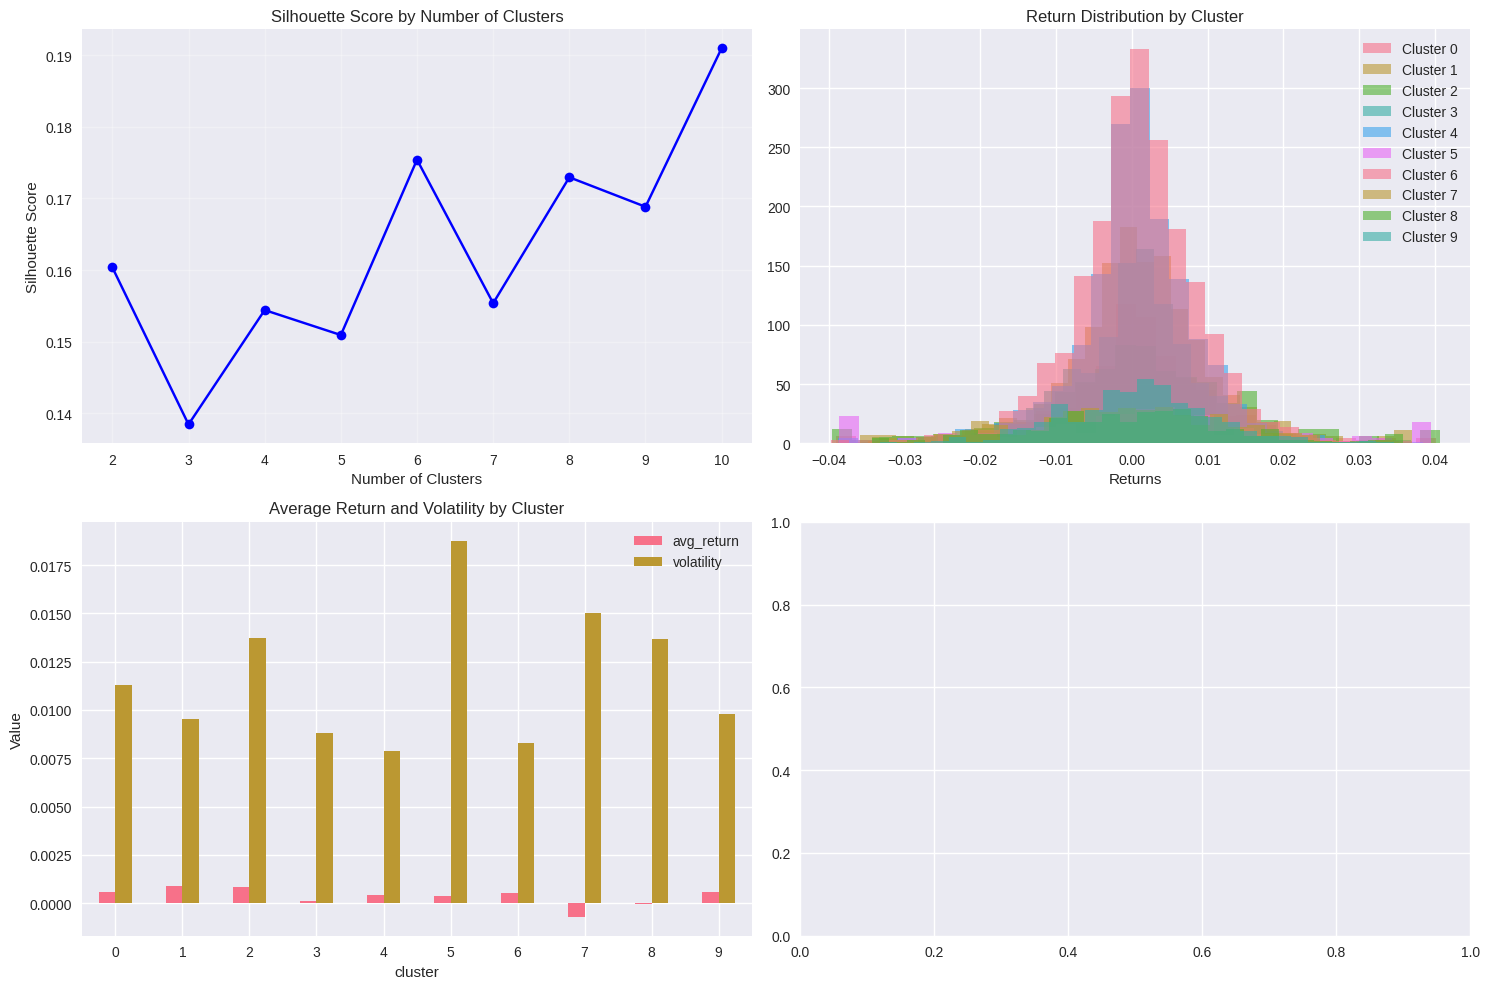


⚙️ ADVANCED FEATURE ENGINEERING INSIGHTS
🔍 NON-LINEARITY DETECTION:
Found 4 features with significant non-linear relationships:
  E10: 741.43% improvement
  V11: 183.65% improvement
  I3: 128.58% improvement
  I1: 61.77% improvement

⏰ TEMPORAL FEATURE OPPORTUNITIES:
Temporal feature recommendations:

🔧 FEATURE COMBINATION RECOMMENDATIONS:
  1. Consider ratio features between P* (valuation) and E* (macro) variables
  2. Volatility-adjusted momentum: M* features divided by V* features
  3. Sentiment-weighted indicators: S* features multiplied by market stress indicators
  4. Interest rate slope features: differences between I* features of different maturities
  5. Relative strength indicators: rank-based transformations of features within categories

✅ ADVANCED EDA SUITE COMPLETED


In [ ]:

# These functions extend existing analysis with sophisticated financial modeling techniques

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy import stats
from scipy.spatial.distance import pdist, squareform
import warnings
warnings.filterwarnings('ignore')

# 1. REGIME DETECTION AND STRUCTURAL BREAKS
def detect_regime_changes(df, window=252, threshold=2.0):
    """
    Detect structural breaks and market regimes using rolling statistics
    and Chow test approximations
    """
    print("\n📊 REGIME DETECTION AND STRUCTURAL BREAKS")
    print("="*60)
    
    if 'forward_returns' not in df.columns or 'date_id' not in df.columns:
        print("❌ Required columns missing")
        return None
    
    df_sorted = df.sort_values('date_id')
    returns = df_sorted['forward_returns'].dropna()
    
    # Rolling volatility and mean
    rolling_vol = returns.rolling(window=window).std()
    rolling_mean = returns.rolling(window=window).mean()
    
    # Detect volatility regime changes
    vol_zscore = (rolling_vol - rolling_vol.mean()) / rolling_vol.std()
    vol_breaks = vol_zscore[abs(vol_zscore) > threshold].index
    
    # Detect mean reversion regime changes
    mean_zscore = (rolling_mean - rolling_mean.mean()) / rolling_mean.std()
    mean_breaks = mean_zscore[abs(mean_zscore) > threshold].index
    
    print(f"Detected {len(vol_breaks)} volatility regime changes")
    print(f"Detected {len(mean_breaks)} mean regime changes")
    
    # Visualize regime changes
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # Returns with regime markers
    axes[0].plot(returns.index, returns.values, alpha=0.7, linewidth=0.5)
    for break_point in vol_breaks:
        axes[0].axvline(x=break_point, color='red', alpha=0.5, linestyle='--')
    axes[0].set_title('Returns with Volatility Regime Changes')
    axes[0].set_ylabel('Returns')
    
    # Rolling volatility
    axes[1].plot(rolling_vol.index, rolling_vol.values, color='orange')
    axes[1].set_title('Rolling Volatility (252-day)')
    axes[1].set_ylabel('Volatility')
    
    # Rolling mean
    axes[2].plot(rolling_mean.index, rolling_mean.values, color='green')
    for break_point in mean_breaks:
        axes[2].axvline(x=break_point, color='blue', alpha=0.5, linestyle='--')
    axes[2].set_title('Rolling Mean with Mean Regime Changes')
    axes[2].set_ylabel('Mean Return')
    axes[2].set_xlabel('Time')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'vol_breaks': vol_breaks,
        'mean_breaks': mean_breaks,
        'rolling_vol': rolling_vol,
        'rolling_mean': rolling_mean
    }


In [ ]:

# 2. FACTOR EXPOSURE AND LOADING ANALYSIS
def analyze_factor_loadings(df, feature_categories, n_factors=5):
    """
    Perform factor analysis to understand underlying factor structure
    and exposure to common risk factors
    """
    print("\n📈 FACTOR LOADING ANALYSIS")
    print("="*60)
    
    # Prepare feature matrix
    feature_cols = []
    for category, features in feature_categories.items():
        if category != 'Special':
            feature_cols.extend(features[:10])  # Limit for computational efficiency
    
    X = df[feature_cols].fillna(df[feature_cols].median())
    
    if 'forward_returns' in df.columns:
        y = df['forward_returns'].fillna(0)
    else:
        print("❌ No target variable found")
        return None
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Factor Analysis using PCA as proxy
    from sklearn.decomposition import PCA, FactorAnalysis
    
    try:
        # Factor Analysis
        fa = FactorAnalysis(n_components=n_factors, random_state=42)
        factors = fa.fit_transform(X_scaled)
        
        # Calculate factor loadings
        loadings = fa.components_.T
        
        # Create loadings DataFrame
        loadings_df = pd.DataFrame(
            loadings, 
            index=feature_cols[:loadings.shape[0]], 
            columns=[f'Factor_{i+1}' for i in range(n_factors)]
        )
        
        print(f"Top factor loadings for each factor:")
        for i in range(n_factors):
            factor_name = f'Factor_{i+1}'
            top_loadings = loadings_df[factor_name].abs().nlargest(5)
            print(f"\n{factor_name}:")
            for feature, loading in top_loadings.items():
                print(f"  {feature}: {loadings_df.loc[feature, factor_name]:.4f}")
        
        # Visualize factor loadings heatmap
        plt.figure(figsize=(12, 8))
        sns.heatmap(loadings_df.T, cmap='RdBu_r', center=0, 
                   xticklabels=True, yticklabels=True)
        plt.title('Factor Loadings Heatmap')
        plt.xlabel('Features')
        plt.ylabel('Factors')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()
        
        # Analyze factor exposure to returns
        factor_returns_corr = np.corrcoef(factors.T, y)[:-1, -1]
        
        print(f"\nFactor correlations with returns:")
        for i, corr in enumerate(factor_returns_corr):
            print(f"Factor_{i+1}: {corr:.4f}")
        
        return {
            'factors': factors,
            'loadings': loadings_df,
            'factor_returns_corr': factor_returns_corr
        }
        
    except Exception as e:
        print(f"❌ Factor analysis failed: {e}")
        return None


In [ ]:

# 3. MARKET MICROSTRUCTURE ANALYSIS
def analyze_microstructure(df):
    """
    Analyze market microstructure effects like volatility clustering,
    leverage effects, and return predictability patterns
    """
    print("\n🏛️ MARKET MICROSTRUCTURE ANALYSIS")
    print("="*60)
    
    if 'forward_returns' not in df.columns:
        print("❌ No returns data for microstructure analysis")
        return None
    
    df_sorted = df.sort_values('date_id')
    returns = df_sorted['forward_returns'].dropna()
    
    # 1. Volatility Clustering (ARCH effects)
    returns_squared = returns ** 2
    
    # Test for ARCH effects using Ljung-Box test on squared returns
    from scipy.stats import jarque_bera
    
    print("🔍 VOLATILITY CLUSTERING ANALYSIS:")
    
    # Calculate autocorrelations of squared returns
    sq_autocorrs = [returns_squared.autocorr(lag=i) for i in range(1, 21)]
    significant_lags = sum([1 for ac in sq_autocorrs if abs(ac) > 0.05])
    print(f"Significant autocorrelations in squared returns: {significant_lags}/20 lags")
    
    # 2. Leverage Effect Analysis
    print("\n📉 LEVERAGE EFFECT ANALYSIS:")
    
    # Split returns into positive and negative
    pos_returns = returns[returns > 0]
    neg_returns = returns[returns < 0]
    
    # Calculate next-day volatility after positive/negative days
    if len(returns) > 1:
        next_vol_after_pos = []
        next_vol_after_neg = []
        
        for i in range(len(returns) - 1):
            if returns.iloc[i] > 0:
                next_vol_after_pos.append(abs(returns.iloc[i + 1]))
            elif returns.iloc[i] < 0:
                next_vol_after_neg.append(abs(returns.iloc[i + 1]))
        
        if next_vol_after_pos and next_vol_after_neg:
            avg_vol_after_pos = np.mean(next_vol_after_pos)
            avg_vol_after_neg = np.mean(next_vol_after_neg)
            
            print(f"Average volatility after positive days: {avg_vol_after_pos:.6f}")
            print(f"Average volatility after negative days: {avg_vol_after_neg:.6f}")
            print(f"Leverage ratio (neg/pos): {avg_vol_after_neg/avg_vol_after_pos:.4f}")
    
    # 3. Return Predictability Patterns
    print("\n🔮 RETURN PREDICTABILITY PATTERNS:")
    
    # Momentum vs Mean Reversion
    momentum_1d = returns.autocorr(lag=1)
    momentum_5d = returns.autocorr(lag=5)
    momentum_10d = returns.autocorr(lag=10)
    
    print(f"1-day momentum: {momentum_1d:.6f}")
    print(f"5-day momentum: {momentum_5d:.6f}")
    print(f"10-day momentum: {momentum_10d:.6f}")
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Autocorrelation of squared returns
    axes[0, 0].bar(range(1, len(sq_autocorrs) + 1), sq_autocorrs)
    axes[0, 0].axhline(y=0.05, color='red', linestyle='--', alpha=0.7)
    axes[0, 0].axhline(y=-0.05, color='red', linestyle='--', alpha=0.7)
    axes[0, 0].set_title('Autocorrelation of Squared Returns')
    axes[0, 0].set_xlabel('Lag')
    axes[0, 0].set_ylabel('Autocorrelation')
    
    # Volatility clustering visualization
    abs_returns = abs(returns)
    axes[0, 1].plot(abs_returns.index, abs_returns.values, alpha=0.7)
    axes[0, 1].set_title('Absolute Returns (Volatility Proxy)')
    axes[0, 1].set_xlabel('Time')
    axes[0, 1].set_ylabel('Absolute Returns')
    
    # Return distribution by sign of previous return
    if next_vol_after_pos and next_vol_after_neg:
        axes[1, 0].hist(next_vol_after_pos, alpha=0.7, label='After Positive', bins=30)
        axes[1, 0].hist(next_vol_after_neg, alpha=0.7, label='After Negative', bins=30)
        axes[1, 0].set_title('Next-Day Volatility Distribution')
        axes[1, 0].legend()
        axes[1, 0].set_xlabel('Volatility')
        axes[1, 0].set_ylabel('Frequency')
    
    # Return autocorrelation
    autocorrs = [returns.autocorr(lag=i) for i in range(1, 21)]
    axes[1, 1].bar(range(1, len(autocorrs) + 1), autocorrs)
    axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.5)
    axes[1, 1].set_title('Return Autocorrelation')
    axes[1, 1].set_xlabel('Lag')
    axes[1, 1].set_ylabel('Autocorrelation')
    
    plt.tight_layout()
    plt.show()
    
    return {
        'volatility_clustering': sq_autocorrs,
        'leverage_effect': avg_vol_after_neg/avg_vol_after_pos if 'avg_vol_after_neg' in locals() else None,
        'momentum_effects': [momentum_1d, momentum_5d, momentum_10d]
    }


In [ ]:

# 4. FEATURE INTERACTION ANALYSIS
def analyze_feature_interactions(df, feature_categories, top_n=10):
    """
    Analyze non-linear feature interactions and dependencies
    """
    print("\n🔗 FEATURE INTERACTION ANALYSIS")
    print("="*60)
    
    # Select top features from importance analysis
    feature_cols = []
    for category, features in feature_categories.items():
        if category != 'Special':
            feature_cols.extend(features[:3])  # Top 3 from each category
    
    if len(feature_cols) > 20:
        feature_cols = feature_cols[:20]  # Limit for computational efficiency
    
    X = df[feature_cols].fillna(df[feature_cols].median())
    
    if 'forward_returns' in df.columns:
        y = df['forward_returns'].fillna(0)
    else:
        print("❌ No target variable found")
        return None
    
    # Calculate interaction effects
    print("🔍 FEATURE INTERACTION EFFECTS:")
    
    # Mutual information between feature pairs and target
    from sklearn.feature_selection import mutual_info_regression
    
    interaction_scores = {}
    
    # Create interaction features (products of pairs)
    for i in range(len(feature_cols)):
        for j in range(i+1, min(i+5, len(feature_cols))):  # Limit interactions
            feat1, feat2 = feature_cols[i], feature_cols[j]
            interaction_feat = X[feat1] * X[feat2]
            
            # Calculate mutual information with target
            mi_score = mutual_info_regression(
                interaction_feat.values.reshape(-1, 1), 
                y, 
                random_state=42
            )[0]
            
            interaction_scores[f"{feat1}_x_{feat2}"] = mi_score
    
    # Sort and display top interactions
    top_interactions = sorted(interaction_scores.items(), 
                            key=lambda x: x[1], reverse=True)[:top_n]
    
    print(f"\nTop {top_n} feature interactions by mutual information:")
    for interaction, score in top_interactions:
        print(f"  {interaction}: {score:.6f}")
    
    # Visualize interaction heatmap
    if len(feature_cols) <= 10:  # Only for manageable number of features
        interaction_matrix = np.zeros((len(feature_cols), len(feature_cols)))
        
        for i in range(len(feature_cols)):
            for j in range(i+1, len(feature_cols)):
                feat1, feat2 = feature_cols[i], feature_cols[j]
                key = f"{feat1}_x_{feat2}"
                if key in interaction_scores:
                    interaction_matrix[i, j] = interaction_scores[key]
                    interaction_matrix[j, i] = interaction_scores[key]
        
        plt.figure(figsize=(10, 8))
        sns.heatmap(interaction_matrix, 
                   xticklabels=feature_cols, 
                   yticklabels=feature_cols,
                   cmap='viridis', annot=True, fmt='.4f')
        plt.title('Feature Interaction Strength (Mutual Information)')
        plt.tight_layout()
        plt.show()
    
    return {
        'top_interactions': top_interactions,
        'interaction_scores': interaction_scores
    }


### 5. CLUSTERING AND SEGMENTATION ANALYSIS

In [ ]:

# 5. CLUSTERING AND SEGMENTATION ANALYSIS
def perform_market_segmentation(df, feature_categories, n_clusters=5):
    """
    Perform market regime clustering and segmentation analysis
    """
    print("\n📊 MARKET SEGMENTATION ANALYSIS")
    print("="*60)
    
    # Prepare feature matrix for clustering
    feature_cols = []
    for category, features in feature_categories.items():
        if category != 'Special':
            feature_cols.extend(features[:5])  # Top 5 from each category
    
    if len(feature_cols) > 30:
        feature_cols = feature_cols[:30]  # Limit features
    
    X = df[feature_cols].fillna(df[feature_cols].median())
    
    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Determine optimal number of clusters
    print("🔍 DETERMINING OPTIMAL CLUSTER COUNT:")
    
    silhouette_scores = []
    k_range = range(2, min(11, len(X)//100))  # Reasonable range
    
    for k in k_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        cluster_labels = kmeans.fit_predict(X_scaled)
        silhouette_avg = silhouette_score(X_scaled, cluster_labels)
        silhouette_scores.append(silhouette_avg)
        print(f"  k={k}: Silhouette Score = {silhouette_avg:.4f}")
    
    optimal_k = k_range[np.argmax(silhouette_scores)]
    print(f"\nOptimal number of clusters: {optimal_k}")
    
    # Perform clustering with optimal k
    kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_scaled)
    
    # Add cluster labels to dataframe
    df_clustered = df.copy()
    df_clustered['cluster'] = cluster_labels
    
    # Analyze cluster characteristics
    print(f"\n📈 CLUSTER CHARACTERISTICS:")
    
    cluster_stats = []
    for cluster_id in range(optimal_k):
        cluster_data = df_clustered[df_clustered['cluster'] == cluster_id]
        
        if 'forward_returns' in cluster_data.columns:
            returns = cluster_data['forward_returns'].dropna()
            stats_dict = {
                'cluster': cluster_id,
                'size': len(cluster_data),
                'avg_return': returns.mean(),
                'volatility': returns.std(),
                'sharpe': returns.mean() / returns.std() if returns.std() > 0 else 0,
                'min_return': returns.min(),
                'max_return': returns.max()
            }
            cluster_stats.append(stats_dict)
            
            print(f"\nCluster {cluster_id} ({len(cluster_data)} samples):")
            print(f"  Average Return: {stats_dict['avg_return']:.6f}")
            print(f"  Volatility: {stats_dict['volatility']:.6f}")
            print(f"  Sharpe Ratio: {stats_dict['sharpe']:.4f}")
    
    cluster_stats_df = pd.DataFrame(cluster_stats)
    
    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Silhouette scores
    axes[0, 0].plot(k_range, silhouette_scores, 'bo-')
    axes[0, 0].set_title('Silhouette Score by Number of Clusters')
    axes[0, 0].set_xlabel('Number of Clusters')
    axes[0, 0].set_ylabel('Silhouette Score')
    axes[0, 0].grid(True, alpha=0.3)
    
    # Cluster returns distribution
    if 'forward_returns' in df_clustered.columns:
        for cluster_id in range(optimal_k):
            cluster_returns = df_clustered[df_clustered['cluster'] == cluster_id]['forward_returns'].dropna()
            axes[0, 1].hist(cluster_returns, alpha=0.6, label=f'Cluster {cluster_id}', bins=30)
        axes[0, 1].set_title('Return Distribution by Cluster')
        axes[0, 1].set_xlabel('Returns')
        axes[0, 1].legend()
    
    # Cluster characteristics
    if cluster_stats:
        cluster_stats_df.set_index('cluster')[['avg_return', 'volatility']].plot(kind='bar', ax=axes[1, 0])
        axes[1, 0].set_title('Average Return and Volatility by Cluster')
        axes[1, 0].set_ylabel('Value')
        axes[1, 0].tick_params(axis='x', rotation=0)
    
    # t-SNE visualization (if computationally feasible)
    if len(X_scaled) <= 5000:  # Limit for t-SNE
        try:
            tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X_scaled)//4))
            X_tsne = tsne.fit_transform(X_scaled)
            
            scatter = axes[1, 1].scatter(X_tsne[:, 0], X_tsne[:, 1], c=cluster_labels, cmap='viridis', alpha=0.6)
            axes[1, 1].set_title('t-SNE Visualization of Clusters')
            axes[1, 1].set_xlabel('t-SNE 1')
            axes[1, 1].set_ylabel('t-SNE 2')
            plt.colorbar(scatter, ax=axes[1, 1])
        except:
            axes[1, 1].text(0.5, 0.5, 't-SNE visualization\nnot available', 
                           ha='center', va='center', transform=axes[1, 1].transAxes)
    
    plt.tight_layout()
    plt.show()
    
    return {
        'cluster_labels': cluster_labels,
        'cluster_stats': cluster_stats_df,
        'optimal_k': optimal_k,
        'silhouette_scores': silhouette_scores
    }


### 6. ADVANCED FEATURE ENGINEERING INSIGHTS

In [ ]:

# 6. ADVANCED FEATURE ENGINEERING INSIGHTS
def advanced_feature_engineering_analysis(df, feature_categories):
    """
    Provide insights for advanced feature engineering
    """
    print("\n⚙️ ADVANCED FEATURE ENGINEERING INSIGHTS")
    print("="*60)
    
    insights = {}
    
    # 1. Non-linearity Detection
    print("🔍 NON-LINEARITY DETECTION:")
    
    if 'forward_returns' in df.columns:
        target = df['forward_returns'].fillna(0)
        
        # Sample features for analysis
        sample_features = []
        for category, features in feature_categories.items():
            if category != 'Special':
                sample_features.extend(features[:3])
        
        if len(sample_features) > 15:
            sample_features = sample_features[:15]
        
        nonlinear_candidates = []
        
        for feature in sample_features:
            if feature in df.columns:
                feat_data = df[feature].fillna(df[feature].median())
                
                # Test polynomial relationship
                try:
                    linear_corr = abs(np.corrcoef(feat_data, target)[0, 1])
                    
                    # Quadratic transformation
                    quad_feat = feat_data ** 2
                    quad_corr = abs(np.corrcoef(quad_feat, target)[0, 1])
                    
                    # Log transformation (if possible)
                    if (feat_data > 0).all():
                        log_feat = np.log(feat_data)
                        log_corr = abs(np.corrcoef(log_feat, target)[0, 1])
                    else:
                        log_corr = 0
                    
                    max_nonlinear_corr = max(quad_corr, log_corr)
                    
                    if max_nonlinear_corr > linear_corr * 1.2:  # 20% improvement
                        nonlinear_candidates.append({
                            'feature': feature,
                            'linear_corr': linear_corr,
                            'best_nonlinear_corr': max_nonlinear_corr,
                            'improvement': (max_nonlinear_corr - linear_corr) / linear_corr
                        })
                
                except:
                    continue
        
        # Sort by improvement
        nonlinear_candidates.sort(key=lambda x: x['improvement'], reverse=True)
        
        print(f"Found {len(nonlinear_candidates)} features with significant non-linear relationships:")
        for candidate in nonlinear_candidates[:5]:
            print(f"  {candidate['feature']}: {candidate['improvement']:.2%} improvement")
        
        insights['nonlinear_candidates'] = nonlinear_candidates
    
    # 2. Temporal Feature Opportunities
    print("\n⏰ TEMPORAL FEATURE OPPORTUNITIES:")
    
    temporal_insights = []
    
    # Day of week effects
    if 'date_id' in df.columns and 'forward_returns' in df.columns:
        df_temp = df.copy()
        df_temp['day_of_week'] = df_temp['date_id'] % 7
        
        dow_returns = df_temp.groupby('day_of_week')['forward_returns'].mean()
        dow_std = dow_returns.std()
        
        if dow_std > 0.001:  # Significant variation
            temporal_insights.append("Day-of-week effects detected - consider categorical encoding")
    
    # Volatility regime features
    if 'forward_returns' in df.columns:
        returns = df['forward_returns'].fillna(0)
        vol_regime = (returns.rolling(20).std() > returns.rolling(20).std().median()).astype(int)
        regime_corr = abs(np.corrcoef(vol_regime, returns)[0, 1])
        
        if regime_corr > 0.01:
            temporal_insights.append("Volatility regime features could be valuable")
    
    print(f"Temporal feature recommendations:")
    for insight in temporal_insights:
        print(f"  • {insight}")
    
    insights['temporal_insights'] = temporal_insights
    
    # 3. Feature Combination Recommendations
    print("\n🔧 FEATURE COMBINATION RECOMMENDATIONS:")
    
    combination_recs = [
        "Consider ratio features between P* (valuation) and E* (macro) variables",
        "Volatility-adjusted momentum: M* features divided by V* features", 
        "Sentiment-weighted indicators: S* features multiplied by market stress indicators",
        "Interest rate slope features: differences between I* features of different maturities",
        "Relative strength indicators: rank-based transformations of features within categories"
    ]
    
    for i, rec in enumerate(combination_recs, 1):
        print(f"  {i}. {rec}")
    
    insights['combination_recommendations'] = combination_recs
    
    return insights

# Usage example:
def run_advanced_eda_suite(df, feature_categories):
    """
    Run the complete advanced EDA suite
    """
    print("🚀 RUNNING ADVANCED EDA SUITE")
    print("="*80)
    
    results = {}
    
    try:
        results['regime_analysis'] = detect_regime_changes(df)
    except Exception as e:
        print(f"⚠️ Regime analysis failed: {e}")
    
    try:
        results['factor_analysis'] = analyze_factor_loadings(df, feature_categories)
    except Exception as e:
        print(f"⚠️ Factor analysis failed: {e}")
    
    try:
        results['microstructure'] = analyze_microstructure(df)
    except Exception as e:
        print(f"⚠️ Microstructure analysis failed: {e}")
    
    try:
        results['interactions'] = analyze_feature_interactions(df, feature_categories)
    except Exception as e:
        print(f"⚠️ Interaction analysis failed: {e}")
    
    try:
        results['segmentation'] = perform_market_segmentation(df, feature_categories)
    except Exception as e:
        print(f"⚠️ Segmentation analysis failed: {e}")
    
    try:
        results['feature_engineering'] = advanced_feature_engineering_analysis(df, feature_categories)
    except Exception as e:
        print(f"⚠️ Feature engineering analysis failed: {e}")
    
    print("\n✅ ADVANCED EDA SUITE COMPLETED")
    print("="*80)
    
    return results

# Example usage:
advanced_results = run_advanced_eda_suite(train_df, feature_categories)